# <font color=red>Seq2Seq + Attention</font>

# <font color = red> Road Map </font>
1. Preprocessing+EDA  --> Hyper paras
2. Tokenizer+Generate samples
3. Define Sequence to Sequence model         
4. Define Sequence to Sequence model with attention
5. Evaluation
    - BLEU score

In [1]:
# !pip install tensorflow_gpu==1.15.0 
# !pip install nltk


# import os
# from google.colab import drive
# drive.mount('/content/drive')


# import tensorflow.compat.v1 as tf Define Sequence to Sequence model   
# tf.disable_v2_behavior() 

# import sys
# pypath = "/content/drive/My Drive/Colab Notebooks/CS584-HW5/"# Colab path
# sys.path.append(pypath)


# Import

In [2]:

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # 关掉warning信息
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
import unicodedata
import re
import pandas as pd
import keras
from nltk.translate.bleu_score import corpus_bleu
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG


from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import numpy as np  
import pandas as pd 
import re           
# from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Lambda, Dot, Activation, Concatenate, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
import warnings
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras import optimizers

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from myutils_V3 import eda_MAX_NB_WORDS, eda_MAX_DOC_LEN, text_preprocessor, history_plot
from nltk.translate import bleu


C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\envs\py810\lib\s

# Gloabl parameters

In [3]:
num_samples = 100000
set_random = 2
test_ratio = 0.1
val_ratio = 0.05 # when fitting, we can set validation_split


epochs = 100
patience = 300

# epochs = 300
# num_samples = 30000


########### Word level
char_level_switch = False
symbols = ['xxxstart', 'xxxend' ]
max_output_length = 30

# ############ Char level
# char_level_switch = True
# symbols = ['\t', '\n']
# max_output_length = 60


MAX_NB_WORDS_ratio_text = 0.90
MAX_DOC_LEN_ratio_text = 0.98

MAX_NB_WORDS_ratio_selected_text = 0.90
MAX_DOC_LEN_ratio_selected_text = 0.85


latent_dim = 64
embedding_dim = 200
iteration_per_epoch = 500
# batch_size=32




rmsprop = optimizers.adam(lr=0.0005)

# Read & Parsing

In [4]:

%%time

path =  "E:/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"
# path = "/content/drive/My Drive/Colab Notebooks/CS584-Proj-improving/dataset"# Colab path
# path =  "/Users/wy/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"

wd = path+'dataset/data/'
# wd = "/kaggle/input/tweet-sentiment-extraction/"
filename = ['train.csv','test.csv']

# train = pd.read_csv(wd+filename[0]).astype(str)
# test = pd.read_csv(wd+filename[1]).astype(str)
dt = pd.read_csv(wd+filename[0], nrows=num_samples).astype(str)

Wall time: 66 ms


In [5]:
def normalize_string_keep_dot(s):
    s = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)  # deleted website
    s = re.sub(r'([!.?])', r' \1', s) # separate those symbols as one word
    s = re.sub(r'[^a-zA-Z.!?\d]+', r' ', s) # keep words, !?. and number
    s = re.sub(r'\s+', r' ', s) # drop other special symbol /t 
    return s

def tokenize_string(s):# For computing bleu
    s = re.sub(r'[^a-zA-Z]+', r' ', s) 
    return s.lower()

dt['normalized_text'] = [normalize_string_keep_dot(i) for i in dt["text"]]
dt['normalized_selected_text'] = [normalize_string_keep_dot(i) for i in dt["selected_text"]]
dt.head()
data = dt.copy()

,textID,text,selected_text,sentiment,normalized_text,normalized_selected_text
0,a3d0a7d5ad,"Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning",my boss was not happy w/ them. Lots of fun.,neutral,Spent the entire morning in a meeting w a vendor and my boss was not happy w them . Lots of fun . I had other plans for my morning,my boss was not happy w them . Lots of fun .
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,Oh ! Good idea about putting them on ice cream,Good
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! http://plurk.com/p/wxpdj,says good (or should i say bad?) afternoon!,neutral,says good or should i say bad ? afternoon !,says good or should i say bad ? afternoon !
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,i dont think you can vote anymore ! i tried,i dont think you can vote anymore !
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,haha better drunken tweeting you mean ?,better


In [6]:
train, test = train_test_split(data, test_size=test_ratio, shuffle=True, random_state=set_random)



replace_map = {'sentiment': {'neutral': 1, 'positive': 0, 'negative': 2}}
train.replace(replace_map, inplace=True)
test.replace(replace_map, inplace=True)
train.head()

,textID,text,selected_text,sentiment,normalized_text,normalized_selected_text
12750,1d01800a1a,just bought a magazine,just bought a magazine,1,just bought a magazine,just bought a magazine
1358,99bfba5783,"aidan, please","aidan, please",1,aidan please,aidan please
15351,7e05e68092,Ok this is a lot more boring then I thought and matt has me on lockdown bc of moolah...,Ok this is a lot more boring,2,Ok this is a lot more boring then I thought and matt has me on lockdown bc of moolah . . .,Ok this is a lot more boring
26866,0154d1def6,disappointed she didn't win teh glassez.,disappointed,2,disappointed she didn t win teh glassez .,disappointed
25390,61b52fa68c,The NVIDIA ION-based Lenovo IdeaPad S12 ( http://is.gd/J6Zy ) is awesome. Fn key to left of Ctrl makes it non-starter for me though,awesome.,0,The NVIDIA ION based Lenovo IdeaPad S12 is awesome . Fn key to left of Ctrl makes it non starter for me though,awesome .


# a. Split dataset
- The dataset has been shuffle before

In [7]:
dt = data.iloc[0:int(len(data)*(1-test_ratio)),:]
x_train, x_val = train_test_split(dt, test_size=val_ratio, random_state=123)

raw_data = x_train.reset_index(drop=True)
val_data = x_val.reset_index(drop=True)
test_data =  data.iloc[-int(len(data)*test_ratio)::,:].reset_index(drop=True)

print("len of training data: ", len(raw_data)) 
print("len of val data: ", len(val_data))
print("len of testing data: ", len(test_data))

len of training data:  23500
len of val data:  1237
len of testing data:  2748


# Build input ( the class write in the myutlis.py)
- EDA 
- Tokenizer (leave into the <font color=red>text_preprocessor </font> class)
- max_fr_words = MAX_NB_WORDS+1 for padding 0
- Initialize W2V with gensim CBow 

## text - words level

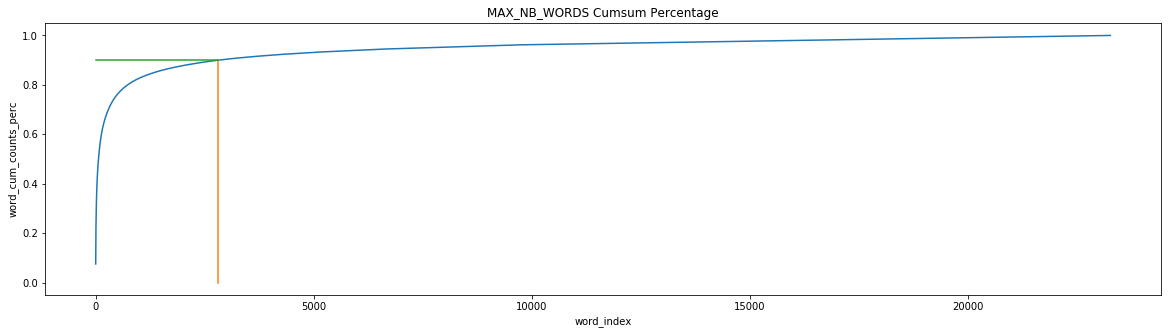

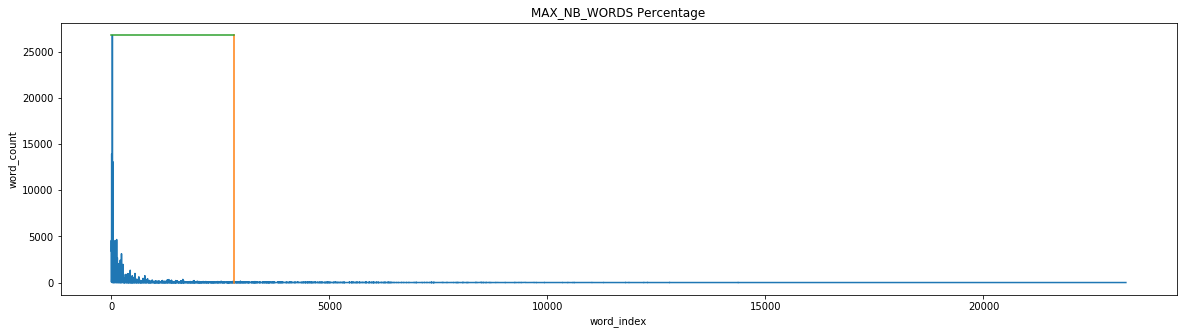

Cut index with 90.0 % of corpus:  2814 

    index  word  count
0      24     .  26806
1       8     i  13954
2      35     !  13099
3      12    to   8624
4      18   the   7739
5      43     a   5844
6     122    my   4666
7       1   you   4576
8      85    it   4545
9      70   and   4351
10      5     ?   3584
11      0    is   3414
12     32    in   3251
13    233   for   3125
14     86     s   3121
15    138     t   2699
16     22    of   2655
17     25  that   2550
18     42    on   2453
19    205    me   2425


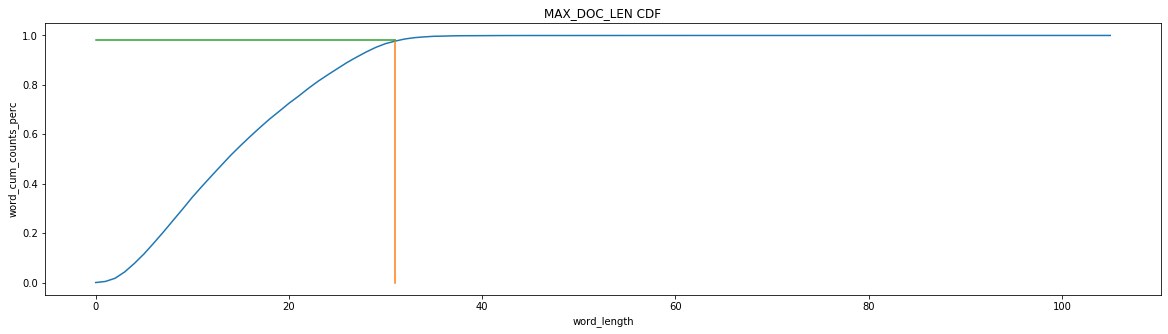

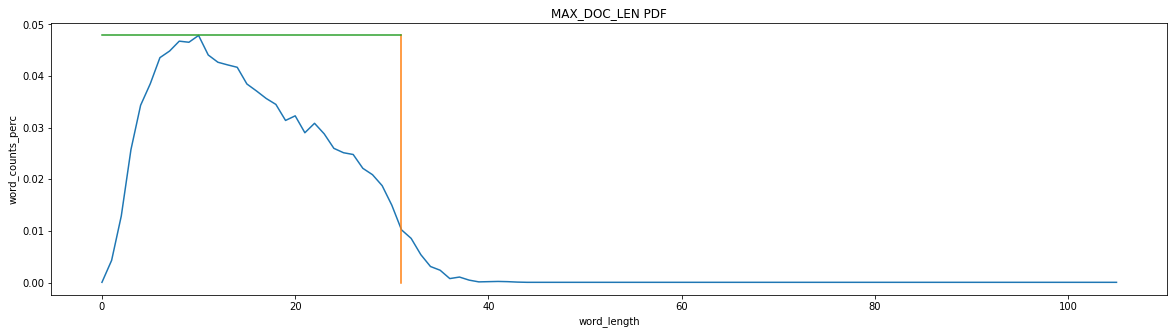

Cut index with 98.0 % of corpus:  31
Wall time: 2.14 s


In [8]:
%%time
corpus = raw_data['normalized_text']
# MAX_NB_WORDS_ratio = 0.95
# MAX_DOC_LEN_ratio = 0.98

MAX_NB_WORDS = eda_MAX_NB_WORDS(corpus, ratio = MAX_NB_WORDS_ratio_text, filters='',char_level = char_level_switch)
MAX_DOC_LEN = eda_MAX_DOC_LEN(corpus, ratio = MAX_DOC_LEN_ratio_text, filters='',char_level = char_level_switch)

# initialize
processor_x = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, corpus,filters ='',char_level = char_level_switch) 
data_en = processor_x.generate_seq(corpus)

max_en_words = MAX_NB_WORDS+1
max_en_len = MAX_DOC_LEN

In [9]:
print("max_en_len: ",max_en_len, "\nmax_en_words: ", max_en_words)
print("Total number of English words: ", len(processor_x.word_index))

max_en_len:  31 
max_en_words:  2815
Total number of English words:  23267


## selected_text - words level

In [10]:

# raw_data_selected_text_corpus = ['nlpstart '+ data + ' nlpend' for data in raw_data['normalized_selected_text']] The same
raw_data_selected_text_corpus = [str(symbols[0])+" "+normalize_string_keep_dot(data) + " " + str(symbols[1]) for data in raw_data["selected_text"]]
raw_data_selected_text_in = [str(symbols[0])+" " + normalize_string_keep_dot(data) for data in raw_data["selected_text"]] # 不是全部首尾都加
raw_data_selected_text_out = [normalize_string_keep_dot(data) + " " + str(symbols[1]) for data in raw_data["selected_text"]]

# decoder_input_data = processor_y.generate_seq(test["selected_text"].apply(lambda x: "nlpstart "+x)) ## 注意这里的decoder-input, 训练的时候是整个句子, 预测的时候, 是单个 nlpstart

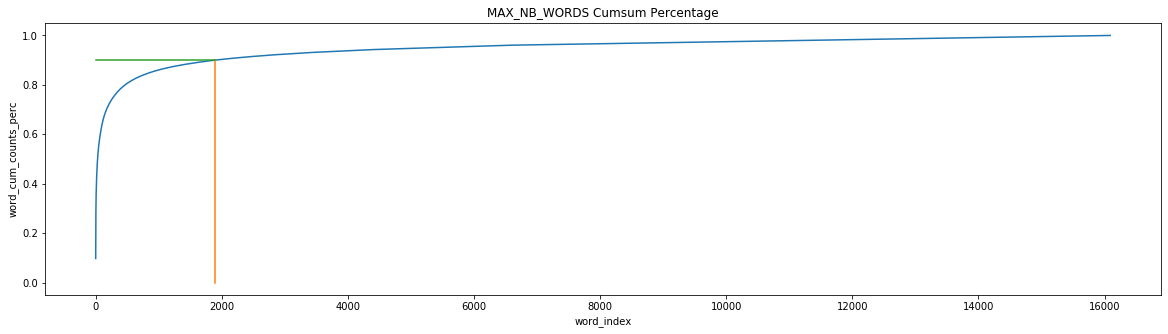

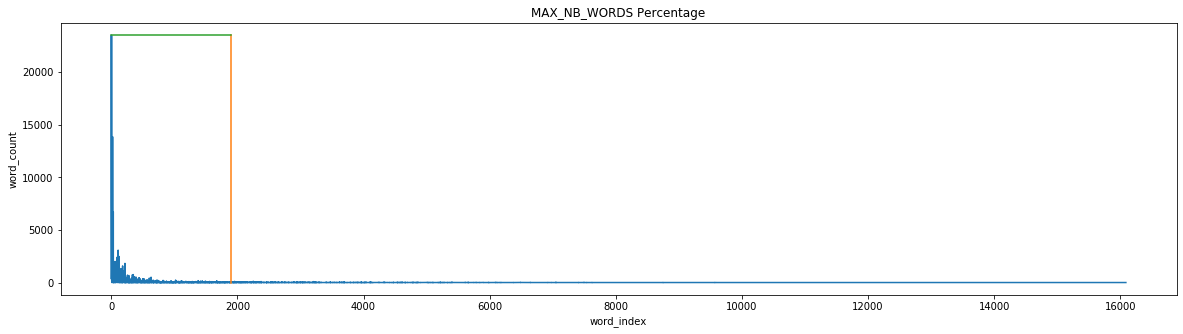

Cut index with 90.0 % of corpus:  1890 

    index      word  count
0       0  xxxstart  23500
1       3    xxxend  23500
2      20         .  13866
3       4         i   7577
4      31         !   6723
5       8        to   4579
6      14       the   3963
7     108         a   3079
8     125       you   2475
9      87        it   2392
10     95        my   2348
11     60       and   2001
12     56         ?   1936
13    216        is   1822
14     81         s   1745
15    100         t   1712
16     28        in   1703
17    179       for   1581
18     18        of   1395
19    154        me   1330


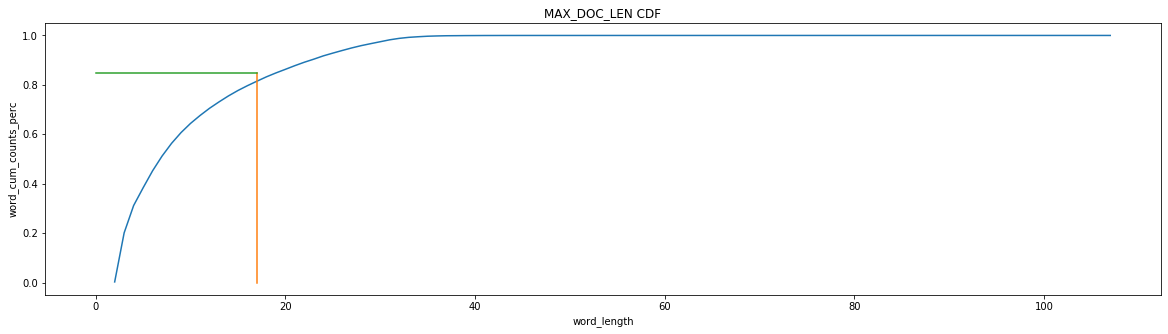

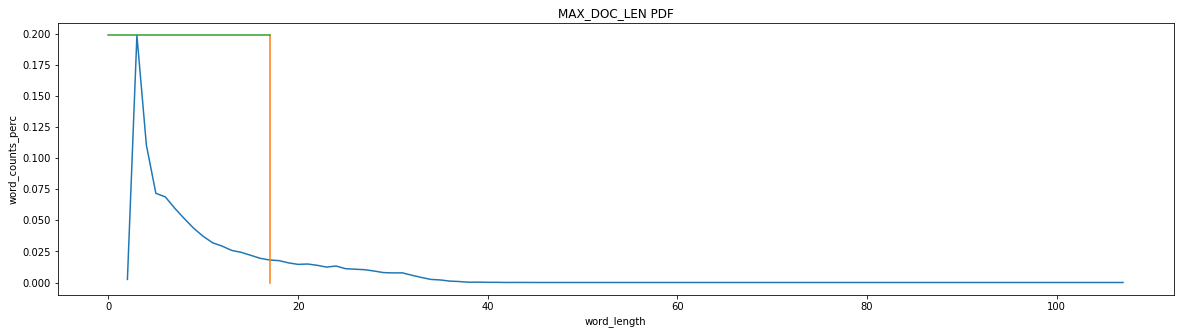

Cut index with 85.0 % of corpus:  17
Wall time: 2 s


In [11]:
%%time
corpus = raw_data_selected_text_corpus
# MAX_NB_WORDS_ratio = 0.95
# MAX_DOC_LEN_ratio = 0.98
MAX_NB_WORDS = eda_MAX_NB_WORDS(corpus, ratio =MAX_NB_WORDS_ratio_selected_text, filters='',char_level=char_level_switch)
MAX_DOC_LEN = eda_MAX_DOC_LEN(corpus, ratio = MAX_DOC_LEN_ratio_selected_text, filters='',char_level=char_level_switch)

# initialize
processor_y = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, corpus, filters ='',char_level=char_level_switch) 

data_fr_in = processor_y.generate_seq(raw_data_selected_text_in)
data_fr_out = processor_y.generate_seq(raw_data_selected_text_out)

max_fr_words = MAX_NB_WORDS+1 
max_fr_len = MAX_DOC_LEN 

In [12]:
print("max_selected_text_len: ",max_fr_len, "\nmax__selected_text_words: ", max_fr_words)
print("Total number of text words: ", len(processor_y.word_index))

max_selected_text_len:  17 
max__selected_text_words:  1891
Total number of text words:  16092


In [13]:
# Convert each word index using one-hot coding
data_fr_out_cat = to_categorical(data_fr_out, num_classes=max_fr_words)
data_fr_out_cat.shape
data_fr_out_cat[0,0]
data_fr_out_cat[0].shape # shape = (index, MAX_DOC_LEN, MAX_NB_WORDS )

(23500, 17, 1891)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

(17, 1891)

In [14]:
# Parameters
print("max_selected_text_len: ",max_fr_len, "\nmax_selected_text_words: ", max_fr_words)
print("max_text_len: ",max_en_len, "\nmax_text_words: ", max_en_words)

# mapping between indexes and words
print("index of symbol <xxxstart> :", processor_y.word_index[str(symbols[0])])
print("index of symbol <xxxend> :", processor_y.word_index[str(symbols[1])])


max_selected_text_len:  17 
max_selected_text_words:  1891
max_text_len:  31 
max_text_words:  2815
index of symbol <xxxstart> : 1
index of symbol <xxxend> : 2


# Teaching force S2S

## Pretrained Word embedding

In [15]:
%%time
CBOW_W2V_EN = processor_x.w2v_pretrain(embedding_dim) 
CBOW_W2V_FR = processor_y.w2v_pretrain(embedding_dim) 

Wall time: 12.4 s


## S2S Model - Fit

### encoder

In [16]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_en_len,)) # for attention layer, this should be fixed input length
# encoder_inputs = Input(shape=(None, num_encoder_tokens)) # 对于已经one-hot的input
# encoder_inputs = Input(shape=(None,))  # 不定长输入
encoder_embed = Embedding(max_en_words, embedding_dim, input_length=max_en_len, name='pretrained_en_embedding_trainable'
                            , weights=[CBOW_W2V_EN], trainable=True)(encoder_inputs)# embedding for en
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.0, recurrent_dropout=0.1) # return state 会 输出state, 没有这个, 会输出数值, 经过activation function之后的值
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed) # lstm has three output
encoder_states = [state_h, state_c]

### decoder

In [17]:
decoder_inputs = Input(shape=(None,)) # not fix input.
# decoder_inputs = Input(shape=(max_fr_words,)) #  fix input for attention
decoder_embedding = Embedding(max_fr_words, embedding_dim, input_length=None, name='pretrained_fr_embedding_trainable'
                            , weights=[CBOW_W2V_FR], trainable=True) # embedding for fr
decoder_embed = decoder_embedding(decoder_inputs)
# if return_state = False, output sth like the embedding features of the next words(类似于下一个词的特征)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.0, recurrent_dropout=0.1) 


# decoder_output1 is the key connection between decoder and encoder # Set up the decoder, using `encoder_states` as initial state.
decoder_lstm_output, state_h_tr, state_c_tr = decoder_lstm(decoder_embed, initial_state=encoder_states) # when training, the hidden state and cell state is not useful in this teaching force model

decoder_dense = Dense(max_fr_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm_output)
# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_outputs'= 'decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



### Training & Checkpoint
- It will monitor the val_loss with patience equal 10
- Use the validation set to compute the BLEU score and report the best choice


In [18]:
%%time
# batch_size=32
# epochs = 10
# Compile & run training
BestModel_Name = 's2s_tf_desk'
model.compile(optimizer= rmsprop, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


#### Best model selection 
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
# iteration_per_epoch =20
batch_size = int( len(data_en) / iteration_per_epoch ) # 200 iteration as one epoch
history = model.fit([data_en, data_fr_in],data_fr_out_cat, verbose = 2, epochs = epochs, batch_size=batch_size, validation_split=val_ratio, callbacks=[earlyStopping, checkpoint])
model.load_weights(BestModel_Name)


# Save model
# model.save('s2s_word_level.h5')

Train on 22325 samples, validate on 1175 samples
Epoch 1/100
 - 43s - loss: 3.2040 - categorical_accuracy: 0.5688 - val_loss: 2.4607 - val_categorical_accuracy: 0.6016
Epoch 2/100
 - 42s - loss: 2.3431 - categorical_accuracy: 0.6182 - val_loss: 2.3557 - val_categorical_accuracy: 0.6109
Epoch 3/100
 - 43s - loss: 2.2655 - categorical_accuracy: 0.6210 - val_loss: 2.2887 - val_categorical_accuracy: 0.6142
Epoch 4/100
 - 42s - loss: 2.1962 - categorical_accuracy: 0.6309 - val_loss: 2.2230 - val_categorical_accuracy: 0.6296
Epoch 5/100
 - 43s - loss: 2.1295 - categorical_accuracy: 0.6458 - val_loss: 2.1581 - val_categorical_accuracy: 0.6464
Epoch 6/100
 - 42s - loss: 2.0620 - categorical_accuracy: 0.6588 - val_loss: 2.0939 - val_categorical_accuracy: 0.6554
Epoch 7/100
 - 42s - loss: 2.0012 - categorical_accuracy: 0.6660 - val_loss: 2.0434 - val_categorical_accuracy: 0.6603
Epoch 8/100
 - 42s - loss: 1.9495 - categorical_accuracy: 0.6719 - val_loss: 2.0008 - val_categorical_accuracy: 0.6648

Epoch 69/100
 - 42s - loss: 0.8347 - categorical_accuracy: 0.8121 - val_loss: 1.5520 - val_categorical_accuracy: 0.7220
Epoch 70/100
 - 42s - loss: 0.8259 - categorical_accuracy: 0.8132 - val_loss: 1.5494 - val_categorical_accuracy: 0.7226
Epoch 71/100
 - 42s - loss: 0.8177 - categorical_accuracy: 0.8149 - val_loss: 1.5537 - val_categorical_accuracy: 0.7211
Epoch 72/100
 - 41s - loss: 0.8092 - categorical_accuracy: 0.8162 - val_loss: 1.5575 - val_categorical_accuracy: 0.7214
Epoch 73/100
 - 41s - loss: 0.8003 - categorical_accuracy: 0.8174 - val_loss: 1.5526 - val_categorical_accuracy: 0.7222
Epoch 74/100
 - 41s - loss: 0.7919 - categorical_accuracy: 0.8191 - val_loss: 1.5582 - val_categorical_accuracy: 0.7211
Epoch 75/100
 - 41s - loss: 0.7829 - categorical_accuracy: 0.8207 - val_loss: 1.5574 - val_categorical_accuracy: 0.7225
Epoch 76/100
 - 41s - loss: 0.7749 - categorical_accuracy: 0.8221 - val_loss: 1.5603 - val_categorical_accuracy: 0.7208
Epoch 77/100
 - 42s - loss: 0.7660 - cat

val_loss loss


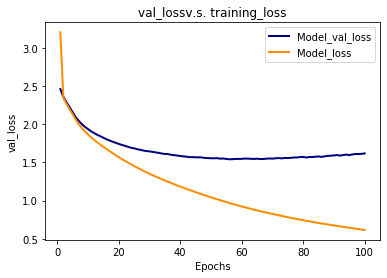

val_categorical_accuracy categorical_accuracy


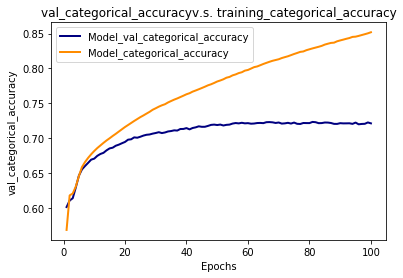

In [19]:
history_plot(history)

## S2S model - Inference

In [20]:
############################################# 重新定义encoder需要的部分, 但是训练的模型的参数保留了, 只是把训练完的layer拿过来
# 虽然直接运行 inference model也行, 但是效果很差. 一定要训练encoder部分, 然后encoder训练好的 layer 参数通过 下面这句话, 作为inference model的一部分. 且inference的时候, 不再求loss 也不再调整encoder参数
# 故不能重新定义, 而是需要衔接经过训练的 encoder 参数
encoder_inf = Model(encoder_inputs, encoder_states)  


############################################# 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# rebuild the decoder branch for inference
# decoder_embed = decoder_embedding(decoder_inputs) 
decoder_lstm_output, state_h, state_c = decoder_lstm(decoder_embed, initial_state = decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_lstm_output)

decoder_inf = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
# SVG(model_to_dot(decoder_inf, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

### Inference result & BLEU Score on Validation set

In [21]:
def decode_inference(test_source_text=None, attention=False, char_level=False, symbol=['nlpstart','nlpend'] , max_output =  30):
    
    if test_source_text is None:
        test_source_text = np.random.choice((raw_data.text))
    print('Input sentence:', test_source_text)
    input_seq = processor_x.generate_seq([test_source_text])
    

    if attention is False:
        states_value = encoder_inf.predict(input_seq) 
    else:            
        encoder_outputs, h, c = encoder_inf.predict(input_seq) 
        states_value = [h, c]


    # initial state of decoder
    target_seq = np.array(processor_y.word_index[str(symbols[0])]).reshape(1,1) # tf.constant([[processor_y.word_index['nlpstart']]])
    decoded_sentence = []
    while True:
        # predict - one time stamp
        if attention is False:
            output_tokens, h, c = decoder_inf.predict([target_seq] + states_value)
        else:            
            output_tokens, h, c = decoder_inf.predict([encoder_outputs, target_seq] + states_value)
            
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # update decoder input for inference next word 
        target_seq = np.array(sampled_token_index).reshape(1,1)
        states_value = [h, c]
        # save prediction result - one time stamp
        sampled_word = processor_y.index_word[sampled_token_index]
        # Exit condition: either hit max length or find stop character.
        if (sampled_word == str(symbols[1]) or len(decoded_sentence) > max_output):  # max_fr_len
            break
            
        decoded_sentence.append(sampled_word)    
    
    if char_level is False:
        res = ' '.join(decoded_sentence)
    else:        
        res = ''.join(decoded_sentence)
    print('Decoded sentence:', res) 
    return  res


def translate_result(test_data, attention=False):
    ref_list, translation = [], [] 
    ### Select a set of sentences from the testing data and print the translation results from the model (compare to the ground truth).
    for idx in range(len(test_data)):
        print('-'*30)
        
        decoded_sentence = decode_inference(test_data.normalized_text[idx], attention, char_level=char_level_switch, symbol=symbols, max_output = max_output_length )

        print('True sentence:', test_data.selected_text[idx])
        ref_list.append(test_data.normalized_selected_text[idx]) # tokens
        translation.append(decoded_sentence)

    ref_list = [tokenize_string(sentence).split() for sentence in ref_list]
    hyp_list = [tokenize_string(sentence).split() for sentence in translation]
    return ref_list, hyp_list, translation



ref_val, hyp_val, _ = translate_result(val_data, attention=False)

------------------------------
Input sentence:  one of my models from a photo shoot . stacey
Decoded sentence: one of a new
True sentence: http://twitpic.com/4wsst - one of my models from a photo shoot.  stacey
------------------------------
Input sentence: I m an incredibly happy person with 100 energy . Love to dance amp laugh . . .the only thing that I know .I m one of the most down to earth ppl
Decoded sentence: i m having a of stupid .
True sentence: I'm an incredibly happy person with 100% energy. Love to dance &amp; laugh
------------------------------
Input sentence:  Im glad you re a lot happier barakitten lt 3 see yah in july
Decoded sentence: im glad you ll do a long day
True sentence: Im glad
------------------------------
Input sentence:  I ve got a fairly flat route available . . . the problem is I no longer have a fully functional bike to ride
Decoded sentence: i have a good
True sentence: I've got a fairly flat route available... the problem is I no longer have a fully 

Input sentence: is a college graduate
Decoded sentence: is a
True sentence: is a college graduate
------------------------------
Input sentence: he s outta the ofc til Monday GRAND kinda bummed me out but b c I was genuinely sick there s nuthin I can do about it gt 
Decoded sentence: it s it s cold but i m missing out so late
True sentence: he's outta the ofc til Monday ::GRAND:: kinda bummed me out but b/c I was genuinely sick there's nuthin I can do about it  --&g
------------------------------
Input sentence:  I brought a buffalo 320gb for 3800 . . .it has the fastest transfer rate for a usb hdd . . .I benchmarked it at 34mb s on my comp ! ! !
Decoded sentence: has a . . . for it s the of to see the quot i want him
True sentence: fastest transfer rate
------------------------------
Input sentence:  I saw them at a show a few weeks ago . Hate to say I was not all that impressed fun . and AS were good though .
Decoded sentence: i had a feeling pretty bad .
True sentence: Hate
--------

Decoded sentence: back all day to all week . still missed a and follow me and sad
True sentence: Fun times
------------------------------
Input sentence:  tell your grandmother i say hello
Decoded sentence: hi go
True sentence: tell your grandmother i say hello
------------------------------
Input sentence:  WTF ! ! ! ! LMAO ! ! ! Just got hit in the head with bloody balls 
Decoded sentence: goodnight ! ! ! ! ! why i want some my
True sentence: WTF!
------------------------------
Input sentence: P Nutt got a new collar and leash today 
Decoded sentence: got a new and today
True sentence: P-Nutt got a new collar and leash today
------------------------------
Input sentence: I did that once
Decoded sentence: i did that
True sentence: I did that once
------------------------------
Input sentence: well i m gonna go now . goodbye all .
Decoded sentence: well i m gonna go back . . . its nothing to do
True sentence: well i'm gonna go now.  goodbye all.
------------------------------
Input sen

Decoded sentence: it s
True sentence: it's beeen onee year
------------------------------
Input sentence:  com125 we have a quiz ! again . . Feliza is bugging us again its getting very annoying !
Decoded sentence: god bless
True sentence: its getting very annoying!
------------------------------
Input sentence: HAPPY MOTHER S DAY TO MY BEAUTIFUL MOMMIES
Decoded sentence: happy
True sentence: HAPPY MOTHER'S DAY
------------------------------
Input sentence: At the movies . . . About to watch Star Trek !
Decoded sentence: about to the new mom on . . .
True sentence: At the movies. . . About to watch Star Trek!
------------------------------
Input sentence: in a very stress mood
Decoded sentence: in a very new too
True sentence: in a very stress mood
------------------------------
Input sentence:  Oh whoops my bad
Decoded sentence: bad
True sentence: Oh whoops, my bad
------------------------------
Input sentence:  and that prob wont happen . . . .
Decoded sentence: that was . . . and we 

Decoded sentence: great
True sentence: Have a great day everyone
------------------------------
Input sentence: I wanted to see the story on ACORN tonight on Glen Beck but I missed it
Decoded sentence: i m at the but i wanna go online on saturday now
True sentence: missed
------------------------------
Input sentence: wishes a Happy Mother s Day to all mothers ! Especially her own . 
Decoded sentence: happy
True sentence: wishes a Happy Mother's Day to all mothers!
------------------------------
Input sentence:  I have trouble updating ! ! !
Decoded sentence: i have a few days on me lol
True sentence: I have trouble updating!!!
------------------------------
Input sentence:  Jean awessomee ! cut my hurrr i give massage ? orr alkie ? or foodtour ? yeaaah ! amp i ll pray for ur cousin
Decoded sentence: ? ? ! ! let me but i take to get for the weekend !
True sentence: awessomee!
------------------------------
Input sentence:  I m having exactly the same day you are man . Just buried over 

Decoded sentence: i cant wait to my today with my way to
True sentence: I cant WAIT to be home and snuggle with my puppies! and my Fiance
------------------------------
Input sentence: just got up smoking a cig and drinking coffee . . i need to start working on my final project for the univ
Decoded sentence: finally left out my to the new phone . .
True sentence: just got up, smoking a cig and drinking coffee.. i need to start working on my final project for the univ
------------------------------
Input sentence:  Good luck with your breakfast search . But here in the US I have to go to bed . lol . Goodnight David .
Decoded sentence: good luck
True sentence: Good luck wi
------------------------------
Input sentence:  and it never arrived . have to wait until Monday now
Decoded sentence: it ll have to buy an hour but then not up .
True sentence: never
------------------------------
Input sentence:  What you said is as good as day dreaming ! sorry to say that our country is in such a st

Decoded sentence: wishing it was
True sentence: Wishing
------------------------------
Input sentence:  at least she doesnt try to violently hump you like my female dog does
Decoded sentence: thats so
True sentence: e doesnt try to violently
------------------------------
Input sentence: 7 hours and many massages later I can now spend time with my wife and son . It s mother s day ya ll . Don t forget to grab a gift or card .
Decoded sentence: i can t wait and it time . . . now and go see it and then some . i may be a gift
True sentence: 7 hours and many massages later, I can now spend time with my wife and son. It's mother's day ya'll. Don't forget to grab a gift or card.
------------------------------
Input sentence: i m celebrating my mother ! ! and also celebrating my legacy as a woman of God .
Decoded sentence: 
True sentence: celebrating
------------------------------
Input sentence:  yen lol but i can only get the vid on my phone and ipod cant find the song lol
Decoded sentence: 

Decoded sentence: i want to but but i could be it too at the kids can t wait but all
True sentence: I want to call you but it would cost to much  But Maybe my parents will say okay =D
------------------------------
Input sentence: On the airport in Philadelphia at the moment waiting for the plane to leave in about an hour . Just six more hours on a plane
Decoded sentence: on the on the at least then wishing to be the pool . . .i m at work
True sentence: On the airport in Philadelphia at the moment, waiting for the plane to leave in about an hour. Just six more hours on a plane
------------------------------
Input sentence: y must i hve graduation practice . . .all im gonna is walk
Decoded sentence: hey now i am but . .
True sentence: y must i hve graduation practice...all im gonna is walk
------------------------------
Input sentence:  happy birthday and congrats wish you were here for your lady . .ill take care of her 
Decoded sentence: love
True sentence: happy birthday  and  congrat

Decoded sentence: yay !
True sentence: .perfect
------------------------------
Input sentence: last day at Adobe buuuut I just registered for online tech writing course !
Decoded sentence: last day at back to and i can up ?
True sentence: last day at Adobe  buuuut I just registered for online tech writing course!
------------------------------
Input sentence: Had a shower . it s 5 55 PM . Triple 5 s ! it just turned 5 56
Decoded sentence: it s just had a day ! still good but . . .
True sentence: Had a shower. it's 5:55 PM. Triple 5's! ****, it just turned 5:56
------------------------------
Input sentence:  meaway I m sorry hon I know how it feels though . . .I m usually crazy but at a family gathering I d probably hold back like that also
Decoded sentence: i m sorry but i m so i dont know it will use out of and . . .
True sentence: sorry
------------------------------
Input sentence: Don t really wanna go school on Monday to be honest
Decoded sentence: really really go to make my
True

Decoded sentence: going to and !
True sentence: tasty!
------------------------------
Input sentence:  Hey ! Polka dots or black dress . Both very glam . Mobile twitter s a bit at the mo .
Decoded sentence: hey !
True sentence: Hey! Polka dots or black dress. Both very glam. Mobile twitter's a bit **** at the mo.
------------------------------
Input sentence: just hanging around the house . Thank god its friday . With nina amp later and working on a global project
Decoded sentence: goodnight
True sentence: Thank god
------------------------------
Input sentence:  me and my mom s cars were broken into . I feel violated .
Decoded sentence: sad .
True sentence: I feel violated.
------------------------------
Input sentence: Jennnnnn richhhh wast to the ed
Decoded sentence: to the hour
True sentence: Jennnnnn richhhh wast to the ed
------------------------------
Input sentence: in computer class photo booth doesn t work
Decoded sentence: only in new
True sentence: in computer class, photo 

Decoded sentence: hmm . work to work for the time in a . but i m on a trip to ! ! haha for the same night ?
True sentence: cheap se
------------------------------
Input sentence: JoBo s tired of getting off work at 7
Decoded sentence: tired
True sentence: tired
------------------------------
Input sentence: She is beautiful . But don t feel badly . Some neaby grans see grandkids about the same amt . Can t go to them out of luck
Decoded sentence: wow . but i think she is up some good . my internet doesn t all out . sorry for my or ?
True sentence: She is beautiful . But don't feel badly. Some neaby grans see grandkids about the same amt.   Can't go to them = out of luck
------------------------------
Input sentence: later I went up to monroe and worked out with friends TRX ropes and KBs ! ! 30sec on 30 off . .rope swings amp c amp ps windmills wve aquats
Decoded sentence: i went up and to go on and now . i wanted to start up .
True sentence: later I went up to monroe and worked out with

Decoded sentence: the . me a bit on . . not in other ? please follow
True sentence: won.
------------------------------
Input sentence:  Cool rite ?
Decoded sentence: cool
True sentence: Cool rite?
------------------------------
Input sentence:  working my 4 day weekend is over aah well another one coming in 2 weeks
Decoded sentence: up is working in the same . too and its a good time
True sentence: working, my 4-day weekend is over, aah well another one coming in 2 weeks
------------------------------
Input sentence:  NAT ! ! ! I m going to miss you so badly
Decoded sentence: miss
True sentence: miss
------------------------------
Input sentence:  Celebrity sighting Spongebobs here ! BEA09 LOL ! Now I m even more distraught I missed it
Decoded sentence: ! ! ! i ll feel better than you can t on my right now
True sentence: I misse
------------------------------
Input sentence: Up and packing . Its the last day of youth camp
Decoded sentence: up the
True sentence: Up and packing. Its the

Decoded sentence: haha ! ! ! ! thank him i miss you and won t be done on the night . . thanks to do ?
True sentence: I WISH
------------------------------
Input sentence:  You just noticed this about girls ? Welcome to adulthood !
Decoded sentence: you just watched the latest last night i wanna see them
True sentence: You just noticed this about girls?  Welcome to adulthood!
------------------------------
Input sentence: watching The Biggest Loser on Hallmark . Never fails to make me cry nyeh .
Decoded sentence: the dr .
True sentence: watching The Biggest Loser on Hallmark. Never fails to make me cry  nyeh.
------------------------------
Input sentence:  I ve been !
Decoded sentence: i ve been
True sentence: :  I've been!
------------------------------
Input sentence: meeting just in time that i m trying to win something prize s friday !
Decoded sentence: just hope i have to make it to move on night ?
True sentence: meeting just in time that iï¿½m trying to win something  prize's frid

Decoded sentence: awww that would be getting better
True sentence: You saw that fraktastic zoidberg painting that was tweeted around last week or so, didn't you?
------------------------------
Input sentence: Walking the puppies downtown . Also mystery of missing cat solved he locked himself in basement for nearly two days .
Decoded sentence: missing
True sentence: Walking the puppies downtown. Also, mystery of missing cat solved: he  locked himself in basement for nearly two days.
------------------------------
Input sentence: can t believe he has to wait till October to see quot Up ! quot when Americans get to see it this weekend .
Decoded sentence: can t wait to see on !
True sentence: can't believe he has to wait till October
------------------------------
Input sentence: May the fourth be with you . Oh come on no one had actually spelled it out yet
Decoded sentence: may the fourth be with you .
True sentence: May the fourth be with you.  Oh come on, no one had actually spelled it 

Decoded sentence: feeling good at all that long .
True sentence: good
------------------------------
Input sentence:  Actually maybe not it s sold out for Sat lunch
Decoded sentence: oh it s not at least but i will take her .
True sentence: Actually maybe not - it's sold out for Sat lunch
------------------------------
Input sentence: More sunburn
Decoded sentence: sunburn
True sentence: sunburn
------------------------------
Input sentence: well paisley has one of those cone things around her head . . .SO funny but I feel bad for her
Decoded sentence: has one for as good but its a good phone .
True sentence: well paisley has one of those cone things around her head...SO funny but I feel bad for her
------------------------------
Input sentence:  whatever pung ! haha . . i dont care . JK
Decoded sentence: haha ! haha . . . i only one of 3 weeks are much
True sentence: whatever pung ! haha.. i dont care. JK
------------------------------
Input sentence:  haha you would do that P that s 

Decoded sentence: wow . . . .
True sentence: wow.. purple leopard skin.  fieeerrceee..
------------------------------
Input sentence: Good morning sunshine ! I mm gonna start my day wth some movies .
Decoded sentence: morning . day of fun
True sentence: Good morning, sunshine!
------------------------------
Input sentence:  Headaches suck especially stress related ones . I used to get those a lot . lt 3
Decoded sentence: don t want to talk ! me .
True sentence: Headaches suck, especially stress related ones. I used to get those a lot.  &lt
------------------------------
Input sentence: Ugh . Another quot what day is it today ? quot 5 most uttered words last 2 weeks for me Missed a 10 yr old birthday amp it was even on my iCal .
Decoded sentence: morning and the new that makes me this about a few days ago . maybe they are that eating a few mins but about to
True sentence: Ugh. Another &quot;what day is it today?&quot; (5 most uttered words last 2 weeks for me) - Missed a 10 yr old birth

Decoded sentence: d be
True sentence: I love B&amp;BWs new scent
------------------------------
Input sentence: I ve got to meet him tomorrow midday and hopefully fingers crossed it ll all be sorted . My head is still hurting though .
Decoded sentence: i have been hopefully
True sentence: I've got to meet him tomorrow, midday and hopefully, fingers crossed, it'll all be sorted. My head is still hurting though.
------------------------------
Input sentence: I m jumping off the nearest bridge if I can t have it
Decoded sentence: can i m i m in the but i have to see the same ?
True sentence: I'm jumping off the nearest bridge if I can't have it
------------------------------
Input sentence:  correct ! I ADORE him . I just plucked him up and put him under my arm cuz he was cryin . All better now ! Hahaha
Decoded sentence: him
True sentence: ADORE
------------------------------
Input sentence: Up I slept in till 11 .02 ! ! ! Shooting a new vid today
Decoded sentence: new 1 day ! ! !
True se

Input sentence: Never made it to the gym so will be doing my blowout sans thong wearing company . Phew ! But bummer on missing workout
Decoded sentence: just finished the rest of my camera so waiting to it out . . .hope you are out no new for a
True sentence: bummer
------------------------------
Input sentence: watching Jon amp Kate plus 8 . .can t believe they re divorcing
Decoded sentence: watching . from s can t watch
True sentence: 8..can't believe they're divorci
------------------------------
Input sentence: HAPPY MOTHERS DAY !
Decoded sentence: happy mothers day !
True sentence: HAPPY
------------------------------
Input sentence: Allies not coming over
Decoded sentence: not not gonna watch you
True sentence: Allies not coming over
------------------------------
Input sentence: Shower head broke while i was in the shower and shot straight my head .may get a welt later on from it
Decoded sentence: broke
True sentence: shot straight
------------------------------
Input sentence: 

Decoded sentence: i m getting ready and to see that
True sentence: i'm trying to figure that out right now
------------------------------
Input sentence: best part of notting hill is on ! ! quot daft prick quot haha love it .
Decoded sentence: is the of bad
True sentence: best part of notting hill is on!!  &quot;daft prick&quot; haha
------------------------------
Input sentence:  Im soooo intrigued ! I want to try this weekend . Kaya lang baka maaddict ako .
Decoded sentence: im soooo ! i want to sleep .
True sentence: intrigued!
------------------------------
Input sentence:  i want to go here
Decoded sentence: i want to go here
True sentence: http://bit.ly/Wl9yL  i want to go here
------------------------------
Input sentence: Morning all finally got to stream media from PC to PS3 via wireless router much easier than using a USB dongle ah techy simplicity .
Decoded sentence: its making a
True sentence: much easier
------------------------------
Input sentence:  There isn t any right

Decoded sentence: my more days to go from our myspace
True sentence: six more finals to go
------------------------------
Input sentence: may the 4th be with you
Decoded sentence: may the 4th be with you
True sentence: may the 4th be with you
------------------------------
Input sentence: I want to party down !
Decoded sentence: i want to party down !
True sentence: I want to party down!
------------------------------
Input sentence:  WHAT THAT S NOT FAIR I CAN T VOTE IT SAYS THE VOTING IS CLOSED BUT I DID VOTE EVERYDAY WHEN I COULD VOTE LIKE 20X S
Decoded sentence: it s that s not what i think they won t be any of the
True sentence: THAT'S NOT FAIR
------------------------------
Input sentence:  . . . .welcome to public transport X
Decoded sentence: . . .
True sentence: ....welcome to public transport  X
------------------------------
Input sentence: Getting bored sitting at the hotel room the entire day
Decoded sentence: bored
True sentence: bored
------------------------------
Input

Decoded sentence: sick
True sentence: I am sick  but Ians coming over so its all good ;)
------------------------------
Input sentence: Men it s far too sunny
Decoded sentence: it s too much
True sentence: sunny
------------------------------
Input sentence: taking requests for nkkairplay
Decoded sentence: for starbucks
True sentence: taking requests for nkkairplay
------------------------------
Input sentence: waiting to go to 4th period to get the final over with . omgg im sooo gonna fail
Decoded sentence: hoping
True sentence: . omgg im sooo gonna fail
------------------------------
Input sentence: At work full of weekend vengaboys zane lowe wolf from gladiators memories
Decoded sentence: lovely
True sentence: At work full of weekend vengaboys zane lowe wolf from gladiators **** memories
------------------------------
Input sentence: elliott claims steak and shake has been doing this for months . . .not exciting anymore . . .
Decoded sentence: im good
True sentence: not exciting any

Decoded sentence: good
True sentence: I haven't had one for a long time. Too expensive
------------------------------
Input sentence:  welcome back chica ! hope you had a nice break
Decoded sentence: nice
True sentence: hope you had a nice break
------------------------------
Input sentence: Have a slight headache
Decoded sentence: headache
True sentence: headache
------------------------------
Input sentence: Hello !Im back andIm drunk and as much asI love my friends I hate how they unintentionally make me feel inadequate .Ineedhelp
Decoded sentence: hate
True sentence: sI love my friends,I hate how they unintentionally make me feel inadequate.Ineedhelp
------------------------------
Input sentence: Right I must be off to do some sewing . Bye x
Decoded sentence: i off some but i just got ready for a pic or something to go
True sentence: Right, I must be off to do some sewing. Bye x
------------------------------
Input sentence:  ohh yeahh with the showcase he said his artist will be o

Decoded sentence: i love it
True sentence: love
------------------------------
Input sentence:  Yavanna me too . she s everywhere . . .
Decoded sentence: me . . . .
True sentence: _Yavanna me too. she's everywhere...
------------------------------
Input sentence:  Ha ! I dunno about standing anything up . Very very rough today . It hurts to talk .
Decoded sentence: very excited
True sentence: p.  Very very rough today.  It hurts to ta
------------------------------
Input sentence: maxin and relaxin almost bed time
Decoded sentence: and finally time out
True sentence: maxin' and relaxin', almost bed time
------------------------------
Input sentence: Leaving Wildwood tomorrow but Luke says we will be back soon !
Decoded sentence: will be paid !
True sentence: Leaving Wildwood tomorrow  but Luke says we will be back soon!
------------------------------
Input sentence:  Yes it s beautiful and i m fortunate to live in the thick of it . .Very relaxing
Decoded sentence: yes it was the of the

Decoded sentence: my new had a nice day online is going to revision .
True sentence: neat
------------------------------
Input sentence:  i would prefer 1 more monday
Decoded sentence: i am too late
True sentence: i would prefer 1 more monday
------------------------------
Input sentence: I hate only having 1gb ram to use as host and 1gb for Virtual Machine Sucks so much
Decoded sentence: hate
True sentence: hate
------------------------------
Input sentence:  Too easy ! Happy Mother s Day to a great mom !
Decoded sentence: happy
True sentence: Happy Mother's Day,
------------------------------
Input sentence: Stuck in traffic on the 91 on the way to costa mesa
Decoded sentence: stuck
True sentence: Stuck in tr
------------------------------
Input sentence:  i want you to go walking with me ! ! but i still miss my satan
Decoded sentence: i miss you
True sentence: t i still miss my satan
------------------------------
Input sentence: I ll try to put together a list for a portfolio to pu

True sentence: i think iv hurt my tooth  and eilish and cassie are having a drawing competiton to draw cookies and pineapples haha :L .
------------------------------
Input sentence: cant believe i stay out this late ! . . . . .waking up for work in T minus 4hours
Decoded sentence: i cant believe
True sentence: late!.
------------------------------
Input sentence:  i ve seen inkheart i liked it too
Decoded sentence: i hope
True sentence: i liked
------------------------------
Input sentence: alphonso milkshake in the morning lassi in the afternoon and fresh nimbupaani in the evening . . . .summers can be fun
Decoded sentence: in the morning in a . . . both of the time to get back and hope you missed the weekend
True sentence: summers can be fun
------------------------------
Input sentence:  I agree . I danced with my dad to quot Kind amp Generous quot at my wedding . HUGE fan .
Decoded sentence: i
True sentence: agree.
------------------------------
Input sentence: there s nothing wor

Decoded sentence: i love it . i will be on and . i was no to be out soon
True sentence: i love it to.. but i knw there gna cut stuff out on tv
------------------------------
Input sentence:  okay thanks !
Decoded sentence: thanks
True sentence: thanks!
------------------------------
Input sentence:  pooof .nirvana . Did that work ? 
Decoded sentence: .
True sentence: pooof .nirvana. Did that work?  http://myloc.me/tDl
------------------------------
Input sentence: Coffee didn t turn out good tiday but excellent !
Decoded sentence: pretty
True sentence: Coffee didn't turn out good tiday but excellent!
------------------------------
Input sentence: losing weight check the pic
Decoded sentence: thinking of the kids now
True sentence: losing weight  check the pic
------------------------------
Input sentence: frame damage . . . car could be totalled
Decoded sentence: . . .
True sentence: damage..
------------------------------
Input sentence: is playing with Windows 7 RC
Decoded sentence: 

Decoded sentence: thanks !
True sentence: Thanks!
------------------------------
Input sentence:  Yup sometimes kc it s raining here in Pque but in Las Pinas it s not . So just wondering .
Decoded sentence: glad
True sentence: Yup, sometimes kc it's raining here in Pque but in Las Pinas it's not. So just wondering.
------------------------------
Input sentence:  You realllllllllly just said that didn t you ?
Decoded sentence: you just didn t that you ?
True sentence: You realllllllllly just said that didn't you?
------------------------------
Input sentence: Boy is all graduated ! So proud of him !
Decoded sentence: very bad
True sentence: !  So proud of him!
------------------------------
Input sentence: blerg you Monday why must you always come . Decent weekend new glasses hair color and got carded at Gamestop awesome ego boost
Decoded sentence: awesome
True sentence: blerg, **** you Monday, why must you always come.  Decent weekend, new glasses, hair color and got carded at Gamestop

In [22]:
# test_data

In [23]:
bs = np.array([bleu(ref_val, i) for i in hyp_val])
# bs = np.array([bleu(i[0], i[1]) for i in zip(ref_val, hyp_val)])
np.mean(bs)

0.03563564533508908

### Evaluate on test set

In [24]:
ref_test, hyp_test, translation = translate_result(test_data, attention=False)

------------------------------
Input sentence:  oh wait i messed up my own messed up lyrics that should be quot don t concretize it quot 
Decoded sentence: make that i think that work and i have about some of the end of see anything about work now
True sentence: messed
------------------------------
Input sentence: Funtime was not a lot of fun ! ! But finally done with it
Decoded sentence: a fun
True sentence: fun!!
------------------------------
Input sentence:  ohh shardup ! hehe . hes hot lah gotta admeeet ! bleh .
Decoded sentence: haha !
True sentence: ohh shardup! hehe. hes hot lah, gotta admeeet! bleh.
------------------------------
Input sentence:  . .dat dude look crazy w dat hair on his face lmao . .stop it ! ! . .the old wrestlers went to TNA thanks Vince . .these dudes are clowns lol
Decoded sentence: . . .
True sentence: .these dudes are clowns
------------------------------
Input sentence: is gonna go yoga ing with a jumbo cup of coffee ! ! ! ! ! Thinking about it is maki

Decoded sentence: to school on a little for a long time of her when they were the sun ? its too many ice cream !
True sentence: dead bird
------------------------------
Input sentence:  Mark Twain quote is spot on my cat is a bugger when it comes to crime ! Handy at times
Decoded sentence: is my to first one on a new episode of you dont know
True sentence: Handy at times
------------------------------
Input sentence:  haha we had balcony seats not that great . there s a giant dragon thing that has glowing red eyes and moves its wings !
Decoded sentence: that s a little girl .
True sentence: not that great.
------------------------------
Input sentence:  Welcome They are beautiful snow leopards .
Decoded sentence: cool
True sentence: e beautiful
------------------------------
Input sentence: Nvd i was sitting on it
Decoded sentence: i was there
True sentence: Nvd i was sitting on it
------------------------------
Input sentence: Happy Mums Day This is Nelly s shout out 
Decoded sentence

True sentence: O dear! HE'S HERE! OMGOGMGO.. U didn't see that I was going to **** u..?
------------------------------
Input sentence: shower time
Decoded sentence: time
True sentence: shower time
------------------------------
Input sentence: He still doesn t love me . . . I won t ask again
Decoded sentence: i don t really want to . . . hope he s like up ?
True sentence: He still doesn't love me..
------------------------------
Input sentence: My ear are popping .
Decoded sentence: 
True sentence: My ear are popping.
------------------------------
Input sentence:  that doesn t sound like fun
Decoded sentence: that doesn t like my nails !
True sentence: doesn't sound like fun
------------------------------
Input sentence: Working on this Financial project Definitely not having any fun this weekend I want to spend it wit my BAAABY waaaah
Decoded sentence: working so fair
True sentence: Definitely not having any fun this weekend
------------------------------
Input sentence:  Thanks hon 

True sentence: horrible.
------------------------------
Input sentence: Drink 7 or 8 for me at the club . Been drinking for the past 6 hours . 
Decoded sentence: on me for the . . . time for a new show on them .
True sentence: Drink #7 or 8 for me (at the club). Been drinking for the past 6 hours.  http://twitpic.com/4wn9q
------------------------------
Input sentence: All new implementation of test discovery for unittest . This time in a loader . Good start I think . 
Decoded sentence: off in the weekend
True sentence: Good start
------------------------------
Input sentence: feel like going home and sleep till the next day !
Decoded sentence: like
True sentence: feel like going home and sleep till the next day!
------------------------------
Input sentence: needs shows before wednesay ! ! ! oh well . . . come one come all . . . Irvine Improv live Gotham Showcase 8pm lots of good comics . . .then me .
Decoded sentence: should come . . . . . . . you found us ! be a
True sentence: good 

Decoded sentence: i m i ve had for this is too . but im not in the and i could do that one yet !
True sentence: i just had the weirdest dream ever and can't see because owi credo is too brighi. But i hate guys
------------------------------
Input sentence: doesnt want exams next week
Decoded sentence: doesnt want some hours
True sentence: doesnt want exams next week
------------------------------
Input sentence: Dancing was alright todayy still doing Jai Ho ! !
Decoded sentence: soooo much !
True sentence: Dancing was alright to
------------------------------
Input sentence: that little girl still holding her phone while tears are pouring out of her eyes
Decoded sentence: that girl follow her this year is coming up .
True sentence: that little girl still holding her phone while tears are pouring out of her eyes
------------------------------
Input sentence:  Good morning and thank you for the re tweet . Have a great day yourself .
Decoded sentence: good
True sentence: great
-----------

Decoded sentence: finally made it s goin to work on out of all at work ! i m still in the rest of monday
True sentence: Okay gots to go and now for the first time since it started will miss the Block Party on
------------------------------
Input sentence:  mitchell i tryed to add you on xbox live lastnight during when i was in your live show but your friends list is full
Decoded sentence: i live when i ll you on your way to now but am about
True sentence: mitchell i tryed to add you on xbox live lastnight during when i was in your live show, but your friends list is full
------------------------------
Input sentence: Hoping my mom likes her pamper gifts I sent her
Decoded sentence: hoping
True sentence: Hoping
------------------------------
Input sentence:  I am jealous . . .Ur koi fish are getting ur attention amp I m not . . . . .lmao I m kidding ! !
Decoded sentence: i m sorry
True sentence: I am jealous...Ur koi fish are getting ur attention &amp; I'm not.....lmao   I'm kidd
------

Decoded sentence: i should be right now
True sentence: As do I  Leopold says hello.
------------------------------
Input sentence: I started X Slimmer at eight this morning it s still going I hate that it always want s my friggin password .
Decoded sentence: i hope it s so much as
True sentence: hate
------------------------------
Input sentence:  I m glad you threw the tantrum ! I was going to but I don t know her well enough yet Was she apologetic darn her ! ?
Decoded sentence: i m glad
True sentence: I'm glad you threw the tantrum!  I was going to, but I don't know her well enough yet   Was she apologetic, darn her
------------------------------
Input sentence: is waiting for the final of shipwrecked to start . goodtimes . lt 3
Decoded sentence: is waiting for the of hours to sleep for school .
True sentence: goodtimes.
------------------------------
Input sentence: going to bed
Decoded sentence: going to bed
True sentence: going to bed
------------------------------
Input sentence:

Decoded sentence: happy mother s day
True sentence: aww happy mother's day
------------------------------
Input sentence: So bummed that I can t see LTJ in June hoping for a UK yoke soon
Decoded sentence: so glad
True sentence: bummed
------------------------------
Input sentence:  awww . rusks are good for tummy aches though p try fennel or camomile tea works . or obviously try . . .
Decoded sentence: thanks for some of those are . . . just a good thing but anyone else gonna make it off 2 weeks !
True sentence: good for tummy aches
------------------------------
Input sentence: is home whoott . Happy Mother s Day Madre
Decoded sentence: is happy mother s day .
True sentence: Happy
------------------------------
Input sentence:  i did a couple hours ago . . .ive got sun burn and its really uncomfortable
Decoded sentence: i am the no 1 got a few on hours ago . so far away from . .
True sentence: uncomfortable
------------------------------
Input sentence:  meeee too . i am listening to 

Decoded sentence: omg i love this song . . . gonna see u ? ?
True sentence: omg...did I just see a tweet from Miss Bonnie??? amazing...my phone died yesterday...and oster has alltel  I miss you
------------------------------
Input sentence: I d rather be at BEATweetup . Instead I m taking my cue from and shutting down . reprezent zent !
Decoded sentence: i believe i had to be at school and no more . like amp i m gonna be there then some of my
True sentence: I'd rather be at #BEATweetup.  Instead, I'm taking my cue from  and shutting down.   reprezent-zen
------------------------------
Input sentence: going to check and make sure no more fishies are dead . poor fishies
Decoded sentence: cool
True sentence: dead.
------------------------------
Input sentence:  good luck chan ! gue kmrn bawa backpack kosong quite helping
Decoded sentence: good luck
True sentence: good luck chan!
------------------------------
Input sentence: This quot Monarchy quot is gonna bleed ALL of us dry ! We are no

Decoded sentence: happy mother s day
True sentence: Happy Mother's Day
------------------------------
Input sentence: Is feeling like he has a bad flu . Yes . Bad . Flu .
Decoded sentence: bad
True sentence: bad
------------------------------
Input sentence: is jealous of his family their all having an amazing breakfast and all i get is rice crispies
Decoded sentence: sad
True sentence: is jealous of his family  their all having an amazing breakfast and all i get is rice crispies
------------------------------
Input sentence:  How come everyone seems to make so much more money than me .
Decoded sentence: how im better make a much to bed soon
True sentence: How come everyone seems to make so much more money than me.
------------------------------
Input sentence: Adobe After Effects and MS SQL Server . . .nice . would it be nicer if I just sleep ?
Decoded sentence: but . . but i have only as well be in the sun is still paid for ?
True sentence: nice.
------------------------------
Input 

Decoded sentence: i miss
True sentence: i think i need a drink
------------------------------
Input sentence: 1st day of master cleanse . . .wish me luck
Decoded sentence: . day luck me .
True sentence: 1st day of master cleanse...wish me luck
------------------------------
Input sentence:  not in this part of Surrey either feeling quite a bit nippy I must say . Afternoon to you
Decoded sentence: not like in a of me
True sentence: feeling quite a bit nippy I must say.
------------------------------
Input sentence: hey guys i went to Jenny s house today ! ! i had so much fun so how about everyone else ? what did u guys doo ?
Decoded sentence: i am so well .
True sentence: i had so much fun
------------------------------
Input sentence:  aww homesick i feel you ! im homesick for my 2nd home campp
Decoded sentence: 
True sentence: homesick
------------------------------
Input sentence:  i love you . don t leave me !
Decoded sentence: i love you .
True sentence: i love you.
---------------

Decoded sentence: need online at work
True sentence: See FTSK tonight in Grand Rapids
------------------------------
Input sentence: It s hard to tell But I think I m right I hope .
Decoded sentence: sucks
True sentence: It's hard to tell But I think I'm right   I hope.
------------------------------
Input sentence:  oooooo . i like that too ! anywhere near mommy is good for me .
Decoded sentence: good
True sentence: good
------------------------------
Input sentence:  ok thanks do you like my new pic ? 
Decoded sentence: thanks
True sentence: thanks
------------------------------
Input sentence: According to Marco smoking weed makes you philosophical . . . . I consider myself philosophical . In the shower .
Decoded sentence: . . . . .
True sentence: According to Marco smoking weed makes you philosophical.... I consider myself philosophical. In the shower.
------------------------------
Input sentence: right guys i have to go
Decoded sentence: 
True sentence: right guys i have to go
--

Decoded sentence: the day day about a in the sun for mothers day then .
True sentence: Happy
------------------------------
Input sentence: Am trying to get through the pilot of the first season of friday night lights . Oh gosh Pass the tissue . . .
Decoded sentence: sigh
True sentence: Am trying to get through the pilot of the first season of friday night lights. Oh gosh  Pass the tissue...
------------------------------
Input sentence:  can t wait for it . i love your scripts . honestly you should have a future career as a script writer Stock Twits
Decoded sentence: can you have a . i think you re a . but they am for a little while .
True sentence: love
------------------------------
Input sentence:  awesome ! cheers man ! don t know if i ll have much money left after todays shopping spree though !
Decoded sentence: awesome !
True sentence: awesome!
------------------------------
Input sentence:  Lettuce amp spinach does best in cool weather . . I live in florida . .not much luck gro

Decoded sentence: the last time the last thing and i have been up to watch ? .
True sentence: The last day of the last time I visit my parents as an unmarried woman
------------------------------
Input sentence: waiting on food .
Decoded sentence: waiting on .
True sentence: waiting on food.
------------------------------
Input sentence: I need some DRANK amp quot GRAPE KONTAKT quot from my girlies lol SOOOO SERIOUS !
Decoded sentence: i need 2 live on this weekend ? i guess im a bit there
True sentence: I need some DRANK &amp; &quot;GRAPE KONTAKT&quot; from my girlies  lol
------------------------------
Input sentence:  XDXDXD you crazy little thing why didn t you get off the train and hug me ? ? ? ?
Decoded sentence: you didn t make me this thing ever gonna be a
True sentence: DXD you crazy little thing why didnï¿½t you get off the train and hug me???
------------------------------
Input sentence:  Just took this for class just 5 minutes ago its awsome being here too bad i graduate n

Decoded sentence: d good
True sentence: boring
------------------------------
Input sentence: omg ! taylor and selena broke up sooo sad aw i think i actually like selena now . poor gal .
Decoded sentence: sad
True sentence: sooo sad,
------------------------------
Input sentence:  same
Decoded sentence: same
True sentence: same
------------------------------
Input sentence: Having internet access on board means I can see what bad weather we are flying into 
Decoded sentence: i think about the episode of cool but i ve got out on at all of quot happy days
True sentence: Having internet access on board means I can see what bad weather we are flying into
------------------------------
Input sentence:  no dublin
Decoded sentence: no
True sentence: ****
------------------------------
Input sentence: Kinda feeling in a reggae mood . . . . hope you all enjoy the smoothness on this lovely weekend
Decoded sentence: feeling in a . . . so good to see you .
True sentence: hope you all enjoy the smo

Decoded sentence: won t be
True sentence: that's a whole lot of rainstorm goin' on.  Maybe I won't go out tonight...
------------------------------
Input sentence: Healthy Wishes . I may just start saying that .
Decoded sentence: aw .
True sentence: Healthy
------------------------------
Input sentence: We have tons of updates including pics of Rob from yesterday . Check them out www .robsessedpattinson .com
Decoded sentence: we can take a of those from class . . .and dads who do some
True sentence: We have tons of updates including pics of Rob from yesterday. Check them out  www.robsessedpattinson.com
------------------------------
Input sentence:  I m not going sadly . Maybe next year eh ?
Decoded sentence: sorry
True sentence: sadly.
------------------------------
Input sentence: i miss oklahomaaaaa listening to citizen cope til i pass out .
Decoded sentence: i miss
True sentence: miss
------------------------------
Input sentence:  thanks I ll check it out ! i ll be staying a Thurs

Decoded sentence: i have been great !
True sentence: I got my film developed at asda, half of them are just gray!! And some have a black box on the top half  why?
------------------------------
Input sentence:  Ok which album to start with ? After listening to Frank Black for years I found out he used to play in Pixies .
Decoded sentence: ok listening to buy a of from me with your work on dvd .
True sentence: Ok, which album to start with? After listening to Frank Black for years I found out he used to play in #Pixies.
------------------------------
Input sentence: I am sad that my kids were ungrateful today
Decoded sentence: sad
True sentence: I am sad that my kids were ungrateful today
------------------------------
Input sentence:  Oh man Did Yogg today . Worse than last week .
Decoded sentence: haha
True sentence: Worse
------------------------------
Input sentence: I saw amazing heeels . But they were too big
Decoded sentence: amazing
True sentence: I saw amazing heeels. But they 

Decoded sentence: you have you have been all for my heart to your and they ve got a following .
True sentence: all you have to do is have your boyfriend say something for me so i can hear his accent.
------------------------------
Input sentence:  elj OK nice one cheers boss . Am liking the lack of FCS today .
Decoded sentence: good
True sentence: OK nice one, cheers boss.  Am liking the lack of FCS today.
------------------------------
Input sentence: today was busy . . geez . getting ready then graduation
Decoded sentence: getting today was ready . . . .
True sentence: today was busy.. geez. getting ready then graduation
------------------------------
Input sentence:  it s called a telephone . I know it s new technology but it s the way forward !
Decoded sentence: it s it s the and i know what a day off ! i want to it up ?
True sentence: it's called a telephone. I know it's new technology, but it's the way forward!
------------------------------
Input sentence:  Bella Cullen13 Cullen

------------------------------
Input sentence:  I was saying the same thing yesterday ! So I droped 120 tweets ! No the smarted thing bussiness wise but can find real people !
Decoded sentence: i m not a good
True sentence: I was saying the same thing yesterday! So I droped 120 tweets! No the smarted thing bussiness wise, but can find real people!
------------------------------
Input sentence:  i tried listenin to music 4 half an hour ! Tried readin a really boring book still wide awake !
Decoded sentence: a nice 2
True sentence: boring
------------------------------
Input sentence: now aches amp chills have joined the party . Why couldn t the cold just go away ? It had to get worse ?
Decoded sentence: now .
True sentence: ay? It had to get wors
------------------------------
Input sentence: Going to see star trek
Decoded sentence: going to see star trek
True sentence: Going to see star trek
------------------------------
Input sentence: Where can I get nice food for Mam down the Bay t

Decoded sentence: just bad
True sentence: mother of all bad days
------------------------------
Input sentence: Jumping im the shower after a long day of work it shall feel ahmazing I CAN MATH !
Decoded sentence: it can t have a
True sentence: ahmazing
------------------------------
Input sentence:  You should hate your gender less . Not all men are bad . In fact I quite like mens .
Decoded sentence: we are all . . .
True sentence: You should hate your gender less. Not all men are bad. In fact, I quite like mens.
------------------------------
Input sentence: mhmm idk i thought of just showing up and freaking ppl out hehe . . .but yeah i TOTALLY understand if it is just for u guys VN sounds cool ! !
Decoded sentence: 
True sentence: N sounds cool!!
------------------------------
Input sentence:  my keys were cracking and . I kind of miss my old phone already .
Decoded sentence: my brothers were . . . i had one of my computer that here .
True sentence: I kind of miss my old phone alread

Decoded sentence: oh it s awesome
True sentence: it's awesome.
------------------------------
Input sentence: I only have 2
Decoded sentence: i only have
True sentence: I only have 2
------------------------------
Input sentence: ugh my head when will all the headaches stop . anyways i love my life right now i couldn t ask for anything more . i love being happy
Decoded sentence: i love
True sentence: i love my life right now, i couldn't ask for anything more. i love being happy
------------------------------
Input sentence:  I ve given the 19 .99 question more thought . U may be right . One host provides HD quality to all viewers ? Maybe not .
Decoded sentence: not one in a . . what about 4 hours for me ? and do .
True sentence: t. U may be right.
------------------------------
Input sentence: update ! island flowers large pouch 
Decoded sentence: snl babe !
True sentence: update!  island flowers - large pouch
------------------------------
Input sentence:  thanks Mandy ! What a good s

Decoded sentence: your back up early . . . happy days will go
True sentence: Another friend knocked up.   Pretty soon everyone will have kids. Goodbye carefree youth!
------------------------------
Input sentence: I just had a lovely lunch of curried rice and mussels with baby octopus yum
Decoded sentence: lovely
True sentence: lovely lunch
------------------------------
Input sentence: wtf ? ! my tweets aren t posting super excited about the weekend ! lt 3jfg .
Decoded sentence: wtf
True sentence: aren't posting   super excited
------------------------------
Input sentence: euhm i m french and i don t really understand English . poo . .
Decoded sentence: i don t feel really .
True sentence: euhm i'm french and i don't really understand English . poo..
------------------------------
Input sentence: friday night is my fav night of the week but now I have to go to stupid dog training classes
Decoded sentence: my phone is friday night and in the night to do . . the jonas brothers but one


Decoded sentence: was going to the last day sick and i m doing this summer but . .
True sentence: excited
------------------------------
Input sentence: Got back from helping my sis with stuff for my niece s 1st birthday . I saw a PSP DS lite car charger in Toy Kingdom SM for only P250 ! !
Decoded sentence: had my lovely day was to .
True sentence: Got back from helping my sis with stuff for my niece's 1st birthday. I saw a PSP/DS lite car charger in Toy Kingdom SM for only P250!!
------------------------------
Input sentence:  langley Hi guys ! Guess who has Twitter on her phone now ? Me !
Decoded sentence: !
True sentence: _langley Hi guys! Guess who has Twitter on her phone now? Me!
------------------------------
Input sentence: Please visit and sign up to alpha test a image hosting service !
Decoded sentence: please
True sentence: Please visit http://vzerohost.com/info and sign up to alpha test a image hosting service!
------------------------------
Input sentence:  I live for pain

Decoded sentence: like
True sentence: Like double posting on twitter?  ;)  lol.  Not me, I don't take anything
------------------------------
Input sentence:  Ohnoes ! That s icky !
Decoded sentence: ! ! that s
True sentence: That's icky
------------------------------
Input sentence: bed . with stomach ache
Decoded sentence: ache
True sentence: bed. with stomach ache
------------------------------
Input sentence: I think I would be a good radio dj . . .I like awesome music and I have a great personality ! ! ! ! ! ! ! ! ! !
Decoded sentence: good
True sentence: good
------------------------------
Input sentence: yay back at home
Decoded sentence: back back home at the
True sentence: yay back at home
------------------------------
Input sentence:  terrible haha that was new the fact that he couldn t do it should have cost his part . What kind of Spock is that !
Decoded sentence: haha dear hope my parents not a few . i think of some day
True sentence: he couldn't do it should have cost hi

Input sentence:  main event has not happened yet but he is doing well so far
Decoded sentence: has not that much for yet now ? i could know there
True sentence: well
------------------------------
Input sentence: gonna be in bed soon as Friday s over soon would like to plug in ! !
Decoded sentence: too late
True sentence: gonna be in bed soon as Friday's over soon,   would like to plug in
------------------------------
Input sentence:  I know . . . it just falls right at 1pm my time like right in the middle of the day
Decoded sentence: i feel so bad
True sentence: I know... it just falls right at 1pm my time, like right in the middle of the day
------------------------------
Input sentence: Exam 1 today . Going to get my license renewed The birthday is getting closer !
Decoded sentence: to school today .
True sentence: Exam 1 today. Going to get my license renewed  The birthday is getting closer!
------------------------------
Input sentence: i don t wanna work over the weekend
Decoded

Decoded sentence: work . . . . . me sick
True sentence: sick..
------------------------------
Input sentence: watching missy elliot video collection so sad I was told that I looked like her all through high school
Decoded sentence: sad
True sentence: so sad
------------------------------
Input sentence:  I didnt get his tweet
Decoded sentence: i didnt get 2
True sentence: I didnt get his  tweet
------------------------------
Input sentence: I have a crush on this guy at my job name is tyler and his eyes are blue and very mesmerizing and he is too cool . Nite
Decoded sentence: i have my name at the and is really bad than me
True sentence: mesmerizing
------------------------------
Input sentence: Eh I ve gotta go to bed anyways . Goodnight .
Decoded sentence: tired .
True sentence: Eh, I've gotta go to bed anyways. Goodnight.
------------------------------
Input sentence:  Thanks man . That sorted it . I only ever remember 222 .222
Decoded sentence: thanks
True sentence: Thanks man.  Th

Decoded sentence: no
True sentence: No sucky
------------------------------
Input sentence:  oh haha thanks again ! that s something new !
Decoded sentence: oh ! haha thanks ! that s the same night lol
True sentence: oh haha thanks again!
------------------------------
Input sentence: Someone in UNITED STATES liked Eleminis 
Decoded sentence: 
True sentence: Someone in UNITED STATES liked Eleminis http://tinyurl.com/dhlq5t
------------------------------
Input sentence: playing the game of watching straight people hook up but can t leave because of another reason
Decoded sentence: playing of the of youtube show that s only in
True sentence: playing the game of watching straight people hook up but can't leave because of another reason
------------------------------
Input sentence: Have decided I just can t stand s Alltop spam any longer .
Decoded sentence: can t
True sentence: I just can't stand
------------------------------
Input sentence: up odee early qot a call from some1 who I have

Decoded sentence: he s off for me amp said then thats a new dvd
True sentence: took mr timothy for a run, he's quite fast if i hold up his bottom
------------------------------
Input sentence: I think my book is gone forever . . . we mourn forever !
Decoded sentence: is cleaning the night . . . i think we could be making
True sentence: we mourn forever  ****!
------------------------------
Input sentence:  Sounds like you won backstage passes
Decoded sentence: sounds like
True sentence: won
------------------------------
Input sentence: off to bed night every onee
Decoded sentence: off to bed tonight
True sentence: off to bed, night every onee
------------------------------
Input sentence:  i mean we mite do sumthn . . . . what u doin hope i get 2 c u b4 u head bak
Decoded sentence: i know u we come up and i could love them . . .i hope he does some other not
True sentence: i mean we mite do sumthn.... what u doin hope i get 2 c u b4 u head bak
------------------------------
Input sente

Decoded sentence: i have up and i need to bed and yay ! hope the sun
True sentence: Yay
------------------------------
Input sentence: Can t stop coughing
Decoded sentence: can t sleep
True sentence: Can't stop coughing
------------------------------
Input sentence: Smiling ! These guys are ! Turn up your speakers and SMILE life is good ! 
Decoded sentence: ! your favorite !
True sentence: ILE~life is go
------------------------------
Input sentence:  Oh sweetie I m so sorry . That s the last thing you needed right now . hugs 
Decoded sentence: oh
True sentence: w. *hugs*
------------------------------
Input sentence:  I m sorry about your bad driving experiences .
Decoded sentence: i am sorry about your sweet .
True sentence: bad
------------------------------
Input sentence: 3 years in 2 months ! ! hooorah ! can t wait !
Decoded sentence: ! ! ! ! hope you need to start from the .
True sentence: can't wait!
------------------------------
Input sentence:  they really do need to mind th

Decoded sentence: that s really cool .
True sentence: DISAPPOINTED!
------------------------------
Input sentence: ms wee s wedding ! ! ! !
Decoded sentence: s cleaning on a ! ! !
True sentence: ms wee's wedding!!!!
------------------------------
Input sentence:  Bom dia ! FRIOOOO . . . que del cia ! ! ! ! Good luck in your first day Ju !
Decoded sentence: good
True sentence: Good luck in your first day, Ju!
------------------------------
Input sentence:  yes lol
Decoded sentence: yes lol
True sentence: yes  lol
------------------------------
Input sentence: Signing off . Mom s day tomorrow .
Decoded sentence: morning . . . all s day for me
True sentence: Signing off. Mom's day tomorrow.
------------------------------
Input sentence:  May we be humble but Bold for Christ ! lisa . .
Decoded sentence: we should be for tomorrow . i wanna be and !
True sentence: May we be humble but Bold for Christ!  lisa..
------------------------------
Input sentence: Wanted to buy Amber Bensons death s 

Decoded sentence: having the night good night .
True sentence: Nothing like waking up slow in the morning. Docs appt today.
------------------------------
Input sentence:  meee . . I have a Penguin wallpaper on the backround on my phone computer ps3 ipod touch and on my twitter
Decoded sentence: . .
True sentence: meee.. I have a Penguin wallpaper on the backround on my phone, computer, ps3, ipod touch and on my twitter
------------------------------
Input sentence: I need a coffee
Decoded sentence: i need a coffee
True sentence: I need a coffee
------------------------------
Input sentence: God you Twitter ! ! ! ! ! ! ! ! ! ! ! ! ! ! Stop eating my undeleted DMs ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
Decoded sentence: you ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! off is going to watch a ?
True sentence: God **** you Twitter!!!
------------------------------
Input sentence: HAPPY MOTHERS DAY . !
Decoded sentence: happy mothers day !
True sentence: HAPPY
-------------------

True sentence: I need help Twitter world! Orange theraflu pills...are those going to be the drowsy or non drowsy?
------------------------------
Input sentence: Going to the courthouse to pay for tags amp taxes on all our cars . . .this is gonna be expensive .
Decoded sentence: .
True sentence: be expensi
------------------------------
Input sentence: I tell him today ! S it s his last day
Decoded sentence: 
True sentence: I tell him today! :S it's his last day
------------------------------
Input sentence:  I m an iPhone owner so I don t really have a choice on which media player I use . FYI Apple makes terrible Windows software
Decoded sentence: i don t really really the movie a nice
True sentence: terrible
------------------------------
Input sentence:  Good Morning Rock Star Nurse
Decoded sentence: good morning
True sentence: Good
------------------------------
Input sentence:  aaa new follower ! hiii
Decoded sentence: new days
True sentence: aaa new follower! hiii
----------------

Decoded sentence: haha my ipod wish there was a
True sentence: liking
------------------------------
Input sentence: This day is fkn UGLY amp it matches my mood unfortunatly . Time 2 blast off 2 the moon
Decoded sentence: the new is this week of my favourite how are ur playing . . . gonna have a shower ? for me again
True sentence: This day is fkn UGLY &amp; it matches my mood  unfortuna
------------------------------
Input sentence: Having rice crispies this morning Brings back some good memories !
Decoded sentence: 
True sentence: Having rice crispies this morning  Brings back some good memories!
------------------------------
Input sentence:  This is truly enlightening for me
Decoded sentence: is the video is me at
True sentence: s truly enlightening
------------------------------
Input sentence:  could be .
Decoded sentence: .
True sentence: could be.
------------------------------
Input sentence: this laptop is going to die its not working !
Decoded sentence: 
True sentence: this 

Decoded sentence: miss
True sentence: I miss them..
------------------------------
Input sentence:  rain
Decoded sentence: rain
True sentence: rain
------------------------------
Input sentence: KICKIN BAK . . . . . .NEED 2 DO MY HW . . . . .I MISS U BABE LOLZ
Decoded sentence: miss
True sentence: I MISS U BABE
------------------------------
Input sentence:  bahaha . . Weekends are just too short . . Esp when it s nice out ! I wanna stop time like evie on outta this world ! Morning !
Decoded sentence: so nice
True sentence: bahaha.. Weekends are just too short.. Esp when it's nice out! I wanna stop time like evie on outta this world! Morning!
------------------------------
Input sentence:  for sure . . . .I still got 2 hrs till I will be home at the fridge but then BEER BEER BEER lol
Decoded sentence: at . . . .
True sentence: for sure....I still got 2 hrs till I will be home at the fridge  but then BEER BEER BEER lol
------------------------------
Input sentence: loves the way the sky

Decoded sentence: you didn t make you have a cool !
True sentence: I'm sad.
------------------------------
Input sentence:  i can t vote for her i m frustraded 
Decoded sentence: i can t believe you
True sentence: 'm #frustrade
------------------------------
Input sentence:  lol i know but it was just so funny ahaha
Decoded sentence: lol i know it was so
True sentence: funny,
------------------------------
Input sentence:  I did
Decoded sentence: i did
True sentence: I did
------------------------------
Input sentence: My poor heather she didnt make the cheerleading squad . Im sorry babygirl . Maybe next year
Decoded sentence: im sorry
True sentence: sorry ba
------------------------------
Input sentence: Hope all the Mum s out there had a Mother s Day with love close family amp friends .
Decoded sentence: m believe
True sentence: love,
------------------------------
Input sentence: apple fritters are like the perfect after food . . .don t you think ?
Decoded sentence: favorite
True se

Decoded sentence: is s .
True sentence: cursing
------------------------------
Input sentence: Nice place to eat in sao paulo brazil 
Decoded sentence: nice
True sentence: Nice place
------------------------------
Input sentence:  Elmo awhh you alright ?
Decoded sentence: why you up at the ?
True sentence: _Elmo_**** awhh you alright ?
------------------------------
Input sentence:  a good girl nevah tells hahahahaha ! hope you had a good weekend
Decoded sentence: good
True sentence: a good
------------------------------
Input sentence: DotA is an addiction . . .i waste 6 7 hours playing dota
Decoded sentence: . . .
True sentence: waste
------------------------------
Input sentence: I feel like I m going to toss my cookies
Decoded sentence: i feel like i m going to my
True sentence: I feel like I'm going to toss my cookies
------------------------------
Input sentence:  I always told my kids that I see and hear everything so mind your manors so I guess that proved it to him .
Decoded s

Decoded sentence: love
True sentence: http://twitpic.com/4w52z - hope you're having loads of fun!  i love and miss you all, boys.
------------------------------
Input sentence:  i dont know
Decoded sentence: i dont know
True sentence: i dont know
------------------------------
Input sentence: i am not happy at all
Decoded sentence: not happy
True sentence: i am not happy at all
------------------------------
Input sentence: That money sign . Ugh .
Decoded sentence: that only .
True sentence: That **** money sign. Ugh.
------------------------------
Input sentence:  we got Watts Chingo Bling The Chile . . can t do this thang without BGeezy we need u on the show ! 
Decoded sentence: i can get the show
True sentence: , we need u on the show!
------------------------------
Input sentence: tour got canceled
Decoded sentence: 
True sentence: tour got canceled
------------------------------
Input sentence: Caps lost . ARGH ! But HP game evening was much fun
Decoded sentence: love
True sentenc

Decoded sentence: i ll hear you and i agree for him and more . . . it s raining in things
True sentence: sware to God i'll never again en
------------------------------
Input sentence:  Tat You looks beautiful and are a heck of a mama and business woman . Dana
Decoded sentence: beautiful
True sentence: Tat, You looks beautiful and are a heck of a mama and business woman.   Da
------------------------------
Input sentence:  skies cus it all got too much attention in the end shes embarrased and i think it just got outta hand a bit poor girl 
Decoded sentence: it was better all day
True sentence: embarrased
------------------------------
Input sentence:  Wtf Polyvore ? what s that ? enjoy it though .
Decoded sentence: ? ? ? that s okay . . i have any of the rest of you so far away again
True sentence: ?  enjoy it though.
------------------------------
Input sentence:  Gonna watch JT on SNL tonight not a fan of his music but think he s hilarious ! Jizz in my Pants WAY too funny
Decoded sen

Decoded sentence: i can see
True sentence: I can Rome without Ceasar
------------------------------
Input sentence: Going to go kennel the dogs and then I am going to watch Goblet of Fire
Decoded sentence: i m going here then im going to work tomorrow .
True sentence: Going to go kennel the dogs and then I am going to watch Goblet of Fire
------------------------------
Input sentence: has found that old familiar feeling again .
Decoded sentence: has feeling .
True sentence: familiar
------------------------------
Input sentence:  nice have fun . . . .Although you cant not have fun lol
Decoded sentence: fun .
True sentence: nice have fun....Although you cant not have fun lol
------------------------------
Input sentence:  hello beautiful . how s mariahs baby ? jackie still isn t talkin to me . i called her n left her a message the other day .
Decoded sentence: awww !
True sentence: hello beautiful. how's mariahs baby? jackie still isn't talkin to me. i called her n left her a message th

Decoded sentence: u should come out ! ! ! ! ! ! ! ! don t get to buy a one off my
True sentence: if u have a friendster add me!!!!!!!!!        my email adress      add me  loco_crime_1st.com        add me
------------------------------
Input sentence: I m either always on the train or at work
Decoded sentence: i m not on the rest of it on work
True sentence: I'm either always on the train or at work
------------------------------
Input sentence:  Merlin wasn t too bad . Already watched it on BT of course
Decoded sentence: bad
True sentence: Merlin wasn't too bad. Already watched it on BT of course
------------------------------
Input sentence:  Haha ! maybe I should try that . The insomnia is kickin my butt
Decoded sentence: haha .
True sentence: The insomnia is kickin' my butt
------------------------------
Input sentence:  This is how wild at down and derby . . . TRNDS3TRS
Decoded sentence: 
True sentence: This is how wild at down and derby... TRNDS3TRS
------------------------------

Decoded sentence: it s . . . only one up .
True sentence: easy.
------------------------------
Input sentence: Ugh have to report again monday
Decoded sentence: morning to bed and i have no kids all the
True sentence: Ugh
------------------------------
Input sentence:  YES ! ! ! haahaaa . ! break out the jellybeaniesss !
Decoded sentence: ! ! ! ! yes i am the one of my about .
True sentence: YES!!! haahaaa.! break out the jellybeaniesss!
------------------------------
Input sentence:  so what cereal do you usually like ?
Decoded sentence: what do so i like your blog
True sentence: so what cereal do you usually like?
------------------------------
Input sentence: EVIL CREDIT CARD COMPANIES ! ! God and just when I was starting to build my credit again I get this stupid ding from them !
Decoded sentence: !
True sentence: EVIL
------------------------------
Input sentence:  noo sorry my love . . .after that i m going to pop about 7 zyrtec and go to sleep
Decoded sentence: i love to hear th

Decoded sentence: tomorrow !
True sentence: class color day tomorrow! last time!  I have a lot to remember for tomorrow but I bet I'll forget -_-
------------------------------
Input sentence: chris sab and i COMME ESTAS 
Decoded sentence: and i
True sentence: ****
------------------------------
Input sentence:  . Okay kool . . . I might be touring all summer long but we can make it happen !
Decoded sentence: . . . . . you re still for me .
True sentence: . Okay kool... I might be touring all summer long but we can make it happen!
------------------------------
Input sentence:  hay naku ! !madaya ka talaga ah hehe . .hey happy mothers day to your mom nga pala and to your mom also
Decoded sentence: ! !
True sentence: ..hey happy mothers day to your mom
------------------------------
Input sentence: show was amazing . so cold out now hope I can give victoria my card and get my dvds back ha
Decoded sentence: was amazing .
True sentence: amazing.
------------------------------
Input senten

Decoded sentence: on a to work for lunch in . . maybe some for me and buy ?
True sentence: Staying home to work on a linoleum block carving for a project (due tomorrow). There will probably be pictures.
------------------------------
Input sentence:  Adam Lambert rocks ! He must win American Idol !
Decoded sentence: can t wait till we
True sentence: Adam Lambert rocks!
------------------------------
Input sentence: feeling like in 16 again watching TWILIGHT amp enjoying it
Decoded sentence: feeling like enjoying
True sentence: mp; enjoyi
------------------------------
Input sentence:  Omg i m on a one year work permit ! Going home end of June . . .i m really gna miss it canada
Decoded sentence: omg i have a couple of days to see the new show later . gotta see them .
True sentence: .i'm really gna miss it
------------------------------
Input sentence:  Hey Talinda How Tyler slept this night ? My nephew is now 4 yrs old and he stopped naps from age 3
Decoded sentence: hey this with my ne

Decoded sentence: hello there ?
True sentence: hello there  ?
------------------------------
Input sentence: is debating giving twitter a proper go . now to try and understand it
Decoded sentence: is my mom has got a . .
True sentence: is debating giving twitter a proper go. now to try and understand it
------------------------------
Input sentence:  that blip is NOT to be misconstrued as qs on last night s convo . . . it s just a song i really love amp that rocks my morning
Decoded sentence: is that s just an from you . . . . . what to do the same of quot be not following it
True sentence: i really love
------------------------------
Input sentence: This wind is crampin my style . I have a section of my yard that won t get any water . I d move the sprinkler but it s surrounded by mud .
Decoded sentence: i m not fair
True sentence: crampin'
------------------------------
Input sentence:  hahaha that was funnyy !
Decoded sentence: oh man that was the !
True sentence: funnyy!
-----------

Decoded sentence: but i thought i could see the way from a big show and now they are been great
True sentence: Goood
------------------------------
Input sentence:  would have been better IMO if it let you play through all 3 songs provided . I just start to quot get it quot and it blacks out .
Decoded sentence: if you ve never get to be better than all i think i m at 3 .
True sentence: would have been better, IMO, if it let you play through all 3 songs provided. I just start to &quot;get it&quot; and it bla
------------------------------
Input sentence:  me and Arlando are totally done . I havn e talked to him in a LONG time !Now I just have to find a worth while man . . .
Decoded sentence: i ll cry to my life as we have more than the . . . like to s of this weekend
True sentence: me and Arlando are totally done. I havn'e talked to him in a LONG time!Now I just have to find a 'worth while' man...
------------------------------
Input sentence:  What are you reading ?
Decoded sentence: w

Decoded sentence: morning just finished .
True sentence: says morning plurk  just woke up. haha http://plurk.com/p/supwp
------------------------------
Input sentence: wow ! ever notice that some twitters have thousands of followers yet they only follow a handful actually less than two hands of peeps .
Decoded sentence: wow we do how much !
True sentence: wow! ever notice that some twitters have thousands of followers, yet they only follow a handful (actually, less than two hands) of peeps.
------------------------------
Input sentence:  hahahaha definitely ! still writing ?
Decoded sentence: still listening !
True sentence: hahahaha definitely!  still writing?
------------------------------
Input sentence: is incredibly worried about Stanley . . .
Decoded sentence: is worried about . . . .
True sentence: is incredibly worried about Stanley...
------------------------------
Input sentence:  But can you breathe OK ?
Decoded sentence: can t
True sentence: But can you breathe OK?
--------

Decoded sentence: watchin
True sentence: watchin Gilmore Girlz
------------------------------
Input sentence: Two months ago I became worthless .
Decoded sentence: .
True sentence: worthless.
------------------------------
Input sentence: My mom said I eat a lot
Decoded sentence: 
True sentence: My mom said I eat a lot
------------------------------
Input sentence: Weekend looks sloppy Looking forward to a great week with great customers !
Decoded sentence: great
True sentence: great
------------------------------
Input sentence:  fyi connie and carla is not as totally awesome as the previews make it seem sorry about that one .
Decoded sentence: is so ok not so annoying but they re my of it was an evening .
True sentence: sorry
------------------------------
Input sentence: you people are missing the point here instead of loosing followers he s GAINING ! over 50 new ppl in 6 hours
Decoded sentence: its you will be ace of you .
True sentence: you people are missing the point here, inste

Decoded sentence: hi how are doing ? ? ? . .
True sentence: Hi  how are you doing ???  *just joined twitter...
------------------------------
Input sentence: God ! They look stumpy . . . I m not sharing my toes tonight
Decoded sentence: 
True sentence: They look stumpy..
------------------------------
Input sentence:  SO DO I ! ! My jet is in the repair shop . . .lol
Decoded sentence: my new . so i have on a big ! but the year are you
True sentence: op...lo
------------------------------
Input sentence:  just make sure you have it well done
Decoded sentence: just made you doing it .
True sentence: well done
------------------------------
Input sentence:  Absolutely ! Lookin forward to it
Decoded sentence: omg i have to buy the episode of me that old
True sentence: Absolutely! Lookin' forward to it
------------------------------
Input sentence: Stupid competition stuff keeps getting in the way But I am going to get some words in today if it kills me writes
Decoded sentence: stupid
True 

Decoded sentence: good
True sentence: -#FollowFriday is easy enough for those who are annoyed by it.  I recommend relatively few people anyway.
------------------------------
Input sentence:  y r we giving up on people ? I actually thought that way for a while too before I found someone who is very intriguing
Decoded sentence: i hope
True sentence: y r we giving up on people?  I actually thought that way for a while too before I found someone who is very intriguing
------------------------------
Input sentence: Eminem s new song quot Beautiful quot is amazing ! . Listen to the MAGIC right NOW ! ! 
Decoded sentence: amazing
True sentence: &quot; is
------------------------------
Input sentence:  whenever you are mama ! Let s do it
Decoded sentence: you are it s !
True sentence: whenever you are mama!  Let's do it
------------------------------
Input sentence: watching some scary movies with my friend
Decoded sentence: watching some new phone on my tummy
True sentence: watching some scar

Decoded sentence: i love
True sentence: best night of my whole entire **** life.
------------------------------
Input sentence:  Great . . . I ll check it when I get off work . . . They block Sims at work . . .
Decoded sentence: great
True sentence: Great.
------------------------------
Input sentence: prepare yourself
Decoded sentence: go
True sentence: prepare yourself
------------------------------
Input sentence: nice night bed time work from 4 30 8 45 tomorrow
Decoded sentence: nice
True sentence: nice
------------------------------
Input sentence: Good afternoon all . Sorted technical glitch . A rainy BH monday so a lazy day then daughters and their menfolk round for a roast dinner
Decoded sentence: good
True sentence: Good afternoon all. Sorted technical glitch.
------------------------------
Input sentence: moved the first load of stuff into s garage for storage . . now for round two . . me and guys move into our new place on Monday !
Decoded sentence: amp
True sentence: moved 

Decoded sentence: and this week was now .
True sentence: mean
------------------------------
Input sentence:  morning hon . what you having for breakfast ? I cant decide
Decoded sentence: 
True sentence: morning hon. what you having for breakfast? I cant decide
------------------------------
Input sentence:  He s my boxing trainer . Although I think the bruise came from me hitting myself on something . Ow
Decoded sentence: he s like the phone . i can see my phone . or not following me and then
True sentence: hitting
------------------------------
Input sentence: Tonight is the last Jay Leno late nigt show
Decoded sentence: is playing tonight .
True sentence: Tonight is the last Jay Leno late nigt show
------------------------------
Input sentence:  Yeah I hired some guy named Lenny to tend to the rabbits this year .
Decoded sentence: e
True sentence: Yeah, I hired some guy named Lenny to tend to the rabbits this year.
------------------------------
Input sentence: can t believe I just 

Decoded sentence: 
True sentence: Yesssssir
------------------------------
Input sentence: Yesterday I heard a song about taking a base onto a plane . Can someone help me find it ? I don t know anything else about it .
Decoded sentence: it won t find it to make a chance !
True sentence: Yesterday I heard a song about taking a base onto a plane. Can someone help me find it? I don't know anything else about it.
------------------------------
Input sentence: Off to bed . . Nighty night everyone
Decoded sentence: off to bed . . .
True sentence: Off to bed .. Nighty night everyone
------------------------------
Input sentence:  hahaha we just won t tell him will we ?
Decoded sentence: can t tell him
True sentence: hahaha we just won't tell him will we?
------------------------------
Input sentence: i hav a chance to win 10 100 1000 . i was given a free can of plant . .have to wait till the plant grow to know if i won anythin ! ! ? !
Decoded sentence: i m on a few days to figure out of the a

Decoded sentence: i think i m going back to all of some of some on the season . its sad and some of them with me
True sentence: we are looking forward to daddy returning from work on Saturday.
------------------------------
Input sentence: MY PUFFFFY IS LEAVINGGGGGGG NOOOOOOOOO
Decoded sentence: my is
True sentence: MY PUFFFFY IS LEAVINGGGGGGG  NOOOOOOOOO
------------------------------
Input sentence: RAIN ! ! ! ! ! ! ! ! ! ! ! ! AAAAAAAAAAHHHHHHHH ! i m gonna melt . it s cold . freakin cold . brrrrrr
Decoded sentence: ! ! ! ! ! ! ! ! ! i miss him . . . it s cold ! i m a of cold
True sentence: RAIN!!!!!!!!!!!! AAAAAAAAAAHHHHHHHH! i'm gonna melt. **** it's cold. freakin cold.  brrrrrr
------------------------------
Input sentence:  that plain sux . kinda like cheers goin off the air .
Decoded sentence: hahaha that s good more in no music .
True sentence: that plain sux. kinda like cheers goin off the air.
------------------------------
Input sentence: Am i really hyperventilating over m

Decoded sentence: . . . about me a 100
True sentence: sweetie pie, buttercup, married ppl share hehehehehe.....this includes ur shoe collection  I am trading UP!
------------------------------
Input sentence: It s a sad day when Christian Lacroix has to file for bankruptcy
Decoded sentence: sad
True sentence: It's a sad day
------------------------------
Input sentence: Happy sunday beautiful day in London . . . off to meet Chergo for breakfast 
Decoded sentence: happy monday day
True sentence: Happy
------------------------------
Input sentence: I will miss my City when we leave . . .priciness pollution panhandlers and all
Decoded sentence: i miss
True sentence: pollution,
------------------------------
Input sentence: I am sitting here taking a little break and trying to recharge so I can continue housework
Decoded sentence: i m so bored
True sentence: recharge
------------------------------
Input sentence:  There s nothing good on tonight anyway ! ! Sigjeans
Decoded sentence: s noth

Decoded sentence: aww i m sorry .
True sentence: Aww I'm sorry your boys are sick.   I'll keep my fingers crossed for no tails. lol Stay well youself and get better boys
------------------------------
Input sentence:  Hey David I m wondering if you received a letter that has a song in it ? From Malaysia ? please reply and have a nice day !
Decoded sentence: i m glad
True sentence: a nice
------------------------------
Input sentence:  hey u know the sub on digg I said I needed help on soon ? well it s up now n wud love it if u could digg it pls Kaushik
Decoded sentence: i cant wait ! it s on the on the lol and i see your kids was still good
True sentence: hey u know the sub on digg I said I needed help on soon? well it's up now n wud love it if u could digg it pls  Kaushik
------------------------------
Input sentence:  dreamwidth a new journaling site that just went into open beta .
Decoded sentence: just got into a movie .
True sentence: dreamwidth, a new journaling site that just we

Decoded sentence: ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! . . . . . . .
True sentence: that really hurt!!!
------------------------------
Input sentence: can t chat with since i have to go to school now 
Decoded sentence: i d just go to do with a of work now i dont believe you have no with the same
True sentence: can't chat with  since i have to go to school now  http://tinyurl.com/mf88dz
------------------------------
Input sentence:  Agree !
Decoded sentence: agree !
True sentence: Agree!
------------------------------
Input sentence:  Hey Nia ! I used to be the PD at Hot 102 .9 in Dayton . I met you in Cincinnati at the Wiz Christmas party . Hope all is well !
Decoded sentence: i love
True sentence: Hey Nia! I used to be the PD at Hot 102.9 in Dayton. I met you in Cincinnati at the Wiz Christmas party. Hope all is well!
------------------------------
Input sentence:  I like that . . .gonna have to re tell
Decoded sentence: i know that .
True sentence: I like that.
------------------------

Decoded sentence: i m only am i m going to school . . .
True sentence: I already seen am and jazzy I know they blew the roof off! Was supposed 2 go to pony party, I couldn't make it out last night
------------------------------
Input sentence:  Thanks for sharing that
Decoded sentence: thanks
True sentence: Thanks
------------------------------
Input sentence:  aww kk I need to do a huge shopping trip at joshstore to get you also a joshmobile . . pft .
Decoded sentence: i m finally a fail
True sentence: aww :/ kk I need to do a huge shopping trip at joshstore to get you also a joshmobile.. pft.
------------------------------
Input sentence: Watching mens volleyball on TV . For some reason its not as good as womens beach volleyball . Cant quite place why
Decoded sentence: at least thats not .
True sentence: its not as good as
------------------------------
Input sentence: Good night all Even though it s morning for most of you lol
Decoded sentence: good
True sentence: Good night all  Ev

# Attention S2S

### parameters above

In [25]:
print("max_fr_len: ",max_fr_len, "\nmax_fr_words: ", max_fr_words)
print("max_en_len: ",max_en_len, "\nmax_en_words: ", max_en_words)

max_fr_len:  17 
max_fr_words:  1891
max_en_len:  31 
max_en_words:  2815


## Seq2Seq + Additive attention - Fit
<font color=red> 还能计算一下 encoder_outputs ,decoder_outputs 这两个相似性, 这两个的输出 特征, 如果不相似, 就训练到相似为止 (训练pair为1, 不pair为0)</font>
- 当training的时候, attention是不是一次性算出来并且调整. 根据decoder_lstm_output

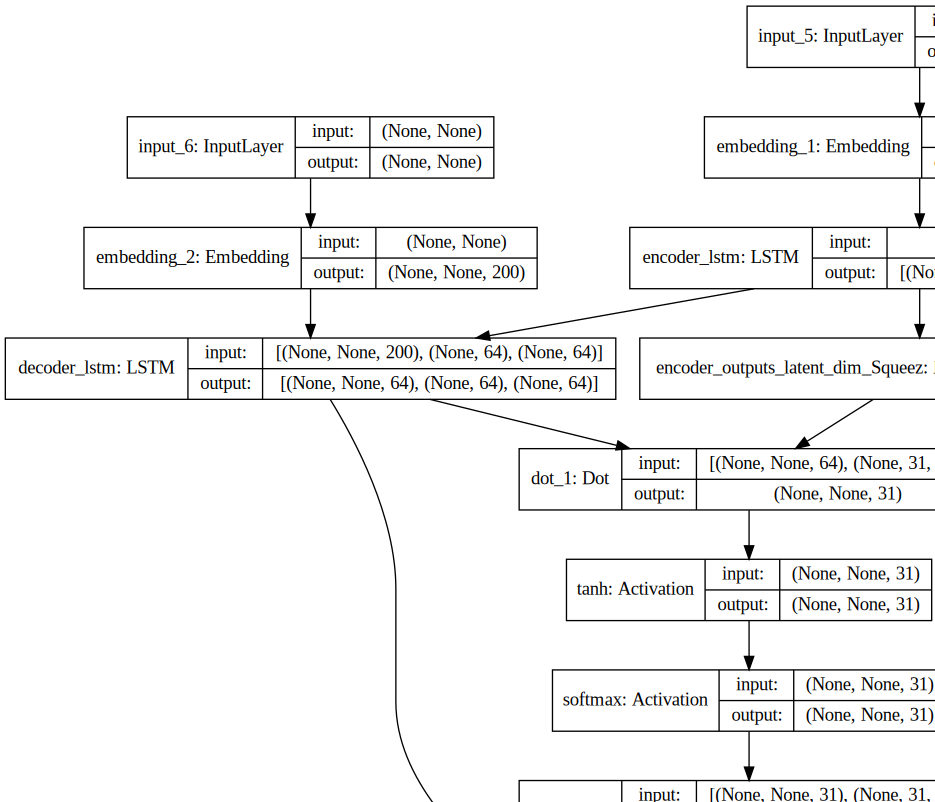

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 31)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 31, 200)      563000      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    378200      input_6[0][0]                    
____________________________________________________________________________________________

In [26]:
############ Encoder
encoder_inputs = Input(shape=(max_en_len,)) # Define an input sequence and process it.
encoder_embed = Embedding(max_en_words, embedding_dim, input_length=max_en_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences = True, return_state=True, dropout = 0.0, recurrent_dropout =0.2,name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]


############ Decoder
decoder_inputs = Input(shape=(None,)) # the shape of decoder_inputs is set to None so it can translate with a single word input, not necessary a sentence input
decoder_embedding = Embedding(max_fr_words, embedding_dim, input_length=None)
decoder_embed = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout = 0.0, recurrent_dropout = 0.2,name='decoder_lstm')
decoder_lstm_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed, initial_state=encoder_states) # 
decoder_states = [decoder_state_h, decoder_state_c] 




############ Attention part
encoder_outputs_transforming = Dense(latent_dim, activation=None, use_bias=False, name='encoder_outputs_latent_dim_Squeez')# Transform encoder outputs to a space which can be aligned with decoder output - mapping into the same space
encoder_outputs_transformed = encoder_outputs_transforming(encoder_outputs) 
attention = Dot(axes = [2,2])([decoder_lstm_output, encoder_outputs_transformed]) # Calculate alignment between decoder and encoder
attention = Activation('tanh', name='tanh')(attention) # it depends on which kind of attention we use
alignment = Activation('softmax', name='softmax')(attention)# Normalize alignment score
context = Dot(axes=[2,1]) ([alignment, encoder_outputs]) # Weighted sum of encoder sequence hidden states = [Query, values]
decoder_combined_context = Concatenate(axis = -1)([context, decoder_lstm_output]) # Concatenate context with decoder output as feature
# decoder_combined_context = Concatenate(axis = -1)([context, decoder_states]) # 这里不是concat hidden state, 然后进行一步一步预测. 然后 作为 decoder 的 initial state, 输出下一个词 + hidden state. 和之前teaching-force一样

############ Prediction part
attention_outputing = Dense(max_fr_words, activation='softmax', name='attention_score', activity_regularizer = regularizers.l1(0.005)) # The activity_regularizer can control the local weights, higher means more likely extract context from local context, rather global
decoder_outputs = attention_outputing(decoder_combined_context) #  This is time distributed dense layer. softmax is apply in the second dimension of the tensor.
# 还能计算一下 encoder_outputs ,decoder_outputs 这两个相似性, 这两个的输出 特征, 如果不相似, 就训练到相似为止 (训练pair为1, 不pair为0)



############ Define and compile
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
model.summary()

### Training & Checkpoint

In [27]:
# epochs=100

# batch_size=32
# epochs = 10
# Compile & run training
# patience=10
BestModel_Name = 's2s_attention_tf_desk'

model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#### Best model selection 
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

batch_size = int( len(data_en) / iteration_per_epoch ) # 200 iteration as one epoch
history = model.fit([data_en, data_fr_in],data_fr_out_cat, verbose = 2, epochs = epochs, batch_size=batch_size, validation_split=val_ratio, callbacks=[earlyStopping, checkpoint])
model.load_weights(BestModel_Name)


# Save model
# model.save('s2s_attention_tf_word_level.h5')

Train on 22325 samples, validate on 1175 samples
Epoch 1/100
 - 70s - loss: 6.4900 - categorical_accuracy: 0.6079 - val_loss: 6.3212 - val_categorical_accuracy: 0.6128
Epoch 2/100
 - 68s - loss: 6.2151 - categorical_accuracy: 0.6308 - val_loss: 6.2245 - val_categorical_accuracy: 0.6290
Epoch 3/100
 - 68s - loss: 6.1198 - categorical_accuracy: 0.6458 - val_loss: 6.1289 - val_categorical_accuracy: 0.6448
Epoch 4/100
 - 67s - loss: 6.0306 - categorical_accuracy: 0.6569 - val_loss: 6.0482 - val_categorical_accuracy: 0.6541
Epoch 5/100
 - 68s - loss: 5.9528 - categorical_accuracy: 0.6657 - val_loss: 5.9833 - val_categorical_accuracy: 0.6604
Epoch 6/100
 - 68s - loss: 5.8837 - categorical_accuracy: 0.6744 - val_loss: 5.9234 - val_categorical_accuracy: 0.6691
Epoch 7/100
 - 67s - loss: 5.8169 - categorical_accuracy: 0.6831 - val_loss: 5.8660 - val_categorical_accuracy: 0.6771
Epoch 8/100
 - 67s - loss: 5.7502 - categorical_accuracy: 0.6923 - val_loss: 5.8099 - val_categorical_accuracy: 0.6851

Epoch 69/100
 - 76s - loss: 4.3254 - categorical_accuracy: 0.9243 - val_loss: 4.9553 - val_categorical_accuracy: 0.8019
Epoch 70/100
 - 79s - loss: 4.3179 - categorical_accuracy: 0.9266 - val_loss: 4.9543 - val_categorical_accuracy: 0.8034
Epoch 71/100
 - 82s - loss: 4.3109 - categorical_accuracy: 0.9283 - val_loss: 4.9588 - val_categorical_accuracy: 0.8028
Epoch 72/100
 - 57s - loss: 4.3039 - categorical_accuracy: 0.9301 - val_loss: 4.9575 - val_categorical_accuracy: 0.8030
Epoch 73/100
 - 47s - loss: 4.2971 - categorical_accuracy: 0.9319 - val_loss: 4.9492 - val_categorical_accuracy: 0.8057
Epoch 74/100
 - 44s - loss: 4.2915 - categorical_accuracy: 0.9332 - val_loss: 4.9505 - val_categorical_accuracy: 0.8040
Epoch 75/100
 - 46s - loss: 4.2841 - categorical_accuracy: 0.9355 - val_loss: 4.9502 - val_categorical_accuracy: 0.8051
Epoch 76/100
 - 45s - loss: 4.2777 - categorical_accuracy: 0.9372 - val_loss: 4.9477 - val_categorical_accuracy: 0.8063
Epoch 77/100
 - 47s - loss: 4.2716 - cat

val_loss loss


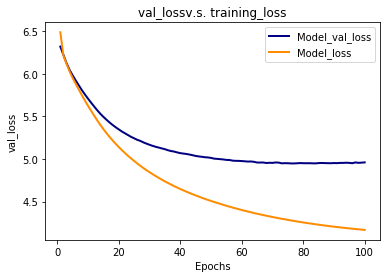

val_categorical_accuracy categorical_accuracy


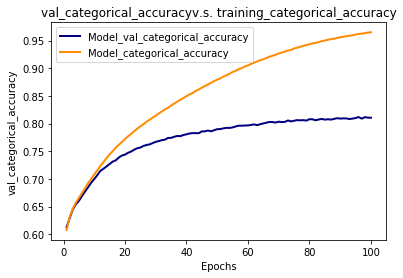

In [28]:
history_plot(history)

## Inference model with Additive attention 
- encoder_inf = Model(encoder_inputs, [encoder_outputs] + encoder_states) # retrieve encoder layers
- decoder_inf = Model([<font color=red> decoder_encoder_outputs </font>, decoder_inputs] + decoder_states_inputs , [ decoder_outputs2] + decoder_states2)
- <img width = '30%' src ='https://machinetalk.org/wp-content/uploads/2019/03/score_eq.png'>

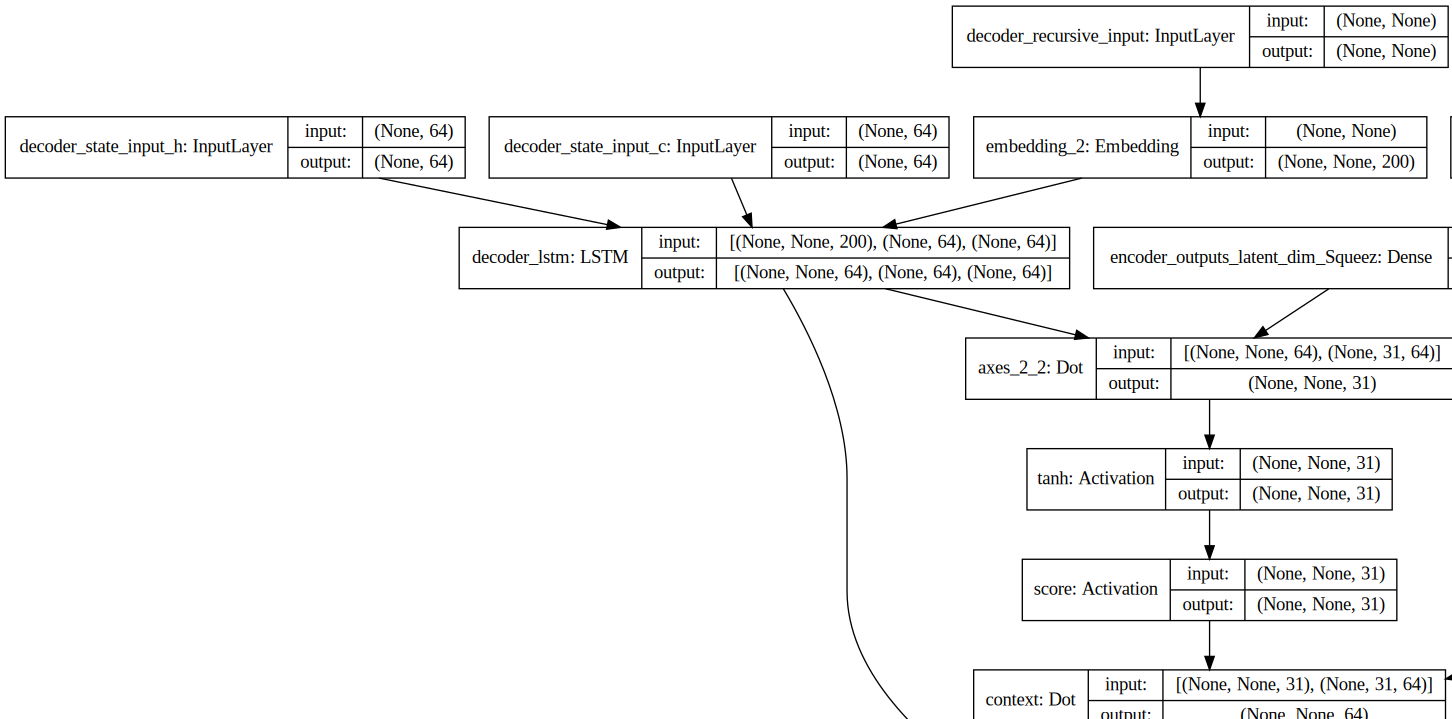

In [29]:
encoder_inf = Model(encoder_inputs, [encoder_outputs] + encoder_states) # retrieve encoder layers
# SVG(model_to_dot(encoder_inf,dpi=70,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


decoder_state_input_h = Input(shape=(latent_dim,), name = "decoder_state_input_h") ## ***************** INPUT 1
decoder_state_input_c = Input(shape=(latent_dim,), name = "decoder_state_input_c") ## ***************** INPUT 2
decoder_inputs = Input(shape=(None,), name = "decoder_recursive_input") ## ***************** 可注释, INPUT 3, 这里的input是单个词, 会通过embedding layer 转换为 1行, max_num_words 列的向量
encoder_outputs = Input(shape=(max_en_len, latent_dim,), name = "encoder_outputs_seq") ## ***************** INPUT 4
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]



# rebuild the decoder branch for inference
decoder_embed = decoder_embedding(decoder_inputs) # 可注释, retrieve decoder embedding layer.
decoder_lstm_output2, state_h2, state_c2  = decoder_lstm(decoder_embed, initial_state = decoder_states_inputs) # retrieve decoder_lstm layer. 最核心的不同在这里, 这里的initial state变了
decoder_states2 = [state_h2, state_c2] 



###################### Attention part - could be substituted by defined layer
# NOTE: compute attention every time stamp. But the parameters in the dense layer have been retrieve
encoder_outputs_transformed = encoder_outputs_transforming(encoder_outputs) # Transform encoder outputs to a space which can be aligned with decoder output 

###### 中间这部分, 没有任何retrieve 参数, 可以直接重新定义
attention = Dot(axes = [2,2], name='axes_2_2')([decoder_lstm_output2, encoder_outputs_transformed]) # Calculate alignment between decoder and encoder
attention = Activation('tanh', name='tanh')(attention) # it depends on which kind of attention we use
alignment = Activation('softmax', name='score')(attention)# Normalize alignment score
context = Dot(axes=[2,1], name='context') ([alignment, encoder_outputs]) # Weighted sum of encoder sequence hidden states = [Query, values]
decoder_combined_context = Concatenate(axis = -1)([context, decoder_lstm_output2]) 
######

decoder_outputs2 = attention_outputing(decoder_combined_context) # predict one word 
######################



# decoder_outputs2 = decoder_dense(decoder_lstm_output2) # 原本是因为需要这个预测, 其实就变相的转换了维度
decoder_inf = Model([encoder_outputs, decoder_inputs] + decoder_states_inputs , [ decoder_outputs2] + decoder_states2)


SVG(model_to_dot(decoder_inf,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

###  Inference result & BLEU Score on Validation set

In [30]:
attention_ref_val, attention_hyp_val, _ = translate_result(val_data, attention=True)

------------------------------
Input sentence:  one of my models from a photo shoot . stacey
Decoded sentence: one of my from a nap .
True sentence: http://twitpic.com/4wsst - one of my models from a photo shoot.  stacey
------------------------------
Input sentence: I m an incredibly happy person with 100 energy . Love to dance amp laugh . . .the only thing that I know .I m one of the most down to earth ppl
Decoded sentence: happy
True sentence: I'm an incredibly happy person with 100% energy. Love to dance &amp; laugh
------------------------------
Input sentence:  Im glad you re a lot happier barakitten lt 3 see yah in july
Decoded sentence: glad
True sentence: Im glad
------------------------------
Input sentence:  I ve got a fairly flat route available . . . the problem is I no longer have a fully functional bike to ride
Decoded sentence: i ve got a random chance to a . .
True sentence: I've got a fairly flat route available... the problem is I no longer have a fully functional bi

Decoded sentence: this week
True sentence: This is my new College project, i just wanted to share it  Hey Mr Bartender - College Project http://bit.ly/Ba3Nf
------------------------------
Input sentence:  jake is signing up for a twitter !
Decoded sentence: is up for twitter !
True sentence: jake is signing up for a twitter!
------------------------------
Input sentence:  I m going to jordan amp jeffs wedding next weekend in atl .
Decoded sentence: i m going to ready to run . .
True sentence: I'm going to jordan &amp; jeffs wedding next weekend in at
------------------------------
Input sentence:  Awww that s nice . You both make a really beautiful couple you balance each other .
Decoded sentence: nice
True sentence: Awww, that's nice.
------------------------------
Input sentence:  cheryl Lucky now I want to teleport
Decoded sentence: lucky now i want to
True sentence: _cheryl Lucky, now I want to teleport
------------------------------
Input sentence: trying to watch lost online very

Decoded sentence: happy
True sentence: grateful
------------------------------
Input sentence: Right folks really must go now have to babysit my nephew in the morning . Another early start . No Twilight time Nare mind . Nightall . X
Decoded sentence: right was
True sentence: Right folks, really must go now; have to babysit my nephew in the morning. Another early start. No Twilight time  Nare mind. Nightall. X
------------------------------
Input sentence:  ok sweet ! and whenever u want I am stuck in bed all weekend
Decoded sentence: ok all and i am stuck in all weekend .
True sentence: t, I am stuck in
------------------------------
Input sentence:  buns awesome ! thank you
Decoded sentence: awesome !
True sentence: awesome!
------------------------------
Input sentence: wish I can go to the Roots pinic
Decoded sentence: wish
True sentence: wish I can go to the Roots pinic
------------------------------
Input sentence:  well i just got home and its not on till tmw at 530p but with com

Decoded sentence: be sick
True sentence: but still gonna be sick
------------------------------
Input sentence: Catching up on 2 weeks of LOST and Grey s ! ! House is quiet again .
Decoded sentence: catching up on and episodes on and warm home . and feels home again . is quiet again
True sentence: Catching up on 2 weeks of LOST and Grey's!!    House is quiet again.
------------------------------
Input sentence:  ur moving to leeds ? ? wut are u doing up there ? work ? ur just a jetsetter . .i wanna move to England too
Decoded sentence: ur to miss
True sentence: ur moving to leeds?? wut are u doing up there? work? ur just a jetsetter..i wanna move to England too
------------------------------
Input sentence: New baby doing well . I will be attempting to do some more quot painting quot this weekend .
Decoded sentence: i ll be
True sentence: doing well.
------------------------------
Input sentence: ah good idea . library seems to work thats why i m not there obviously .
Decoded sentence:

Decoded sentence: gonna head into the now . . now to a friend s birthday s day
True sentence: Gonna head into the shower now...  Going to a friend's birthday party =]
------------------------------
Input sentence:  I know but I m on Rogers and I m pretty sure they don t have the same agreement with Twitter .
Decoded sentence: i m but i m pretty but i m sure but i m sure they don t know the same .
True sentence: I know, but I'm on Rogers and I'm pretty sure they don't have the same agreement with Twitter.
------------------------------
Input sentence: I m not impressed that it almost always rains on Bank Holidays ! ! Stil . . . It s a free day no college
Decoded sentence: re not impressed
True sentence: I'm not impressed that it almost always rains on Bank Holidays !! Stil... It's a free day - no college
------------------------------
Input sentence: Listening to the commentary track on Holiday Inn . Never thought I d see Bing Crosby in black face but the rest of the movie was cute
Deco

Decoded sentence: no to talk just to have to keep the good !
True sentence: no need to thank  we all just have to keep the good thought!
------------------------------
Input sentence: my brother left me for the day now I am here by myself
Decoded sentence: my brother says
True sentence: my brother left me for the day now I am here by myself
------------------------------
Input sentence:  lt follow my girl meagan
Decoded sentence: follow my girl girl
True sentence: &lt;-- follow my girl meaga
------------------------------
Input sentence: Well Done Visteon Belfast 2 years salary paid . Just shows what happens when you stand up for yourself
Decoded sentence: done . just done with what when when we shows when clouds ?
True sentence: Well Done
------------------------------
Input sentence:  Yu th ? trang n y xem recommended by 
Decoded sentence: y by .com live by
True sentence: Yu th? trang nï¿½y xem  http://bit.ly/kMxHk (recommended by )
------------------------------
Input sentence: A si

Decoded sentence: my is my mind my is my heart is . . . is good . life never been away . life never been away .
True sentence: My mind is calm &amp; my heart is happy.. Life is good.  ? Would it be ok if I took your breath away?
------------------------------
Input sentence: god brera why is your plot twist going to everything up i can feel it
Decoded sentence: i feel it
True sentence: **** everything
------------------------------
Input sentence:  That s ok then . . . . I accept the slave role . . . Your wish is my command . . . hahaha
Decoded sentence: . . . . . . i . . . i . wish my back in . . .
True sentence: That's ok then....  I accept the slave role...  Your wish is my command...  hahah
------------------------------
Input sentence: videos will be frozen until actual views catch up to the published artificial view count OOFM was already frozen when we got to it
Decoded sentence: finally be up
True sentence: videos will be frozen until actual views catch up to the published,  ar

Decoded sentence: i need to get though how that is not happen though
True sentence: i need to get tickets though  idk how that is gonna happen
------------------------------
Input sentence:  Translate XMind to your language .
Decoded sentence: to your .
True sentence: Translate XMind to your language.
------------------------------
Input sentence:  real sorry to hear that ma
Decoded sentence: sorry to hear that song
True sentence: l sorry
------------------------------
Input sentence:  I wish you were here NOWWW ! ! ! grrrrrrr
Decoded sentence: i wish you were here ! ! !
True sentence: grrrrrrr
------------------------------
Input sentence:  i love that game xxxx
Decoded sentence: i love that game
True sentence: i love that game
------------------------------
Input sentence:  Will certainly do that .
Decoded sentence: 
True sentence: Will certainly do that.
------------------------------
Input sentence: My computer is SO slooowww this morning . I think it s a sign that I should go home

Decoded sentence: . ! ! ! i need to ! ! we get to get to meet ! ! ! ! ! !
True sentence: o repent!
------------------------------
Input sentence:  ugh but they are so unattractive ! u might as well drink from a regular glass . i really dont like them
Decoded sentence: dont dont like
True sentence: i really dont like them
------------------------------
Input sentence: Make sure u pick up Chrisette Michele s new album EPIPHANY in stores tomorrow May 5th ! You will love it ! Promise ! Congrats 
Decoded sentence: s sure u r excited !
True sentence: Congrats
------------------------------
Input sentence: Chillin following some cool people !
Decoded sentence: cool cool
True sentence: cool
------------------------------
Input sentence:  John more present than ever even online edumedia09
Decoded sentence: john more than even even even even
True sentence: John - more present than ever- even online  #edumedia09
------------------------------
Input sentence:  wow honestly not surprising every tim

True sentence: wishing warped tour came to london canada.....
------------------------------
Input sentence:  have a good day girl ill call you later
Decoded sentence: have a good day
True sentence: good
------------------------------
Input sentence:  she s not coming to detroit only grand rapids in october . . .
Decoded sentence: she s not coming to only . . . .
True sentence: she's not coming to detroit  only grand rapids in october...
------------------------------
Input sentence: Wow the vicodin must have worked I over slept . . . Better get updating BJADAY .com or I will not have a job
Decoded sentence: wow the have i have a job . . .
True sentence: Wow the  vicodin must have worked I over slept... Better get updating BJADAY.com or I will not have a job
------------------------------
Input sentence:  Oooh neat ! Yes SF has such good food . Again so jealous of all you SF people .
Decoded sentence: yes . . really good . so many friends so jealous you all people .
True sentence: Oooh

Decoded sentence: i know how you feel too much too much !
True sentence: I know how you feel.  Takes far too much time out of my life!
------------------------------
Input sentence: Assfuck quot I m sorry quot roll . Okay I gave in . I m such a sucker . 
Decoded sentence: i m such a .
True sentence: Assfuck, &quot;I'm sorry&quot; roll. Okay I gave in.  I'm such
------------------------------
Input sentence:  Emily Young okey
Decoded sentence: young
True sentence: @_Emily_Young_ okey
------------------------------
Input sentence: wakey wakey lemon shakeyyyy ! haha goin 2 schooliooo ! it s raining ! ! ugh ! guess where I WISH I CAN BE RIGHT NOW . . . .CaLiFoRNiA ! ? ? ?
Decoded sentence: haha ! haha !
True sentence: I WISH
------------------------------
Input sentence:  You just noticed this about girls ? Welcome to adulthood !
Decoded sentence: welcome
True sentence: You just noticed this about girls?  Welcome to adulthood!
------------------------------
Input sentence: watching The Big

Decoded sentence: goodnight
True sentence: Mm. Goodnight. Going to play Rock Band 2 'til it's time to watch SNL with Justin Timberlake.
------------------------------
Input sentence: I m SUPER tired and probably could sleep ALL day BUT I work 12 30 to 9 30 today in Tool Rental . . . Oh the Joy ! !
Decoded sentence: super happy
True sentence: I'm SUPER tired
------------------------------
Input sentence: Allergies suck ducks nuts . lt 8 gt 
Decoded sentence: better
True sentence: Allergies suck
------------------------------
Input sentence:  O Looking through my old stuff and found a record from my old band ! Well a band that I was in for about a month . Ever heard of ?
Decoded sentence: looking forward of
True sentence: :O Looking through my old stuff and found a record from my old band! Well,a band that I was in for about a month. Ever heard of  ?
------------------------------
Input sentence:  Fail . If you fancy a pit stop and a cuppa you know where I am ! lol
Decoded sentence: fail

Input sentence: The Matrix Online shuts down next month . . .wow . . .I feel kinda sad about it
Decoded sentence: the about the pool . . . .i kinda sad about it about it about it
True sentence: I feel kinda sad about it
------------------------------
Input sentence: finally some effing internet ! i effin need to update the wifi in SG malls . Idk how i miss dada and craigie . . . . . .
Decoded sentence: i need some new ! i need to update the in . . i . . . i . . . .
True sentence: i miss dada
------------------------------
Input sentence: just got home ! not wanting to read the last chaper of breaking dawn cause i dont want it to beover
Decoded sentence: just got home ! not wanting to read it to read last of it to
True sentence: just got home! not wanting to read the last chaper of breaking dawn cause i dont want it to beover
------------------------------
Input sentence: at the taste a addison w her fav . ppl
Decoded sentence: at the water be tough
True sentence: at the taste a addison

True sentence: poor
------------------------------
Input sentence: Well at least it s not as bad as I thought . Found a new website to watch movies on and I gotta say . . . . . . .it s not bad not bad at all
Decoded sentence: at least not not as bad
True sentence: bad,
------------------------------
Input sentence: nvm lexi s playlist is working its magic
Decoded sentence: s not working
True sentence: its magic
------------------------------
Input sentence:  weird as usual but ok . . . that s why we like it
Decoded sentence: weird
True sentence: that's why we like it
------------------------------
Input sentence: everything is good except that neck shot and Steve s back of the head shots !
Decoded sentence: everything is good except that neck and s back of the back of that !
True sentence: everything is good except that neck shot and Steve's back of the head shots!
------------------------------
Input sentence:  hahah i loveeee him though .
Decoded sentence: i jus though .
True sentenc

Decoded sentence: thanks
True sentence: Thanks for the review,
------------------------------
Input sentence: anyone got JBs live chat vid ? i was school I saw joe hug and tackle nick lol
Decoded sentence: i but i was pretty
True sentence: anyone got JBs live chat vid? i was @ school  I saw joe hug and tackle nick lol
------------------------------
Input sentence: Sleepy time ! Happy Mothers Day to current and future moms around the globe !
Decoded sentence: happy
True sentence: Happy Mothers' Day
------------------------------
Input sentence:  Yeah mine said quot That s a nice picture quot amp gave me the red x ! Hope you get it working soon !
Decoded sentence: e a nice
True sentence: &quot;That's a nice pic
------------------------------
Input sentence:  that includes YOU .
Decoded sentence: that you .
True sentence: that includes YOU.
------------------------------
Input sentence:  OMG ! ! Hahaha ! I thought you were joking about Twittering that hahaha ! ! Awesome good times were ha

Decoded sentence: thanks !
True sentence: Thanks
------------------------------
Input sentence:  MY FAV . SONG IS UH . . .honestly its rude for u to make us choose . lol I love em all !
Decoded sentence: my fav .
True sentence: MY FAV. SONG IS UH...honestly, its rude for u to make us choose.  lol I love 'em all!
------------------------------
Input sentence:  it could be a bad idea Hayley
Decoded sentence: bad idea
True sentence: bad idea,
------------------------------
Input sentence:  Thanks about the ponytail . I dreamt last night that I shaved my head . . . ? ? ? I guess it s a bigger deal than I thought .
Decoded sentence: thanks
True sentence: Thanks
------------------------------
Input sentence: oh yah her and angel came and harrassed me and tried to break in my house ! ! lol Burgen
Decoded sentence: oh
True sentence: harrassed me and tried to break in my house!!
------------------------------
Input sentence:  i m trying to figure that out right now
Decoded sentence: i m trying 

Decoded sentence: will too .
True sentence: will deplurk too. buhbyeee  http://plurk.com/p/rp3ir
------------------------------
Input sentence:  thats what i was thinking but the only time it s gonna be on is 1 am !
Decoded sentence: thats what i was going but the only time it s been on is not on the !
True sentence: thats what i was thinking but the only time it's gonna be on is 1 am!
------------------------------
Input sentence:  was there yet another semi final tonight ?
Decoded sentence: there s there s crazy tonight ?
True sentence: was there yet another semi final tonight?
------------------------------
Input sentence:  No it s people you are recommending that others follow like followfriday only with pics !
Decoded sentence: no people s people you are that only you were with people only you .
True sentence: No, it's people you are recommending that others follow, like followfriday, only with pics!
------------------------------
Input sentence: moving back home today . pro obnox

Decoded sentence: you are going to your baby ?
True sentence: hate
------------------------------
Input sentence:  how old is jonathan jr ? I ve got four cockatiels they re two years now
Decoded sentence: how is
True sentence: how old is jonathan jr? I've got four cockatiels, they're two years now
------------------------------
Input sentence:  they re getting back together for one more album . . or so i heard .
Decoded sentence: they re getting
True sentence: they're getting back together for one more album.. or so i heard.
------------------------------
Input sentence: can t gauge the time of day in my office anymore . . . It s worse than a friggin casino in here . . . no waitresses smoking or booze
Decoded sentence: can t in
True sentence: worse th
------------------------------
Input sentence: I ran over a turtle .
Decoded sentence: i ran in a .
True sentence: I ran over a turtle.
------------------------------
Input sentence: Out with Audrey
Decoded sentence: out with
True sentenc

Decoded sentence: i just had from .
True sentence: i just had pasta  from pizzahut.
------------------------------
Input sentence:  I m soo jealous right now ! !
Decoded sentence: i m jealous
True sentence: I'm soo jealous right now!!
------------------------------
Input sentence:  serio barroca ? ? parabens ! ! ! ! ! ! ! May the 4th be with you !
Decoded sentence: ! ! ! ! ! ! ! ! ! ! ! ! !
True sentence: May
------------------------------
Input sentence: California s budget deficit now at 24 .3 billion means big problems and lots of cuts including 220 of our state parks
Decoded sentence: problems
True sentence: problems
------------------------------
Input sentence:  Pfft there you go with the logic again !
Decoded sentence: there you go with the again again
True sentence: Pfft, there you go with the logic again!
------------------------------
Input sentence: i love his nose kisses
Decoded sentence: i love his
True sentence: i love his nose kisses
------------------------------
Input 

------------------------------
Input sentence: Printing from Opera gives me a much better result but printing to PDF it names it stdin .pdf always gotta compromise
Decoded sentence: me much better
True sentence: gives me a much better result (b
------------------------------
Input sentence: working allllllllll weekend . .how thrilling . .and i have to say bye to goshy on sunday cause she is leaving for poland for 3 months
Decoded sentence: for weekend . . . for 3 to say bye to for sunday instead . i end for for sunday
True sentence: working allllllllll weekend..how thrilling..
------------------------------
Input sentence: Wishing all MOMs a very Happy Mother s Day ! !
Decoded sentence: happy
True sentence: a very Happy Mother's Day!!
------------------------------
Input sentence:  just took the Terminator trilogy D but what I need is actually TV series and I still can t find anything tempting
Decoded sentence: i still can t find anything but i still still can still can find anything i

Decoded sentence: thanks !
True sentence: thanks
------------------------------
Input sentence:  You just want to go ? ? I know the feeling . . . I m ready to head back to the mountains I won t go back till July
Decoded sentence: just want to go ? i know the feeling . . . i m not back back to the back till i m just back back to the back
True sentence: You just want to go?? I know the feeling...  I'm ready to head back to the mountains, I won't go back till July
------------------------------
Input sentence: paramore songs ? one of the best ! currently listening to quot emergency quot 
Decoded sentence: quot one of the best quot quot quot quot
True sentence: one of the best!
------------------------------
Input sentence: Just discovered a painful sunburn on my right sholder hopefully it just turns into a tan !
Decoded sentence: just a little man on my mind just a little just arrived !
True sentence: Just discovered a painful sunburn on my right sholder  hopefully it just turns into a ta

Input sentence:  good morning rob !
Decoded sentence: good morning !
True sentence: good
------------------------------
Input sentence:  the drs . in beverly hills . . .doctor s scare out of me
Decoded sentence: .
True sentence: doctor's scare **** out of me
------------------------------
Input sentence:  oh darn i m not in london
Decoded sentence: 
True sentence: darn
------------------------------
Input sentence:  I miss my babyyy
Decoded sentence: miss
True sentence: miss
------------------------------
Input sentence:  why you come down in sept ? that s when i start school
Decoded sentence: why you come down in ? that s when i start
True sentence: why you come down in sept? that's when i start school
------------------------------
Input sentence: just called Toyota . Car won t be ready til 5 .
Decoded sentence: just called . . . won t be thinking of
True sentence: won't be ready til 5.
------------------------------
Input sentence: About to go eat breakfast at jay jays cafe with my 

Decoded sentence: it s raining here in but it s not . so just not . it s not
True sentence: Yup, sometimes kc it's raining here in Pque but in Las Pinas it's not. So just wondering.
------------------------------
Input sentence:  You realllllllllly just said that didn t you ?
Decoded sentence: you just said you didn t you ?
True sentence: You realllllllllly just said that didn't you?
------------------------------
Input sentence: Boy is all graduated ! So proud of him !
Decoded sentence: proud
True sentence: !  So proud of him!
------------------------------
Input sentence: blerg you Monday why must you always come . Decent weekend new glasses hair color and got carded at Gamestop awesome ego boost
Decoded sentence: very
True sentence: blerg, **** you Monday, why must you always come.  Decent weekend, new glasses, hair color and got carded at Gamestop = awesome ego boost
------------------------------
Input sentence: Aaaah did you see Prez Obama holding hands with his wifey ? Soooo rom

# Each BLEU Score on test set

In [31]:
attention_ref_test, attention_hyp_test, attention_translation = translate_result(test_data, attention=True)

------------------------------
Input sentence:  oh wait i messed up my own messed up lyrics that should be quot don t concretize it quot 
Decoded sentence: oh wait i can find my own show up that should be quot
True sentence: messed
------------------------------
Input sentence: Funtime was not a lot of fun ! ! But finally done with it
Decoded sentence: not done
True sentence: fun!!
------------------------------
Input sentence:  ohh shardup ! hehe . hes hot lah gotta admeeet ! bleh .
Decoded sentence: ohh !
True sentence: ohh shardup! hehe. hes hot lah, gotta admeeet! bleh.
------------------------------
Input sentence:  . .dat dude look crazy w dat hair on his face lmao . .stop it ! ! . .the old wrestlers went to TNA thanks Vince . .these dudes are clowns lol
Decoded sentence: .
True sentence: .these dudes are clowns
------------------------------
Input sentence: is gonna go yoga ing with a jumbo cup of coffee ! ! ! ! ! Thinking about it is making her very happy ! !
Decoded sentence: 

True sentence: How can i vote, it wont let me, says they closed the votes in her category  i wanna vote
------------------------------
Input sentence:  why hello there How s life on the other side of the screen ?
Decoded sentence: why s your the on the side of the side of the site ?
True sentence: why, hello there  How's life on the other side of the screen?
------------------------------
Input sentence:  Yeah but it doesn t sound indie enough i need2learn some other tunes and then pick up mo style 1hour ! I ll c u then 
Decoded sentence: but it doesn t
True sentence: Yeah but it doesn't sound indie enough  i need2learn some other tunes and then pick up mo style =] 1hour! I'll c u then ;)
------------------------------
Input sentence: Happy Mothers day to all mums
Decoded sentence: happy mothers day to all
True sentence: Happy Mothers day
------------------------------
Input sentence:  this time there is a theme and it is quot purple quot 
Decoded sentence: this time is a quot and it i

Decoded sentence: sucks
True sentence: sucks for you
------------------------------
Input sentence: last day of school and last concert of my life . . wow . . can you say emotional ? im really gonna miss mhs . . had graduation practice today . .
Decoded sentence: last day of my last and last of my . . . can be really miss . . . . can be back . . . can t be back .
True sentence: can you say emotional? im really gonna miss mh
------------------------------
Input sentence:  Dun wanna travel all the way there for lunch now . But yeah i have been there . Nice place . Missing Shan e Punjab though . . .
Decoded sentence: nice
True sentence: Nice place. Missing Shan-e-Punjab though...
------------------------------
Input sentence:  You Got Twitter ! Yayy 
Decoded sentence: you got twitter !
True sentence: Yayy
------------------------------
Input sentence: My computer dies soon its so much virus on it but my virus scanner cant find it S
Decoded sentence: my second it s so much on it but my can

Decoded sentence: fun
True sentence: fun
------------------------------
Input sentence: is feeling so bored . . . i miss school time
Decoded sentence: . i miss
True sentence: is feeling so bored..
------------------------------
Input sentence: This is sad
Decoded sentence: sad
True sentence: This is sad
------------------------------
Input sentence:  I envy everyone on AOTS . . .
Decoded sentence: i may . .
True sentence: I envy
------------------------------
Input sentence: Goooooodmorning
Decoded sentence: 
True sentence: Goooooodmorning
------------------------------
Input sentence: Finally back from the stupid holiday ! Missing the fit bar men though
Decoded sentence: finally back from the face ! haven t catch the street though .
True sentence: stupid holiday !
------------------------------
Input sentence: I just single handedly killed 4 flies and a crane fly with my hairbrush ! ! I m gonna go disinfect it now . . .but bugs beware ! !
Decoded sentence: i just just got another ! ! 

Decoded sentence: really really really ready !
True sentence: is really really ready!
------------------------------
Input sentence:  mejer I couldn t remember what all the different cords meant . I lost half of them leaving the graduation anyway .
Decoded sentence: i couldn t what
True sentence: couldn't remember wh
------------------------------
Input sentence: I loved johnny carson now I m going to hate seeing jay leno go via that s what I was waiting for someone to say !
Decoded sentence: i m going to hate
True sentence: I loved johnny carson now I'm going to hate seeing jay leno go  (via ) that's what I was waiting for someone to say!
------------------------------
Input sentence: Phone went in the toilet The truth is I m surprised is hasn t happen sooner !
Decoded sentence: is i t this is
True sentence: Phone went in the toilet   The truth is I'm surprised is hasn't happen sooner!
------------------------------
Input sentence: Math class ugh . Rather be a class act . quiz gotta a

Decoded sentence: ? ! ? ? ? ?
True sentence: Whaaaat?!?!?  When did that happen?
------------------------------
Input sentence: last day of school so sad
Decoded sentence: sad
True sentence: last day of school  so sad
------------------------------
Input sentence:  A mocha at 12 30am ? My you re brave
Decoded sentence: a at 12 you re you re
True sentence: brave
------------------------------
Input sentence: Had a little fight with My Best Friend What should I Do ? ! ?
Decoded sentence: had a little with my best friend with what i do ? ? ?
True sentence: Had a little fight with My Best Friend   What should I Do?!?
------------------------------
Input sentence:  i think i have mine in hangers in the closet
Decoded sentence: i think i have in in in in
True sentence: i think i have mine in hangers in the closet
------------------------------
Input sentence:  Yes thanks its been great . Soooooo not looking forward to Monday
Decoded sentence: thanks
True sentence: Yes thanks, its been great.

Decoded sentence: bank holiday here .
True sentence: Bank holiday  Off to the station now. Catch you all later.
------------------------------
Input sentence: doing some DIY I m dying mg clothes black again . . .save some money
Decoded sentence: some i m dying for some black again . some money ?
True sentence: save
------------------------------
Input sentence: Two words hot pockets . Most delcious food ever created
Decoded sentence: 
True sentence: delcious
------------------------------
Input sentence:  20somethin single
Decoded sentence: 
True sentence: :20somethin' single
------------------------------
Input sentence:  I wana be there num 1 fan sharsies ? ? ! ! !
Decoded sentence: i be there ! ! ! !
True sentence: I wana be there num 1 fan  sharsies??!!!
------------------------------
Input sentence: sooo long twitters ! I m off to Cuba
Decoded sentence: sooo off to
True sentence: sooo long twitters! I'm off to Cuba
------------------------------
Input sentence:  you and I apparent

Decoded sentence: is waiting for the start final to start . . lt
True sentence: goodtimes.
------------------------------
Input sentence: going to bed
Decoded sentence: going to bed
True sentence: going to bed
------------------------------
Input sentence:  yes and ily
Decoded sentence: yes and
True sentence: : yes  and ily
------------------------------
Input sentence: On the way to home
Decoded sentence: on the way to home
True sentence: On the way to home
------------------------------
Input sentence:  Ya the weather has been super weird here . It looked like it was gonna rain today but of course it didn t darnitt 
Decoded sentence: it was fun
True sentence: Ya, the weather has been super weird here.
------------------------------
Input sentence: Heyya guys ! does anyone know how to give formulas to create a sudoku ? Please help
Decoded sentence: help
True sentence: Heyya guys! does anyone know how to give formulas to create a sudoku? Please help
------------------------------
Input

True sentence: bummed
------------------------------
Input sentence:  awww . rusks are good for tummy aches though p try fennel or camomile tea works . or obviously try . . .
Decoded sentence: good
True sentence: good for tummy aches
------------------------------
Input sentence: is home whoott . Happy Mother s Day Madre
Decoded sentence: happy
True sentence: Happy
------------------------------
Input sentence:  i did a couple hours ago . . .ive got sun burn and its really uncomfortable
Decoded sentence: i did a couple ago . .
True sentence: uncomfortable
------------------------------
Input sentence:  meeee too . i am listening to sad music and missing you . ps 
Decoded sentence: sad
True sentence: missing
------------------------------
Input sentence: Frustrated with copying 13Gigs across USB 1 .1 .Stupid old servers
Decoded sentence: frustrated with four old old old
True sentence: Frustrated
------------------------------
Input sentence: chillin after a LOOOONNNGGG day of basketball

Decoded sentence: i would like u guys to the most couple words to beat the best to see the best to be done but to see the most u done
True sentence: i got luck for u guys to beat la!!
------------------------------
Input sentence:  I love mine too . happy mother s day to your mom John Taylor . much love to you too .
Decoded sentence: love
True sentence: I love mine, too . happy motherï¿½s day to your mom , John Taylor  . much love to you, too
------------------------------
Input sentence:  Yeah I know ! Thanks so much
Decoded sentence: thanks so much
True sentence: Thanks
------------------------------
Input sentence: So much for buying that awesome new phone from sony ericsson I am now Berry d like everyone else . . .
Decoded sentence: so much for
True sentence: awesome new phone from sony ericsson  - I am now Berry'd like
------------------------------
Input sentence:  ehhehehe thanks
Decoded sentence: thanks
True sentence: thanks
------------------------------
Input sentence: It s r

Decoded sentence: in a for less days . . . . for less . . . . need study for less . . .
True sentence: no funny time..
------------------------------
Input sentence: We got JoJo in for free and free drinks for Mom ! My kind of night
Decoded sentence: we got for free and free for dinner !
True sentence: My kind of night
------------------------------
Input sentence:  If it s any consolation you re definitely one of the hottest GG s IMHO
Decoded sentence: if it s you re not following one of the
True sentence: you're definitely one of the hottest
------------------------------
Input sentence:  HAHA I took the quiz on fb and missed the mcfly one
Decoded sentence: y missed the
True sentence: HAHA I took the quiz on fb and missed the mcfly one
------------------------------
Input sentence: oh yeah the grill is out . . .its bbq tonight at the house
Decoded sentence: oh yeah the is out . . . house at the house
True sentence: oh yeah the grill is out...its bbq tonight at the house
-------------

Decoded sentence: hello i am cool all the new comes out ! got the new moon trailer on the girls i all the !
True sentence: ! good luck
------------------------------
Input sentence:  Bailon talk with your HIPS
Decoded sentence: talk with your
True sentence: talk with your HIPS
------------------------------
Input sentence: So cold in here ! getting the chill
Decoded sentence: so cold in here .
True sentence: So cold in here!  getting the chill
------------------------------
Input sentence:  it s not the 10 .5 so much as the A Sugar and B Taste . . . lord that ll put ya down and not in the fun way
Decoded sentence: 
True sentence: not in the fun way
------------------------------
Input sentence: aah i m tired . haven t chilled a minute today !
Decoded sentence: i m tired .
True sentence: aah, i'm tired.
------------------------------
Input sentence: still hoping for a job . . . but now i have strep so looks like i wont be looking around places for the next couple of days
Decoded sentenc

Decoded sentence: you better come by the time i ll take 10 or the . . . 1 year ! ! ! !
True sentence: You better come here by the time I count to 10 or else. 1, 2, 3,  BAM!!!!!
------------------------------
Input sentence: macs ftw btw . .just because . . and if you re still using the grandaddy pc s you lost at life . . jp . .not really . . 
Decoded sentence: at . . . .just if you re still using the past . . . . look at the past you . . . .
True sentence: macs ftw btw. .just because.. and if you're still using the grandaddy pc's you lost at life.. jp  (..not really..)
------------------------------
Input sentence: Eat Sleep Draw ! Part of my Neuroanatomy take home test . After this I m . . . Part of my Neuro . . 
Decoded sentence: my class !
True sentence: Eat Sleep Draw!: Part of my Neuroanatomy take-home test.  After this, Iï¿½m...: Part of my Neuro.. http://bit.ly/fXs3L
------------------------------
Input sentence:  When balancing a chair on my chin in the sixth form common room g

Decoded sentence: just got not just not that into . . it . loved it
True sentence: Loved it.
------------------------------
Input sentence: How I wish I get at least 2 days off in a row . 1 day off is not enough to rest . 3 days on 1 day off 4 days on 1 day off . . .Ugh ! ! !
Decoded sentence: i wish i get at 2 days off a week off 2 days off 3 times off 3 times off 3 times off 3 times off 3 times off .
True sentence: not enough to rest.
------------------------------
Input sentence:  No mine looks the same .
Decoded sentence: no mine . looks the same
True sentence: No mine looks the same.
------------------------------
Input sentence:  omg evie . we have to do our plan for hot 30 tomorrow night
Decoded sentence: omg . we have to do our for 30 for 30 days
True sentence: omg evie. we have to do our plan for hot 30 tomorrow night
------------------------------
Input sentence:  Very early and I am actually just going back for a little more rest . . . . . talk with you a little later . . . 

Decoded sentence: the sun is out here out the mums happy mothers day to all the out there
True sentence: Happy
------------------------------
Input sentence: Am trying to get through the pilot of the first season of friday night lights . Oh gosh Pass the tissue . . .
Decoded sentence: gosh the get through the of the first of the last night of friday . . . the sun .
True sentence: Am trying to get through the pilot of the first season of friday night lights. Oh gosh  Pass the tissue...
------------------------------
Input sentence:  can t wait for it . i love your scripts . honestly you should have a future career as a script writer Stock Twits
Decoded sentence: 
True sentence: love
------------------------------
Input sentence:  awesome ! cheers man ! don t know if i ll have much money left after todays shopping spree though !
Decoded sentence: !
True sentence: awesome!
------------------------------
Input sentence:  Lettuce amp spinach does best in cool weather . . I live in florida .

Decoded sentence: is too much for me but i dont it too much to stop it
True sentence: like
------------------------------
Input sentence:  alright don t want you to overdue it now . LOL you are funny nite nite
Decoded sentence: o
True sentence: funny
------------------------------
Input sentence:  Hahahah I will be using that saying from now on !
Decoded sentence: i will be on that dvd from !
True sentence: Hahahah,
------------------------------
Input sentence:  Thank you . I needed that
Decoded sentence: thank
True sentence: Thank you.
------------------------------
Input sentence:  yeah big chill here too good foods good music great weather ! have a cool day Bro !
Decoded sentence: good
True sentence: o good foods, good music, great weather!
------------------------------
Input sentence: is also wishing these two lovely mothers amp a very special Mother s Day ! ! ! enjoy !
Decoded sentence: enjoy !
True sentence: ay!!!
------------------------------
Input sentence:  i love them too 

Decoded sentence: now its going to the same time well well well
True sentence: now Eating and meeting at the same time sigh well well I want to start work out too but will have to wait move to my new house
------------------------------
Input sentence: is up slightly later than planned . . . gunna get this essay done 2day ! !
Decoded sentence: is up now ! !
True sentence: is up, slightly later than planned... gunna get this essay done 2day!!
------------------------------
Input sentence:  what happened to all your sexy quotes ?
Decoded sentence: what your sexy your sexy ?
True sentence: what happened to all your sexy quotes?
------------------------------
Input sentence: and now i smell pancakes . . .or maybe toast . . . or something delicious . but no one is at my place cooking
Decoded sentence: .
True sentence: and now i smell pancakes...or maybe toast... or something delicious. but no one is at my place cooking
------------------------------
Input sentence: Living down Alki without 

Decoded sentence: tonight tonight tonight tonight tonight tonight
True sentence: Last Tonight Show with Jay Leno Tonight!
------------------------------
Input sentence: uploading all my bamboozle pictures of facebook
Decoded sentence: goodnight
True sentence: uploading all my bamboozle pictures of facebook
------------------------------
Input sentence: I do amazing at beer pong with my brother
Decoded sentence: i do at my with my brother at my
True sentence: I do amazing at
------------------------------
Input sentence: Cleaning the house
Decoded sentence: cleaning the house
True sentence: Cleaning the house
------------------------------
Input sentence:  dbl booooooo for being sick flippin blows ! . . . bahaha i kno i dont have many friends on here either . i feel so lame haha
Decoded sentence: i feel so many . . i dont have yet i dont have many friends on yet i dont feel so many
True sentence: i feel so lame
------------------------------
Input sentence: shopping in Keswick
Decoded s

Decoded sentence: here goes my twitter from twitter from my . . long hair comes . . .
True sentence: Cheers, long live..
------------------------------
Input sentence:  was jus so excited t c ur name
Decoded sentence: t excited
True sentence: excited
------------------------------
Input sentence: Watching Dr . Phil s special on same marriage . It s sad how ignorant some people are
Decoded sentence: watching dr s special ? . it s sad how sad how s how sad about ?
True sentence: It's sad
------------------------------
Input sentence: niggas got they eyes on me and i aint talkin bout da BM when i say i got 745 on me
Decoded sentence: got got got on a call u talkin bout got got got on got got got on
True sentence: niggas got they eyes on me and i aint talkin bout da BM when i say i got 745 on me
------------------------------
Input sentence: Everyone s talking about the goodies at BEA09 . I wanna be there .
Decoded sentence: 
True sentence: I wanna be there.
------------------------------


Decoded sentence: on u all the will help me
True sentence: lazzzy ****!
------------------------------
Input sentence:  hahahahaha I have a day off
Decoded sentence: have a day off
True sentence: hahahahaha,
------------------------------
Input sentence: now there s a fly in my room
Decoded sentence: 
True sentence: now there's a fly in my room
------------------------------
Input sentence:  eww What r u doing atm ?
Decoded sentence: r u doing ?
True sentence: eww  What r u doing atm?
------------------------------
Input sentence: working ! I am so ready to go .
Decoded sentence: 
True sentence: I am so ready to go.
------------------------------
Input sentence:  pshh . Thanks .
Decoded sentence: thanks .
True sentence: Thanks.
------------------------------
Input sentence:  small ? we cant choose ?
Decoded sentence: ?
True sentence: small? we cant choose?
------------------------------
Input sentence: Okay people my fones charged
Decoded sentence: 
True sentence: Okay people my fones 

Decoded sentence: i would have to the on the . . . would the the of the instead of the office
True sentence: I would have to agree on the Bacon Cupcake... Would rather drive 2 the shop instead of 2 the office
------------------------------
Input sentence: going to bed soon
Decoded sentence: going to bed soon
True sentence: going to bed soon
------------------------------
Input sentence:  No wonder we re married . Night love . lt 3
Decoded sentence: love
True sentence: Night love.
------------------------------
Input sentence: Ben I Love yahh babe lt 333 ! i miss you hope to see u tomorrow Mommy i love you tomorrow happy mothers day ! happy mother day to all moms !
Decoded sentence: happy
True sentence: Ben I Love yahh babe &lt;333! i miss you hope to see u tomorrow  Mommy i love  you tomorrow happy mothers day! happy mother day to all mo
------------------------------
Input sentence:  I know ! It was drizzling all the way to work ! Hope it warms up this weekend . . . .
Decoded sentence

Decoded sentence: i was just too sorry
True sentence: I was, I took your advice and it was most enjoyable  I am too small to be out alone or I would've just come over lol
------------------------------
Input sentence:  it really made my night . infact it made my weekend ! well done .
Decoded sentence: it made my made it made it made well . well . well done
True sentence: well done.
------------------------------
Input sentence:  let s hope so
Decoded sentence: hope
True sentence: let's hope so
------------------------------
Input sentence: Happy Mothers Day ! . .ok . .seriously . .good night
Decoded sentence: happy
True sentence: Happy
------------------------------
Input sentence: My grandpa just told me he feels useless . I said quot Papa you re in your 80 s you just do what makes you happy quot somehow I doubt it helped
Decoded sentence: my just told me i said quot you re just in your blog and i can t do your blog s just your mobile and
True sentence: My grandpa just told me he feel

Decoded sentence: aww bless her .
True sentence: bless her. She's one of my faves
------------------------------
Input sentence:  I don t want to ! ! ! ! I am going to cry all the way home ! ! !
Decoded sentence: i don t want to ! ! ! ! i am going to all the way all over ! !
True sentence: !!! I am going to cry all the way home!!!
------------------------------
Input sentence:  yeah thought it was awesome glad to see some characters like Gambit brought back into the fold
Decoded sentence: awesome
True sentence: yeah thought it was awesome - glad to see some characters like Gambit brought back into the fold
------------------------------
Input sentence:  we found a ride
Decoded sentence: we found a ride
True sentence: we found a ride
------------------------------
Input sentence:  I m not part of that generation unfortunately . This is really good though
Decoded sentence: good
True sentence: I'm not part of that generation unfortunately.  This is really good though
---------------------

Decoded sentence: is anyone wanna see up ? ? ? ? ? ?
True sentence: milan is retardeddddddd, anyone wanna see my paint pic of him ???
------------------------------
Input sentence: toy story 3 ! june 2010 . i can t wait that long .
Decoded sentence: can t wait
True sentence: toy story 3! june 2010. i can't wait that long.
------------------------------
Input sentence: Just got home no rosie surprise of smiles hugs amp kisses waiting for me .
Decoded sentence: just got home amp i am waiting for amp amp nobody
True sentence: Just got home, no rosie surprise of smiles hugs &amp; kisses waiting for
------------------------------
Input sentence: just had a falling out with nick
Decoded sentence: just had a out out his out
True sentence: falling out with nick
------------------------------
Input sentence: work Yay !
Decoded sentence: yay !
True sentence: Yay
------------------------------
Input sentence: At work surprisingly happy all things considered ahhhh loveliness
Decoded sentence: happ

Decoded sentence: thanks !
True sentence: a good
------------------------------
Input sentence:  I m so tired I think imma go to bed
Decoded sentence: i m so tired
True sentence: tired
------------------------------
Input sentence: watching quot Say Anything quot great 80s movies and the starting point of my love for John Cusack !
Decoded sentence: love
True sentence: g&quot;
------------------------------
Input sentence: pretty tired after a nice full day .
Decoded sentence: pretty tired
True sentence: pretty tired after a nice full day.
------------------------------
Input sentence:  i hate it
Decoded sentence: i hate it
True sentence: i hate it
------------------------------
Input sentence: had a good time at prom . They played Jonas Brothers for me . pretty much made my night . . .
Decoded sentence: had a good time at me .
True sentence: good time
------------------------------
Input sentence: Ahhh My Satz blend didn t save
Decoded sentence: my didn t save my
True sentence: Ahhh My

Decoded sentence: quot s quot mine . it s quot i live at any . quot d .
True sentence: &quot;Her's before mine&quot; hon. It's one of few rules I do NOT break, under ANY circum
------------------------------
Input sentence: TGIF Resto here at home is dayuummm expensive !
Decoded sentence: here is expensive !
True sentence: expensive!
------------------------------
Input sentence: 2 days after all4web . . .i m still tired
Decoded sentence: still tired
True sentence: tired
------------------------------
Input sentence:  my daughters kindergarden !
Decoded sentence: my !
True sentence: http://slingalink.com/eVicE1 my daughters kindergarden  !
------------------------------
Input sentence: Trying to get out to enjoy the weather amp train a little . . . Some minor beer tasting activity took place yesterday with etc
Decoded sentence: have to get out easy to a little . . .
True sentence: enjoy
------------------------------
Input sentence: Another friend knocked up . Pretty soon everyone will

Decoded sentence: i m goin to go
True sentence: Get my **** out the door and go to work   I'm goin, I'm goin!!!!
------------------------------
Input sentence: Listening to music Texting . umm Msn lol . bit bored . lol . Garth Brooks wooo i love him hehe . lt 3
Decoded sentence: . lol . i love him . lol . lol . i love him
True sentence: i love him
------------------------------
Input sentence: lots of decisions to make . . .i need an assistant cook nanny chauffer lol lol but 4 real !
Decoded sentence: u though . .i need them . .i need an lol
True sentence: lots of decisions to make...i need an assistant/cook/nanny/chauffer lol lol but 4 real!
------------------------------
Input sentence: Is . . .Sayin Happy Mother s Day 2 Everyone ! ! ! ! !
Decoded sentence: happy
True sentence: Happy
------------------------------
Input sentence:  was on the list i paid 5 to get in but if your under 21 you cant go in and out but it was gettin so hot so we went outside
Decoded sentence: but it was so 

Decoded sentence: are u on doing their days ? what s doing last night ? that s last night ?
True sentence: reasonable
------------------------------
Input sentence: GAWD ! . If only that dream actually happened last night . . . .
Decoded sentence: . . if only that actually actually it actually . . . . .
True sentence: GAWD!. If only that dream actually happened last night....
------------------------------
Input sentence:  my tvs not working i wanna watch vhits 
Decoded sentence: 
True sentence: tvs not working
------------------------------
Input sentence:  Ahhh I slept through the game . I m gonna try my best to watch tomorrow though . I hope we play Army .
Decoded sentence: i hope
True sentence: Ahhh, I slept through the game.  I'm gonna try my best to watch tomorrow though. I hope we play Army.
------------------------------
Input sentence: In math class now about to shoot myself because its so boring .
Decoded sentence: boring
True sentence: boring.
------------------------------


True sentence: best.
------------------------------
Input sentence:  Ha fun ! I think I ll rewatch parts of season 5 today . . .in preparation for 2morrow night !
Decoded sentence: fun !
True sentence: fun!
------------------------------
Input sentence: Listening to Music Box . When Mariah could still sing
Decoded sentence: listening to music when when could make me
True sentence: Listening to Music Box.  When Mariah could still sing
------------------------------
Input sentence: Clive it s my birthday pat me 
Decoded sentence: it s me birthday me
True sentence: Clive it's my birthday pat me
------------------------------
Input sentence: I m at church now . .bout to od on my smoothie bc it might be melted when I come back
Decoded sentence: i m at church . i want to on my mom . i want some check it
True sentence: I'm at church now..bout to od on my smoothie bc it might be melted when I come back
------------------------------
Input sentence:  um that s really scary please be safe ! Btw 

Decoded sentence: i want him to call
True sentence: I want him to call
------------------------------
Input sentence:  DArLiNE ! ! miss you
Decoded sentence: miss
True sentence: miss you
------------------------------
Input sentence:  nk Wouldn t call that cool or dangerous . Reckon it fits into the stupid category
Decoded sentence: stupid
True sentence: Wouldn't call that cool or dangerous. Reckon it fits into the stupid category
------------------------------
Input sentence: i wanna vote for Miley Cyrus for the mtv movie awards . .but i don t know where i could somebody could send me a link ? thaank you lt 3
Decoded sentence: i wanna watch for following for you ! i wanna me i mean you will me ? i mean you will me ? i mean you could me
True sentence: thaank
------------------------------
Input sentence: Haven t a clue about this twitter !
Decoded sentence: haven t a
True sentence: Haven't a clue about this twitter!
------------------------------
Input sentence: The sun is shining brig

Decoded sentence: . . or so i get to get on today . . or so we need to get on this few next year . . . or so .
True sentence: Realizing that I don't have school today... or tomorrow... or for the next few months.  I really need to get on those job applications!
------------------------------
Input sentence:  Hey twit ! Just watched poor Holly on Britains Got Talent poor thing ! ! People are so mean she only a 10 year old little girl !
Decoded sentence: poor thing !
True sentence: !! People are so mean
------------------------------
Input sentence:  It s lying
Decoded sentence: it s
True sentence: It's lying
------------------------------
Input sentence: will deplurk ! GAH ! ! need to concentrate on Jap ! Visit my site if you have time heh . . . 
Decoded sentence: ! ! ! ! ! ! need to send you ! ! ! ! ! ! ! ! !
True sentence: GAH!!
------------------------------
Input sentence: Wow no one loves me 
Decoded sentence: wow no one loves me
True sentence: Wow no one loves me
-----------------

Decoded sentence: just got home after an hour and happy its good and things and its good and things and good things for and things
True sentence: I feel real good now
------------------------------
Input sentence:  eliza ohhhh that makes sense then . 8D and i need to reread the lotr trilogy i lost the three books a long time ago and i m sad .
Decoded sentence: sad
True sentence: i'm sad.
------------------------------
Input sentence: My vibe is currently downed . The only thing amusing me is my Joker shirt . Looks down and pokes shirt I want a peanut butter sandwich . . .
Decoded sentence: my is only the only is my . is my car . . . . is down my . . . .
True sentence: My vibe is currently downed.  The only thing amusing me is my Joker shirt. *Looks down and pokes shirt* I want a peanut butter sandwich...
------------------------------
Input sentence:  you called me ? didn t get that . nest time for sure . maybe i ll come to LA soon . i hella wana go to Disneyland .
Decoded sentence: yo

Decoded sentence: we ll wait amp amp amp i can take amp amp amp to buy amp amp amp to amp t
True sentence: We'll watch &amp; wait &amp; tomorrow I can take anyone who needs to the dr w/o having to take everyone else....N's cheeks &amp; ears red
------------------------------
Input sentence:  Bye .
Decoded sentence: bye .
True sentence: Bye.
------------------------------
Input sentence:  hahaha thanks for clearing up the
Decoded sentence: thanks for the
True sentence: hahaha thanks for clearing up the
------------------------------
Input sentence: I have a 4 H lamb meeting . It should be fun . And it is sunny ! Yay ! I can play with my horses this afternoon . Clap clap clap ! ! !
Decoded sentence: it s fun !
True sentence: fun.
------------------------------
Input sentence: the apartment is starting to feel like mine .
Decoded sentence: is starting to feel like an .
True sentence: the apartment is starting to feel like mine.
------------------------------
Input sentence: working again 

True sentence: Yay, money!
------------------------------
Input sentence:  that was funny n almost right
Decoded sentence: that was funny
True sentence: funny n almost right
------------------------------
Input sentence:  I dont like justin but he means somthing to miley so i respect that ! ! ! Love you miley ! !
Decoded sentence: i dont like but he said you so so ! ! ! i love you so i !
True sentence: - I dont like justin  but he means somthing to miley,so i respect that !!! Love you miley!!
------------------------------
Input sentence:  Just DMed you your login details for the Twitter Salvation System . Enjoy ! do let me know what u think .
Decoded sentence: enjoy
True sentence: Enjoy!
------------------------------
Input sentence:  Ahhhh you are soo smart Thanks for this schooling of thoughts Have you taught before ?
Decoded sentence: you are you are soo smart
True sentence: Ahhhh \you are soo smart
------------------------------
Input sentence: ShoesShoesShoes .YayYayYay .lol .IWo

Decoded sentence: i can t find it
True sentence: I want a copy to read! I can't find it at my little library.
------------------------------
Input sentence: Don t have time to chat sorry girls Miss y all ! but we have a new lawnmower . . . yeah that was today s highlight . Tomorrow is . . .
Decoded sentence: t have a
True sentence: Don't have time to chat (sorry girls  Miss y'all!), but we have a new lawnmower... yeah, that was today's highlight. Tomorrow is...
------------------------------
Input sentence: time to hit the study notes ! prep for friday s exam !
Decoded sentence: time to the soon ! for the exam ! !
True sentence: time to hit the study notes! prep for friday's exam!
------------------------------
Input sentence:  Oh and I went with my friend to MYOH last night but they ran out of tarsier pins . So sad . He was really cute .
Decoded sentence: . he was really cute .
True sentence: Oh, and I went with my friend to MYOH last night but they ran out of tarsier pins. So sad. He

Decoded sentence: ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
True sentence: God **** you Twitter!!!
------------------------------
Input sentence: HAPPY MOTHERS DAY . !
Decoded sentence: happy mothers day .
True sentence: HAPPY
------------------------------
Input sentence:  i m fine thanks wbu ?
Decoded sentence: i m fine thanks
True sentence: i'm fine thanks
------------------------------
Input sentence: no new tubas until 4th of july weekend
Decoded sentence: 
True sentence: no new tubas until  4th  of july weekend
------------------------------
Input sentence:  LMAO !I was JUST thinking how I hate least 3 people that I m following . . .but I haven t unfollowed em yet . I m a loon .
Decoded sentence: i hate
True sentence: .but I haven't unfollowed em' yet. I'm a loon.
------------------------------
Input sentence: Cant stop playin in my head pussycat dolls jai ho ellen degeneres HD 
Decoded sentence: 
True sentence: Cant stop playin' in my head  -- pussycat dolls 

Decoded sentence: would be part of the
True sentence: Girl, if you were part of the tour, I would seriously be the first in line for tickets.  Just sayin'.
------------------------------
Input sentence:  peep this remix from quot The Wu Dynasty quot remix tape its delayed but this will give u a idea
Decoded sentence: this quot
True sentence: x tape it
------------------------------
Input sentence:  i wish there was an quot i like quot option like fb for things like this
Decoded sentence: i like
True sentence: wish
------------------------------
Input sentence:  Happy Mother s Day !
Decoded sentence: happy
True sentence: Happy
------------------------------
Input sentence:  this is twistory . . . in the making . Yeah I stole that one from you
Decoded sentence: this is . . .
True sentence: this is twistory... in the making. Yeah, I stole that one from you
------------------------------
Input sentence:  lu Just one part of a very odd trip . You travel for 3 months you see some weirdness .

Decoded sentence: i just to have an . and then to an . just to have an extra so and call you can have to have an
True sentence: Would love to
------------------------------
Input sentence:  well then happy mothers day ahahahahahaha
Decoded sentence: happy
True sentence: happy
------------------------------
Input sentence:  I m glad for you I m fine thanks . Just another night full of M
Decoded sentence: i m glad
True sentence: I'm glad for you  I'm fine
------------------------------
Input sentence:  now you re scaring me . . . . can t you just be mad ? Don t jip the world of your presence
Decoded sentence: now you re not me . .
True sentence: scaring
------------------------------
Input sentence: Waiting in line for the Beast with Matthew . I won t be riding .
Decoded sentence: won t be .
True sentence: Waiting in line for the Beast with Matthew.    I won't be riding.
------------------------------
Input sentence:  Unfortunately for us it looks like there are NO funny people on twitte

Decoded sentence: i can t vote for her i m
True sentence: 'm #frustrade
------------------------------
Input sentence:  lol i know but it was just so funny ahaha
Decoded sentence: lol but it was so funny
True sentence: funny,
------------------------------
Input sentence:  I did
Decoded sentence: i did
True sentence: I did
------------------------------
Input sentence: My poor heather she didnt make the cheerleading squad . Im sorry babygirl . Maybe next year
Decoded sentence: poor
True sentence: sorry ba
------------------------------
Input sentence: Hope all the Mum s out there had a Mother s Day with love close family amp friends .
Decoded sentence: hope all
True sentence: love,
------------------------------
Input sentence: apple fritters are like the perfect after food . . .don t you think ?
Decoded sentence: like
True sentence: the perfect after food...
------------------------------
Input sentence: Goodmorning twitter oh my gosh i woke up soooo nice lol . . . oh hai thar twitter

Decoded sentence: is one blood blood
True sentence: cursing
------------------------------
Input sentence: Nice place to eat in sao paulo brazil 
Decoded sentence: nice
True sentence: Nice place
------------------------------
Input sentence:  Elmo awhh you alright ?
Decoded sentence: you re alright
True sentence: _Elmo_**** awhh you alright ?
------------------------------
Input sentence:  a good girl nevah tells hahahahaha ! hope you had a good weekend
Decoded sentence: good
True sentence: a good
------------------------------
Input sentence: DotA is an addiction . . .i waste 6 7 hours playing dota
Decoded sentence: .i .p .
True sentence: waste
------------------------------
Input sentence: I feel like I m going to toss my cookies
Decoded sentence: i feel like i m going to my apartment
True sentence: I feel like I'm going to toss my cookies
------------------------------
Input sentence:  I always told my kids that I see and hear everything so mind your manors so I guess that proved it

Decoded sentence: happy mother s day to all the mom s out there s out there s out
True sentence: Happy Mother's Day
------------------------------
Input sentence:  I missed one
Decoded sentence: missed
True sentence: I missed
------------------------------
Input sentence: Heading to yale . . Grandmother in car accident
Decoded sentence: in car accident
True sentence: Grandmother in car accident
------------------------------
Input sentence:  a mouth for sure
Decoded sentence: 
True sentence: a mouth for sure
------------------------------
Input sentence:  lmao it s true
Decoded sentence: omg it s true
True sentence: lmao, it's true
------------------------------
Input sentence:  As much as I loved Texas my dislike for needles could interfere .
Decoded sentence: as much as i loved my could could .
True sentence: As much as I loved Texas, my dislike for needles could interfere.
------------------------------
Input sentence: Loll whats boyfriend 2 supposed to mean then ? its to cold
Decod

Decoded sentence: it will be in june july july
True sentence: it will be 45+ in June/July
------------------------------
Input sentence: says Diana you wanna burn the pics for me on a DVD or CD ? 
Decoded sentence: you the baby to the for a on a ? please ?
True sentence: you wanna burn the pics
------------------------------
Input sentence: is in skwl now and i dont really wanna study . . i saw him gt J I and makes me feel down . .
Decoded sentence: i dont feel really
True sentence: nd makes me feel dow
------------------------------
Input sentence: I would LOVE to ride the superman right now . . .
Decoded sentence: i would love to the ride right now . .
True sentence: I would LOVE to ride the superman right now...
------------------------------
Input sentence: i am Marina and i sware to God i ll never again end up studying French till 2 o clock at night EVER AGAIN . . .too much drama . . .sooo sleepy
Decoded sentence: i i am i ll i ll i ll ever brought again again . i ll ever again . 

Decoded sentence: tired
True sentence: Iï¿½m so tired,had a bad day
------------------------------
Input sentence:  Hemmat she s mad coz she purposely let you step on her foot n thought you would give her a kiss to compensate but you didn t
Decoded sentence: she s so she won t let her on n you can her again n you can t wear her again n t
True sentence: she's mad coz she purposely let you step on her foot, n thought you would give her a kiss to compensate, but you didn't
------------------------------
Input sentence: A VERY HAPPY MOTHER S DAY TO ALL MOTHERS OUT THERE ! Mamma Mia Abba ? 5z5uw
Decoded sentence: a happy mother s day to all mothers out there !
True sentence: HAPPY
------------------------------
Input sentence: Burnt 3 of my fingers from trying to keep my hands warm over the rice cooker .
Decoded sentence: burnt
True sentence: Burnt
------------------------------
Input sentence: is not getting her posts posted to the topics
Decoded sentence: is getting getting getting gettin

Decoded sentence: my is my is my own and is a dear .
True sentence: My glass is empty. Will someone be a dear and fetch me another?
------------------------------
Input sentence: Dear God please let me wake up before 11 45 AM tomorrow lol Got plans Tonight was lets pick on Hero night . grow up get a job etc . lolz
Decoded sentence: lunch tomorrow night tomorrow night coming tomorrow before he s gonna pick up tomorrow night . gonna get up tomorrow trip was gonna get up tomorrow .
True sentence: lol Go
------------------------------
Input sentence:  I don t think any of what i just said it true i just had a rant about mcfly i cant belive i did that i feel ashamed
Decoded sentence: i i did i did i did i just saw a like i just said i just saw i just saw i feel
True sentence: i feel ashamed
------------------------------
Input sentence: Ill have a photo up tomorrow ! Kay
Decoded sentence: ill have a photo tomorrow !
True sentence: Ill have a photo up tomorrow! Kay
--------------------------

Decoded sentence: just just a wonderful day ! !
True sentence: wonderful breakfast!!
------------------------------
Input sentence:  It means quot luv ya quot in Zulu Xhosa . Probably spelt it wrong lol . Can t b creative 2day . . .tired so translated
Decoded sentence: it s wrong .
True sentence: Zulu/Xhosa. Probably spelt it
------------------------------
Input sentence: I m struggling today . . .Nola woke up at 3 30 so I m running on no sleep .
Decoded sentence: i m today . .
True sentence: struggling
------------------------------
Input sentence:  i was in a hospital for a week and a half pretty much on the virge of dying .
Decoded sentence: a a on a bit a week on a on a on a on a on the .
True sentence: i was in a hospital for a week and a half pretty much on the virge of dying.
------------------------------
Input sentence: Hey the letter I sent finally came back today ill stuff its contents in with the other letter and send it off to you tomorrow
Decoded sentence: hey the i final

Decoded sentence: im still
True sentence: _Kid congrats; im still jobless
------------------------------
Input sentence: Monday morning Lots to go out . . just waiting for a mate to add a style to my table and im set
Decoded sentence: morning to go to go to a shower im just waiting to a in my photo t for my to
True sentence: Monday morning  Lots to go out.. just waiting for a mate to add a style to my table and im set
------------------------------
Input sentence: ah ! i almost missed snl . thanks twitterfriends
Decoded sentence: thanks
True sentence: ah! i almost missed snl. thanks twitterfriends
------------------------------
Input sentence: i wanna move to england ! quot ello i must go to the loo . i will head to my caddy yes . quot gahaha and the awesome accent .
Decoded sentence: i wanna move to the and
True sentence: a and the
------------------------------
Input sentence: doing Accounting homework Just nicely got a 50p for the project lt 3
Decoded sentence: 
True sentence: Just 

Decoded sentence: dont dont forget things keep things .
True sentence: . im messing around
------------------------------
Input sentence: Just planted flovers in the school garden with my 3 yr old . . .VERY MUCKY but GREAT FUN
Decoded sentence: fun
True sentence: GREAT FUN
------------------------------
Input sentence:  Theres no such thing
Decoded sentence: no such such such thing
True sentence: Theres no such thing
------------------------------
Input sentence:  safer to say that your cube is now a sphere . . . but roll with it buddy . . . it is an awesome time . . . esp the 1st one
Decoded sentence: . . . . . .
True sentence: it is an awesome time
------------------------------
Input sentence:  . . . schedule says 10 30 class ? I will be late for 10 campjitterbug
Decoded sentence: 
True sentence: ... schedule says 10:30 class? I will be late for 10  #campjitterbug
------------------------------
Input sentence: New crisis my bag is too eavy for my DoE
Decoded sentence: my is too my i

Decoded sentence: just finished for more than . i still more hours more days i ll do more than them
True sentence: Eek.
------------------------------
Input sentence:  I realised when I got home that I left mine in your fridge you re welcome to have it if you like .
Decoded sentence: i guess i got it with mine i got home that i left in your friends you like it if you re
True sentence: you're welcome to have it if you like.
------------------------------
Input sentence:  I missed Match Game tonight I hope I make it tomorrow night .
Decoded sentence: i hope i make it up
True sentence: missed
------------------------------
Input sentence: My apologies for the very impersonal FF . Swamped today All great people and great follows though . You can t go wrong with those folks !
Decoded sentence: very the very great day .
True sentence: My apologies for the very impersonal #FF. Swamped today  All great people and great follows though. You can't go wrong with those folks!
----------------------

Decoded sentence: today my second i will be back !
True sentence: I almost cryed !
------------------------------
Input sentence: feeling sick . headache . bored . tireddd
Decoded sentence: sick . . . bored .
True sentence: feeling sick. headache. bored. tireddd
------------------------------
Input sentence: Just shot my new .22 rifle ! The auto reset plinker target I built in shop class works great !
Decoded sentence: great !
True sentence: s great!
------------------------------
Input sentence:  hey are you there ?Oyy i geas you sleep . . .
Decoded sentence: hey you are you there . . . .
True sentence: hey are you there?Oyy i geas you sleep...
------------------------------
Input sentence:  Tom ! Do a tour in the Philippines please ? That would be so awesome !
Decoded sentence: that would be so awesome !
True sentence: o awesome
------------------------------
Input sentence: is having a well deserved break today . .NO PHONE CALLS NO EMAILS . .only plenty of catch up movies to doooooo

Decoded sentence: ?
True sentence: what am l doing?? .....nothing much atm
------------------------------
Input sentence:  I trailed the streets of Sheffield and couldn t find the pub ! And all the numbers I had were landlines . How goes it ?
Decoded sentence: i couldn t find the
True sentence: I trailed the streets of Sheffield and couldn't find the pub!  And all the numbers I had were landlines. How goes
------------------------------
Input sentence: Its a lovely 58 degrees right now at 7am . amazing . Enjoy melting vegas . l
Decoded sentence: lovely .
True sentence: amazing.
------------------------------
Input sentence: i need some hot green tea I cant sleep . . . .
Decoded sentence: i need some tea . .
True sentence: cant sleep  ....
------------------------------
Input sentence:  God bless you my dear friend . . .
Decoded sentence: god bless you my dear . . .
True sentence: bless
------------------------------
Input sentence: Driving Back home because I forgot the piece of cake f

Decoded sentence: you don t reply to reply of your fans . . . i don t know what to know
True sentence: You don't reply to none of your fans ... I don't know what trust
------------------------------
Input sentence: Missed getting my quot Twilight quot jacket modcloth ! Man I wish I didn t have long monkey arms and could of gotten the L instead ! !
Decoded sentence: missed
True sentence: Missed getting my &quot;Twilight&quot
------------------------------
Input sentence:  what was itt ! ?
Decoded sentence: what was ! ?
True sentence: what was itt!?
------------------------------
Input sentence: Haha ! just overheard on the us . 3 yrold to mom quot mom I think I should learn to read today quot 
Decoded sentence: haha ! just for the us . 3 to read me and lt 3 like to read today
True sentence: Haha! just overheard on the us. 3 yrold to mom &quot;mom, I think I should learn to read tod
------------------------------
Input sentence:  whens your little gingg getting twitter ? from g j
Decoded

Decoded sentence: i just saw of her and it s running of me . . . i miss her so much .
True sentence: I miss her so much
------------------------------
Input sentence: finishing up at the studio NEW SONGS UP ON MYSPACE tomorrow MAY 5th
Decoded sentence: at the new album on myspace on myspace on the
True sentence: finishing up at the studio  NEW SONGS UP ON MYSPACE tomorrow MAY 5th
------------------------------
Input sentence: The sun is shining and I m stuck in work
Decoded sentence: the sun is and i m stuck in
True sentence: stuck
------------------------------
Input sentence: Whats your name Adelaide Marie How old r u 14 Where Do u live IN THE WORLD lol i jk canada toronto 
Decoded sentence: 
True sentence: Whats your name: Adelaide-Marie How old r u: 14 Where Do u live: IN THE WORLD  lol i jk, canada(toronto)
------------------------------
Input sentence:  lol sunny and 18 yesterday Igloo melted attacked by bushes recovering today . How s things in Chocolateland ?
Decoded sentence: 

True sentence: pleasure-
------------------------------
Input sentence:  not worth it ! I love the free version for the iPhone though !
Decoded sentence: not worth it ! i love the link
True sentence: not worth it! I love the free version for the iPhone though!
------------------------------
Input sentence: I m having a fantastically miserable time so far . . .
Decoded sentence: i m having a so far . . .
True sentence: fantastically miserable time
------------------------------
Input sentence:  Oh my goodness ! How AWFUL
Decoded sentence: awful
True sentence: Oh my goodness!  How AWFUL
------------------------------
Input sentence: wished didnt spend money last night
Decoded sentence: were last night last night
True sentence: didnt spend
------------------------------
Input sentence: Is Charleston bound for the day
Decoded sentence: is watching for the day
True sentence: Is Charleston bound for the day
------------------------------
Input sentence: MAYDAY ? !
Decoded sentence: ? !
True 

Decoded sentence: i can t even if what i wasn t call what i wasn t call that call . if they still at .
True sentence: i can almost imagine what the call taker must've felt like taking that call...especially if they have young ones at home.
------------------------------
Input sentence: please ignore cheesey music
Decoded sentence: please music
True sentence: ignore
------------------------------
Input sentence: Bouta donate blood ! Ahhhhh !
Decoded sentence: !
True sentence: Bouta donate blood! Ahhhhh!
------------------------------
Input sentence:  Bit of sunshine out there and it perks us all up Especially when you have a mountain of towels to wash and get dry !
Decoded sentence: of out of stuff out and there and you up when you have a of and get you and you have a city
True sentence: Bit of sunshine out there and it perks us all up  Especially when you have a mountain of towels to wash and get dry!
------------------------------
Input sentence:  quot To boldly go where no one has go

Decoded sentence: i hope everything is
True sentence: right my fellow fluffy flasher! I must go to bed, sorry  I hope everything is working properly 2moro and we can chat! love u x
------------------------------
Input sentence:  you will never be the same . . .
Decoded sentence: you will be the same . . . .
True sentence: you will never be the same...
------------------------------
Input sentence:  I saw your tweet a couple of weeks ago that had that hashtag so wanted to contribute since I am a huge Mitch fan
Decoded sentence: i saw a couple of a couple of days ago that had a year ago i am a huge fan
True sentence: I am a huge Mitch fan
------------------------------
Input sentence:  deadgirl hard stare 
Decoded sentence: hard
True sentence: hard stare:
------------------------------
Input sentence: Could be useful 13 Tutorials amp Resources for a Perfect Twitter Background design
Decoded sentence: 
True sentence: or a Perf
------------------------------
Input sentence: found six great

Decoded sentence: we have been nice but we re heading to
True sentence: bugger, that would have been nice but typically, we're heading to Bristol
------------------------------
Input sentence:  yes and no . there s some strange infection in my body that s causing me to be sicker than I need and to have a fever .
Decoded sentence: yes and no and yes i need to be a job in and need a and to be at and to be at and
True sentence: infection
------------------------------
Input sentence:  You ve been featured on ykyat 37nnd
Decoded sentence: you ve been on
True sentence: You've been featured on #ykyat  http://ykyat.com/~37nnd
------------------------------
Input sentence:  Yes it s herrrrr . Dude I m gonna cry .
Decoded sentence: . i m gonna cry .
True sentence: Yes it's herrrrr.  Dude, I'm gonna **** cry.
------------------------------
Input sentence: My heart has been beating irregularly ever since last night . I don t want to explode or implode
Decoded sentence: my heart has been been sinc

Decoded sentence: not good
True sentence: Not good!
------------------------------
Input sentence: i absolutly love kill bill vol . 1 ! ! ! I think lucy liu is sooo gorgeous ! ! ! !
Decoded sentence: i love my job ! ! ! ! ! ! ! ! ! ! ! ! !
True sentence: love
------------------------------
Input sentence: wants New Moon . AHH Im going crazy .
Decoded sentence: wants i found out crazy .
True sentence: AHH Im going crazy.
------------------------------
Input sentence:  quot might be interested quot thanks I was I came I saw I winced . . too much like Flatland 
Decoded sentence: thanks
True sentence: ed&quot;
------------------------------
Input sentence:  why are you sad ?
Decoded sentence: sad ?
True sentence: sad?
------------------------------
Input sentence: we are looking forward to daddy returning from work on Saturday . He s been gone a whole month
Decoded sentence: we are looking forward to an
True sentence: we are looking forward to daddy returning from work on Saturday.
-------

Input sentence:  yeah . . . I suppose
Decoded sentence: yeah . . . i suppose
True sentence: yeah... I suppose
------------------------------
Input sentence: you always seem to know exactly the right thing to say . thanks . youregreat
Decoded sentence: .
True sentence: #youregreat
------------------------------
Input sentence:  The article on language groups in spaceports looks really cool but i can t open the site from that link .
Decoded sentence: the link on cool but i can t have the site that link . i can t access the site .
True sentence: The article on language groups in spaceports looks really cool, but i can't open the site from that link.
------------------------------
Input sentence:  Without whipped topping there is no shortcake . shortcakefail
Decoded sentence: there is no no .
True sentence: #shortcakefai
------------------------------
Input sentence:  it did i didnt really watch it haha
Decoded sentence: it did i did it really it haha
True sentence: it did, i didnt really 

Decoded sentence: better get some early . she can get up to get up so can get to get up so can get to get up
True sentence: better get some sleep soon. she has to get up and go to Sunday meetin' so she can pass out invites to her jewelery party.
------------------------------
Input sentence: My back is killing me . Stupid softball
Decoded sentence: my back is killing me .
True sentence: killing me.
------------------------------
Input sentence:  they tried to take me 2 jail sissy apparently i have a warrant in agg town yeah shocked the hell outta me 2 lmao yeah right
Decoded sentence: yeah actually could take me vote as apparently the hell yeah yeah yeah yeah yeah yeah yeah yeah me yeah yeah
True sentence: h shocked the hell outta me
------------------------------
Input sentence:  nuthin much just gettin ready 2 head bk 2 wrk n u ? ? ?
Decoded sentence: just just reading 2 much 2 much 2 u ? ? ?
True sentence: nuthin much just gettin ready 2 head bk 2 wrk  n u???
-----------------------

Decoded sentence: i love you
True sentence: put my dog to sleep  I love you abby RIP&lt
------------------------------
Input sentence: shares I miss my niece and nephew . 
Decoded sentence: i miss
True sentence: miss my
------------------------------
Input sentence: tiiiiiiired ! Going to bed ! Drinking leads to making out with boys who you later forget their names . . . . Don t drink kids . Goodnight
Decoded sentence: goodnight
True sentence: tiiiiiiired! Going to bed!
------------------------------
Input sentence:  Your mail server just rejected a simple plain reply to you as potential spam virus threat . Not Good
Decoded sentence: not a choice just a choice to help you to help you as a
True sentence: Not Good
------------------------------
Input sentence: Sob ! I can t believe I m ending my work week at the chapter about what Augusten Burrough s father did to Ernie the guinea pig !
Decoded sentence: 
True sentence: I can't believe I'
------------------------------
Input sentence:  n

Decoded sentence: 
True sentence: I'm so sleepy my head hurts.  gnite lovers! See ya in that am !
------------------------------
Input sentence: The WHITE DICE are coming into the studio this eve 6 7pm on 1386AM Radio City
Decoded sentence: the are hurting
True sentence: The WHITE DICE are coming into the studio this eve 6-7pm, on 1386AM Radio City
------------------------------
Input sentence:  dont ignore me
Decoded sentence: dont
True sentence: dont ignore me
------------------------------
Input sentence:  I m comin wit u ! !
Decoded sentence: i m
True sentence: I'm comin wit u!!
------------------------------
Input sentence: tried oprahs free unfried kfc and loved it i went back for another try and topped it with boba and wolverine .Chilled with pope dave ben
Decoded sentence: luv
True sentence: loved
------------------------------
Input sentence: Omg I just woke up after only sleeping for 3hrs and my arm is just aching . . . It hurts so bad
Decoded sentence: hurts
True sentence: I

In [32]:
# Separate 
bs = np.array([bleu(ref_test, i) for i in hyp_test])
bs1 = np.mean(bs)
print('S2S BLEU_1: ', bs1)


# Package
# bs2 = corpus_bleu(ref_test, hyp_test)
# bs3 = np.array([sentence_bleu(i[0], i[1]) for i in zip(ref_test, hyp_test)])
# print('S2S BLEU_2: ', bs2)
# print('S2S BLEU_3: ', bs3)

SES BLEU_1:  0.045340062114771956


In [33]:
att_bs = np.array([bleu(attention_ref_test, i) for i in attention_hyp_test])
att_bs1 = np.mean(att_bs)
print('S2S+Attention BLEU_1: ', att_bs1)



# Package
# att_bs2 = corpus_bleu(attention_ref_test, attention_hyp_test)
# att_bs3 = np.array([sentence_bleu(i[0], i[1]) for i in zip(attention_ref_test, attention_hyp_test)])
# print('S2S+Attention BLEU_2: ', att_bs2)
# print('S2S+Attention BLEU_3: ', att_bs3)

SES+Attention BLEU_1:  0.1036745871959254


# Comparing result for two models
- <font color=red> The translation can be inversed if we redefined the cols at the first begining </font>

In [34]:
for i in range(len(test_data)):
    print('-'*30)
    print("Sentiment", test_data.sentiment[i])
    print("Original Text: ", test_data.text[i])
    print("Ground-truth Selected_text: ", test_data.selected_text[i])
    print("Summary from seq2seq model: ", translation[i])
    print("Summary from seq2seq + Attention model: ", attention_translation[i])
    print()

------------------------------
Sentiment negative
Original Text:   oh wait, i messed up my own messed up lyrics, that should be &quot;don't concretize it&quot;
Ground-truth Selected_text:  messed
Summary from seq2seq model:  make that i think that work and i have about some of the end of see anything about work now
Summary from seq2seq + Attention model:  oh wait i can find my own show up that should be quot

------------------------------
Sentiment positive
Original Text:  Funtime was not a lot of fun!! But finally done with it
Ground-truth Selected_text:  fun!!
Summary from seq2seq model:  a fun
Summary from seq2seq + Attention model:  not done

------------------------------
Sentiment neutral
Original Text:   ohh shardup! hehe. hes hot lah, gotta admeeet! bleh.
Ground-truth Selected_text:  ohh shardup! hehe. hes hot lah, gotta admeeet! bleh.
Summary from seq2seq model:  haha !
Summary from seq2seq + Attention model:  ohh !

------------------------------
Sentiment negative
Original 

Summary from seq2seq model:  all at home in and i m ready for 5 hours
Summary from seq2seq + Attention model:  

------------------------------
Sentiment negative
Original Text:  Off to bed!! Still exhausted from Vegas
Ground-truth Selected_text:  exhausted
Summary from seq2seq model:  exhausted
Summary from seq2seq + Attention model:  off to bed ! still exhausted ! ugh

------------------------------
Sentiment positive
Original Text:   anywhere!!! i don't mind...as long as i'm superman and there's good music...all is sweet
Ground-truth Selected_text:  sweet
Summary from seq2seq model:  .
Summary from seq2seq + Attention model:  ! ! !

------------------------------
Sentiment negative
Original Text:  I have test tomorrow but i dont study, then i go very bad
Ground-truth Selected_text:  i dont study, then i go very bad
Summary from seq2seq model:  i have back but i have got tickets for me in .
Summary from seq2seq + Attention model:  i dont feel very bad

------------------------------


Original Text:   your **** miss you!!!!
Ground-truth Selected_text:  miss
Summary from seq2seq model:  miss you ! ! ! !
Summary from seq2seq + Attention model:  miss

------------------------------
Sentiment neutral
Original Text:  Gonna go watch Jackson's band play and then going to the band after party
Ground-truth Selected_text:  Gonna go watch Jackson's band play and then going to the band after party
Summary from seq2seq model:  goin to go again tonight .
Summary from seq2seq + Attention model:  gonna go shopping and then going to the tonight then going to party

------------------------------
Sentiment neutral
Original Text:  On the way to see my grandparents
Ground-truth Selected_text:  On the way to see my grandparents
Summary from seq2seq model:  on my to the way
Summary from seq2seq + Attention model:  on the way to see my

------------------------------
Sentiment neutral
Original Text:   oh you and  had free drinks?! thats wasup..Im givin up drinkin for a lil bit
Ground-trut

Summary from seq2seq + Attention model:  i d at rather be at .

------------------------------
Sentiment negative
Original Text:  going to check and make sure no more fishies are dead. poor fishies
Ground-truth Selected_text:  dead.
Summary from seq2seq model:  cool
Summary from seq2seq + Attention model:  going to make them . poor

------------------------------
Sentiment positive
Original Text:   good luck chan! gue kmrn bawa backpack kosong, quite helping
Ground-truth Selected_text:  good luck chan!
Summary from seq2seq model:  good luck
Summary from seq2seq + Attention model:  good

------------------------------
Sentiment negative
Original Text:  This &quot;Monarchy&quot; is gonna bleed ALL of us dry! We are nothing more than slaves to the pigs in D.C. I don't reconize my country anymore!
Ground-truth Selected_text:  chy&quot; is gonna bleed ALL of
Summary from seq2seq model:  quot quot
Summary from seq2seq + Attention model:  this quot quot i all quot are us than us . i don t be 

Ground-truth Selected_text:  wasn't
Summary from seq2seq model:  what was that i was to follow me what i m what you and the sun is going out
Summary from seq2seq + Attention model:  what i thought i was a movie but i was a movie that i wasn t all the beach ?

------------------------------
Sentiment positive
Original Text:   i agree with you!
Ground-truth Selected_text:  i agree with you!
Summary from seq2seq model:  i agree with you !
Summary from seq2seq + Attention model:  i agree with you !

------------------------------
Sentiment neutral
Original Text:  _Nicole I have to close my eyes when I watch it
Ground-truth Selected_text:  _Nicole I have to close my eyes when I watch it
Summary from seq2seq model:  i have to get my time
Summary from seq2seq + Attention model:  

------------------------------
Sentiment neutral
Original Text:  Packing...
Ground-truth Selected_text:  Packing...
Summary from seq2seq model:  
Summary from seq2seq + Attention model:  packing . . .

-------------

Sentiment negative
Original Text:   omgggggggggg, cant belive it! what had happened to it friend? do you know where did you missed it? thats not nice!!
Ground-truth Selected_text:  not nice!
Summary from seq2seq model:  hate
Summary from seq2seq + Attention model:  thats just it !

------------------------------
Sentiment neutral
Original Text:  mcfly anit been on here in ages  z
Ground-truth Selected_text:  mcfly anit been on here in ages  z
Summary from seq2seq model:  getting in bed !
Summary from seq2seq + Attention model:  

------------------------------
Sentiment neutral
Original Text:  @ the Eldorado house, goodbye Aliante house. *Memories made, memories fade!
Ground-truth Selected_text:  @ the Eldorado house, goodbye Aliante house. *Memories made, memories fade!
Summary from seq2seq model:  again tonight . .no !
Summary from seq2seq + Attention model:  memories

------------------------------
Sentiment neutral
Original Text:   lol must contribute to the destruction of language

Sentiment positive
Original Text:  And here goes my first Twitter from #TwitterBerry Application from my #BlackBerry Bold 9000..  Cheers, long live.. #SMR
Ground-truth Selected_text:  Cheers, long live..
Summary from seq2seq model:  
Summary from seq2seq + Attention model:  here goes my twitter from twitter from my . . long hair comes . . .

------------------------------
Sentiment positive
Original Text:   was jus so excited t c ur name
Ground-truth Selected_text:  excited
Summary from seq2seq model:  was so excited
Summary from seq2seq + Attention model:  t excited

------------------------------
Sentiment negative
Original Text:  Watching Dr. Phil's special on same-**** marriage. It's sad how ignorant some people are
Ground-truth Selected_text:  It's sad
Summary from seq2seq model:  dead . . .
Summary from seq2seq + Attention model:  watching dr s special ? . it s sad how sad how s how sad about ?

------------------------------
Sentiment neutral
Original Text:  niggas got they eyes


------------------------------
Sentiment positive
Original Text:   That's very funny.  Cute kids.
Ground-truth Selected_text:  funny.
Summary from seq2seq model:  funny .
Summary from seq2seq + Attention model:  cute .

------------------------------
Sentiment neutral
Original Text:   Until  brings back our EVERYONE button, you can access the public timeline at http://twitter.com/public_timeline
Ground-truth Selected_text:  Until  brings back our EVERYONE button, you can access the public timeline at
Summary from seq2seq model:  yay
Summary from seq2seq + Attention model:  bus at justin bus at the bus at public at public

------------------------------
Sentiment positive
Original Text:  oh man, just seen the BGT news.. not cool. i loved greg.  that dancing weepy kid was just **** obnoxious imo.
Ground-truth Selected_text:  loved
Summary from seq2seq model:  oh just just got an amazing . i m your . . . . .and im sure ur time ?
Summary from seq2seq + Attention model:  cool .

----------

Original Text:  just had a falling out with nick
Ground-truth Selected_text:  falling out with nick
Summary from seq2seq model:  just had dinner out with
Summary from seq2seq + Attention model:  just had a out out his out

------------------------------
Sentiment positive
Original Text:  work   Yay!
Ground-truth Selected_text:  Yay
Summary from seq2seq model:  yay !
Summary from seq2seq + Attention model:  yay !

------------------------------
Sentiment positive
Original Text:  At work surprisingly happy all things considered, ahhhh loveliness
Ground-truth Selected_text:  loveliness
Summary from seq2seq model:  happy
Summary from seq2seq + Attention model:  happy

------------------------------
Sentiment negative
Original Text:  &quot;Your gonna miss this, Your gonna want this back, Your gonna wish these days hadn't gone by so fast&quot;  So true I already miss this year
Ground-truth Selected_text:  I alr
Summary from seq2seq model:  miss
Summary from seq2seq + Attention model:  miss t

Summary from seq2seq model:  hates
Summary from seq2seq + Attention model:  hates !

------------------------------
Sentiment neutral
Original Text:  Tapit:E446WWHLLYAR TK3H6694PRMP 9R46TAHXEFKT please @ reply me if you win! Thanks!
Ground-truth Selected_text:  please @ reply me if you win! Thanks!
Summary from seq2seq model:  please
Summary from seq2seq + Attention model:  please reply you rock . thanks !

------------------------------
Sentiment positive
Original Text:   Happy Mothersday
Ground-truth Selected_text:  Happy
Summary from seq2seq model:  happy
Summary from seq2seq + Attention model:  happy

------------------------------
Sentiment neutral
Original Text:  happy birthday great-grandmother  ../././. bad news on a good day &gt;&lt; but ame is living
Ground-truth Selected_text:  happy birthday great-grandmother  ../././. bad news on a good day
Summary from seq2seq model:  very happy birthday . . . good day to sleep . . .
Summary from seq2seq + Attention model:  great . .

---

Summary from seq2seq model:  best
Summary from seq2seq + Attention model:  you re the best .

------------------------------
Sentiment positive
Original Text:   Ha, fun! I think Iï¿½ll rewatch (parts of) season 5 today...in preparation for 2morrow night!
Ground-truth Selected_text:  fun!
Summary from seq2seq model:  fun
Summary from seq2seq + Attention model:  fun !

------------------------------
Sentiment neutral
Original Text:  Listening to Music Box.  When Mariah could still sing
Ground-truth Selected_text:  Listening to Music Box.  When Mariah could still sing
Summary from seq2seq model:  listening to only pic .
Summary from seq2seq + Attention model:  listening to music when when could make me

------------------------------
Sentiment neutral
Original Text:  Clive it's my birthday pat me  http://apps.facebook.com/dogbook/profile/view/6386106
Ground-truth Selected_text:  Clive it's my birthday pat me
Summary from seq2seq model:  it s my birthday me
Summary from seq2seq + Attention

Summary from seq2seq model:  it s
Summary from seq2seq + Attention model:  it s

------------------------------
Sentiment negative
Original Text:  will deplurk! GAH!! need to concentrate on Jap! Visit my http://jynxedpanda.com (site) if you have time  heh... http://plurk.com/p/rr2ly
Ground-truth Selected_text:  GAH!!
Summary from seq2seq model:  ! ! ! ! need to get up and then it off .
Summary from seq2seq + Attention model:  ! ! ! ! ! ! need to send you ! ! ! ! ! ! ! ! !

------------------------------
Sentiment negative
Original Text:  Wow no one loves me  
Ground-truth Selected_text:  Wow no one loves me
Summary from seq2seq model:  loves
Summary from seq2seq + Attention model:  wow no one loves me

------------------------------
Sentiment negative
Original Text:  http://twitpic.com/675tw - Square B - she is sad because she wasn't there and now she's, well, square  (crocheted bee with poly fibe ...
Ground-truth Selected_text:  sad
Summary from seq2seq model:  sad
Summary from seq2se

Summary from seq2seq + Attention model:  sushi for me too late

------------------------------
Sentiment negative
Original Text:  The Aila Cyclone left my house in Calcutta with a broken sunshade, balcony and a huge branch of tree thru our bathroom window.....
Ground-truth Selected_text:  The Aila Cyclone left my house in Calcutta with a broken sunshade, balcony and a huge branch of tree thru our bathroom window.....
Summary from seq2seq model:  a
Summary from seq2seq + Attention model:  a huge

------------------------------
Sentiment neutral
Original Text:  not going out with them. there is another fatty i like and hopefully ill see him in when i'm in cali in 8 days. if hes not upset with me.
Ground-truth Selected_text:  not going out with them. there is another fatty i like and hopefully ill see him in when i'm in cali in 8 days. if hes not upset with me.
Summary from seq2seq model:  getting right now like the right now doing .
Summary from seq2seq + Attention model:  not upset

---

Ground-truth Selected_text:  who is ....lili homie...LILI.... and i am black  75% to be exact lol
Summary from seq2seq model:  . . . . . . . . . and i think of no !
Summary from seq2seq + Attention model:  . . . . . . . . and i am already with . . . . .

------------------------------
Sentiment neutral
Original Text:  I had my hair in a messy ponytail all day &amp; I took it out just now and it looks really nice (: but still messy
Ground-truth Selected_text:  I had my hair in a messy ponytail all day &amp; I took it out just now and it looks really nice (: but still mes
Summary from seq2seq model:  i m in the bed and had a little back on my . but not to be over the uk
Summary from seq2seq + Attention model:  i had my hair in day amp i took it out amp just now and it just been just now and it

------------------------------
Sentiment positive
Original Text:   aah. well, have a few friends over there. Just wondering if all's great and weather's been good...
Ground-truth Selected_text:  g

Original Text:  ok...so i'm Twittin from my computer...its gonna be bad when i get on my phone.. cause ima be lost like ****
Ground-truth Selected_text:  bad
Summary from seq2seq model:  ok i feel . . . i m going back ! but in a bit but its a good time on and now
Summary from seq2seq + Attention model:  .

------------------------------
Sentiment positive
Original Text:  Had fried oreos downtown vegas, went to the park with her cousins. BEST DAY EVERRRR.  Happy mommy's day!
Ground-truth Selected_text:  BEST DAY EVERRRR.
Summary from seq2seq model:  happy
Summary from seq2seq + Attention model:  finally freaking up to the family went with her family . looks day happy day . looks day

------------------------------
Sentiment neutral
Original Text:   I had an account at a local comic store that I ran to 4k  at one time
Ground-truth Selected_text:  I had an account at a local comic store that I ran to 4k  at one time
Summary from seq2seq model:  had a but i have to playing at the office th

Summary from seq2seq + Attention model:  have been on the bed .

------------------------------
Sentiment positive
Original Text:  i love love love silverstein.  work tomorrow. boo!
Ground-truth Selected_text:  love
Summary from seq2seq model:  love love . i love .
Summary from seq2seq + Attention model:  love love

------------------------------
Sentiment positive
Original Text:  Every day is Mother's Day.... Don't wait for 1 of 365 days to come around to show your mom how much you appreciate and love her.
Ground-truth Selected_text:  appreciate and love her.
Summary from seq2seq model:  is mother s day . . . hope for the fact you had a cool . . .i hope her
Summary from seq2seq + Attention model:  i wish

------------------------------
Sentiment positive
Original Text:   you and  are both baitersss  hope tonight is fun!
Ground-truth Selected_text:  s  hope tonight is fun
Summary from seq2seq model:  fun
Summary from seq2seq + Attention model:  fun

------------------------------
Senti

Summary from seq2seq model:  i can see
Summary from seq2seq + Attention model:  i can t

------------------------------
Sentiment neutral
Original Text:  Going to go kennel the dogs and then I am going to watch Goblet of Fire
Ground-truth Selected_text:  Going to go kennel the dogs and then I am going to watch Goblet of Fire
Summary from seq2seq model:  i m going here then im going to work tomorrow .
Summary from seq2seq + Attention model:  going to go the going and then i going going out of school

------------------------------
Sentiment positive
Original Text:  has found that old familiar feeling again.
Ground-truth Selected_text:  familiar
Summary from seq2seq model:  has feeling .
Summary from seq2seq + Attention model:  found found feeling feeling .

------------------------------
Sentiment neutral
Original Text:   nice have fun....Although you cant not have fun lol
Ground-truth Selected_text:  nice have fun....Although you cant not have fun lol
Summary from seq2seq model:  fun .

Summary from seq2seq model:  wanna see what about ? not a new for me
Summary from seq2seq + Attention model:  what r your

------------------------------
Sentiment positive
Original Text:  So theres this boy. Hes so cute. Hes got a six pack.  yum it was fun touchin it.
Ground-truth Selected_text:  So theres this boy. Hes so cute. Hes got a six pack.  yum it was fun touchin it.
Summary from seq2seq model:  so cute . so it was fun .
Summary from seq2seq + Attention model:  today . this was fun

------------------------------
Sentiment positive
Original Text:  _north27 http://twitpic.com/4jcjr - Mmm yummy... looks like an invitation to me
Ground-truth Selected_text:  yummy..
Summary from seq2seq model:  yummy . . .
Summary from seq2seq + Attention model:  . . . looks like an

------------------------------
Sentiment positive
Original Text:  Happy Mother's Day to all the mothers out there! Do have a good and enjoyable day
Ground-truth Selected_text:  Happy
Summary from seq2seq model:  happ

Original Text:  Happy Mothers day to all you MI.. mothers out there.   Thanks for doing what you do .. whatever that is
Ground-truth Selected_text:  Happy Mothers day
Summary from seq2seq model:  happy mothers day
Summary from seq2seq + Attention model:  happy mothers day to all you . out how you . mothers out how to see you . . thanks for doing what .

------------------------------
Sentiment positive
Original Text:   Thank you for the follow friday love
Ground-truth Selected_text:  Thank you for the follow friday love
Summary from seq2seq model:  thank you
Summary from seq2seq + Attention model:  thank

------------------------------
Sentiment negative
Original Text:  ooh i feel so sleepy... its 10:24 a.m. and i dont wanna go to school 2day  but i have to...
Ground-truth Selected_text:  dont wanna
Summary from seq2seq model:  omg . . . its gonna have to go from the too . . . anyone won t see the time ?
Summary from seq2seq + Attention model:  i dont feel so

-------------------------

------------------------------
Sentiment neutral
Original Text:  GOING TO WATCH SUPERNATURAL shall return afterwards  ****
Ground-truth Selected_text:  GOING TO WATCH SUPERNATURAL shall return afterwards  ****
Summary from seq2seq model:  going to watch
Summary from seq2seq + Attention model:  going to da

------------------------------
Sentiment neutral
Original Text:  why did i agree to work a double shift
Ground-truth Selected_text:  why did i agree to work a double shift
Summary from seq2seq model:  why will a
Summary from seq2seq + Attention model:  

------------------------------
Sentiment neutral
Original Text:  Just got home, doing art all day.. i want to be in a film
Ground-truth Selected_text:  Just got home, doing art all day.. i want to be in a film
Summary from seq2seq model:  just got home in the day . . . going to go back to make it
Summary from seq2seq + Attention model:  just got home doing all day . i want to be in a long without

------------------------------
Senti

Ground-truth Selected_text:  Can't seem to sleep
Summary from seq2seq model:  can t wait
Summary from seq2seq + Attention model:  can t seem to sleep tonight . .

------------------------------
Sentiment neutral
Original Text:  Having serious technical issues in the studio  oh well thank god for the technician
Ground-truth Selected_text:  Having serious technical issues in the studio  oh well thank god for the technician
Summary from seq2seq model:  thank
Summary from seq2seq + Attention model:  thank

------------------------------
Sentiment positive
Original Text:   : heheï¿½I bet you have never looked back!  3 weeks is a long school trip!
Ground-truth Selected_text:  heheï¿½I bet you have never looked back!  3 weeks is a long school trip!
Summary from seq2seq model:  i love
Summary from seq2seq + Attention model:  i bet you have been ! ! ! ! ! 3 weeks is a long trip !

------------------------------
Sentiment neutral
Original Text:  Sexxxy tiiiiiimmmmmmeee!...whatever that means.
Gr

Sentiment neutral
Original Text:   no its the same
Ground-truth Selected_text:  no its the same
Summary from seq2seq model:  no the same its
Summary from seq2seq + Attention model:  no its the same

------------------------------
Sentiment negative
Original Text:  _Megan_**** Same! Like the kisses on nights when she wasnt up for eviction! They were very badly edited
Ground-truth Selected_text:  badly edited
Summary from seq2seq model:  !
Summary from seq2seq + Attention model:  same pretty funny

------------------------------
Sentiment positive
Original Text:  _MCR  yeahh me tOo haha the mine is Mariel  i luv it! and the urs tOo =D  whats ur fav MCR song??
Ground-truth Selected_text:  i luv it!
Summary from seq2seq model:  it s me too !
Summary from seq2seq + Attention model:  too mine too the mine song !

------------------------------
Sentiment neutral
Original Text:   Just kidding! Don't go around quoting me
Ground-truth Selected_text:  Just kidding! Don't go around quoting me
Summ

Sentiment negative
Original Text:  It's a sad day when Christian Lacroix has to file for bankruptcy
Ground-truth Selected_text:  It's a sad day
Summary from seq2seq model:  sad
Summary from seq2seq + Attention model:  sad

------------------------------
Sentiment positive
Original Text:  Happy sunday, beautiful day in London... off to meet Chergo for breakfast  ****
Ground-truth Selected_text:  Happy
Summary from seq2seq model:  happy monday day
Summary from seq2seq + Attention model:  beautiful sunday day in . .

------------------------------
Sentiment negative
Original Text:  I will miss my City when we leave...priciness, pollution, panhandlers and all
Ground-truth Selected_text:  pollution,
Summary from seq2seq model:  i miss
Summary from seq2seq + Attention model:  i will miss u

------------------------------
Sentiment positive
Original Text:  I am sitting here taking a little break and trying to recharge so I can continue housework
Ground-truth Selected_text:  recharge
Summary f

Ground-truth Selected_text:  happy birthday
Summary from seq2seq model:  happy birthday
Summary from seq2seq + Attention model:  happy birthday

------------------------------
Sentiment negative
Original Text:   i'm praying for you. Sorry to hear about your bro, man
Ground-truth Selected_text:  . Sorry
Summary from seq2seq model:  i m sorry to hear you for your way
Summary from seq2seq + Attention model:  sorry

------------------------------
Sentiment positive
Original Text:  _tennant yes! Watching season 2 all evening.  Wish I could get BBC2
Ground-truth Selected_text:  Wish
Summary from seq2seq model:  yes yay ! ugh . cant get some
Summary from seq2seq + Attention model:  yes ! watching 2 stay back in . wish i could get

------------------------------
Sentiment neutral
Original Text:  better get some sleep soon. she has to get up and go to Sunday meetin' so she can pass out invites to her jewelery party.
Ground-truth Selected_text:  better get some sleep soon. she has to get up and 